In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import tensorflow as tf
import math
from librosa import display
import librosa
plt.rcParams['figure.figsize'] = 15, 8
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import sklearn as sk
from tensorflow import keras
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Input
from tensorflow.python.keras.layers import Reshape, MaxPooling2D
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten
from tensorflow.keras.layers import Dropout,Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.models import load_model


import warnings
warnings.filterwarnings("ignore")

from timeit import default_timer as timer

In [2]:
with open('all_features_data.p', 'rb') as f:
    vgg_data = pickle.load(f)


In [3]:
vgg_data.head(1)

,features,label,file_name,fold,salience,class,0,1,2,3,...,886,887,888,889,890,891,892,893,894,895
0,"[157.5, 12.5, 163.5, 111.25, 182.25, 32.5, 89....",3,UrbanSound8K/audio/fold1/101415-3-0-2.wav,1,1,dog_bark,157.5,12.5,163.5,111.25,...,0.0,0.922422,-0.502428,-0.341933,0.0,1.154701,-0.99787,0.0,-0.054023,0.0


In [4]:
vgg_data.shape

(8275, 902)

In [5]:
vgg_data['label']  = vgg_data['label'].astype('int64')

## Train Test Split

In [6]:
X = list(vgg_data['features'])
X = pd.DataFrame(X)
data_cols = X.columns
y=vgg_data['label']  

In [7]:
X.shape,y.shape

((8275, 896), (8275,))

In [8]:
test_preds = {}
X_train = X[0:6692].values
X_test = X[6692:].values
y_train = y[0:6692].values
y_test = y[6692:].values

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((6692, 896), (1583, 896), (6692,), (1583,))

In [9]:
scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
import tensorflow as tf
train_x, val_x, train_y, val_y = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
train_x.shape, train_y.shape, val_x.shape, val_y.shape


((6022, 896), (6022,), (670, 896), (670,))

In [11]:
# https://keras-team.github.io/keras-tuner/
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch


def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Dense(units=hp.Int('units',
                                        min_value=128, 
                                        max_value=512,
                                        step=32),
                           activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate',
                      values=[1e-2, 1e-3, 1e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    return model

### Random Search Optimization 

In [12]:
N_EPOCH_SEARCH = 20 # Changed from 5 to 20 based on Grid Search Results
HYPERBAND_MAX_EPOCHS = 40
MAX_TRIALS = 20
EXECUTION_PER_TRIAL = 3
SEED = 1

tuner = RandomSearch(
    build_model,
    objective='val_acc',
    max_trials=MAX_TRIALS,
    executions_per_trial=EXECUTION_PER_TRIAL, 
    directory='output',
    project_name='Urban Audio')

INFO:tensorflow:Reloading Oracle from existing project output\Urban Audio\oracle.json
Instructions for updating:
Colocations handled automatically by placer.
INFO:tensorflow:Reloading Tuner from output\Urban Audio\tuner0.json


In [13]:
tuner.search_space_summary()

In [14]:
tuner.search(train_x, train_y, 
             epochs=N_EPOCH_SEARCH, 
             validation_data=(val_x, val_y),
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])


Train on 6022 samples, validate on 670 samples
Epoch 1/20
5920/6022 [============================>.] - ETA: 1:28 - loss: 2.9136 - acc: 0.093 - ETA: 50s - loss: 2.4411 - acc: 0.265 - ETA: 12s - loss: 1.4847 - acc: 0.52 - ETA: 8s - loss: 1.3144 - acc: 0.5793 - ETA: 7s - loss: 1.2584 - acc: 0.609 - ETA: 6s - loss: 1.1752 - acc: 0.634 - ETA: 5s - loss: 1.0589 - acc: 0.665 - ETA: 5s - loss: 1.0256 - acc: 0.679 - ETA: 4s - loss: 0.9909 - acc: 0.690 - ETA: 4s - loss: 0.9499 - acc: 0.702 - ETA: 4s - loss: 0.9252 - acc: 0.709 - ETA: 3s - loss: 0.8955 - acc: 0.721 - ETA: 3s - loss: 0.8753 - acc: 0.725 - ETA: 3s - loss: 0.8293 - acc: 0.735 - ETA: 3s - loss: 0.8109 - acc: 0.742 - ETA: 2s - loss: 0.7861 - acc: 0.746 - ETA: 2s - loss: 0.7742 - acc: 0.750 - ETA: 2s - loss: 0.7698 - acc: 0.751 - ETA: 2s - loss: 0.7461 - acc: 0.758 - ETA: 2s - loss: 0.7239 - acc: 0.766 - ETA: 2s - loss: 0.7130 - acc: 0.768 - ETA: 2s - loss: 0.7019 - acc: 0.772 - ETA: 2s - loss: 0.6992 - acc: 0.773 - ETA: 2s - loss: 0.6

6022/6022 [==============================] - ETA: 26s - loss: 2.8302 - acc: 0.03 - ETA: 3s - loss: 1.4180 - acc: 0.5594 - ETA: 2s - loss: 1.1610 - acc: 0.631 - ETA: 1s - loss: 1.0190 - acc: 0.677 - ETA: 1s - loss: 0.9326 - acc: 0.711 - ETA: 1s - loss: 0.8734 - acc: 0.729 - ETA: 1s - loss: 0.8305 - acc: 0.742 - ETA: 1s - loss: 0.7998 - acc: 0.754 - ETA: 0s - loss: 0.7712 - acc: 0.766 - ETA: 0s - loss: 0.7287 - acc: 0.776 - ETA: 0s - loss: 0.7030 - acc: 0.783 - ETA: 0s - loss: 0.6763 - acc: 0.790 - ETA: 0s - loss: 0.6483 - acc: 0.798 - ETA: 0s - loss: 0.6286 - acc: 0.805 - ETA: 0s - loss: 0.6155 - acc: 0.808 - ETA: 0s - loss: 0.5966 - acc: 0.812 - ETA: 0s - loss: 0.5854 - acc: 0.816 - ETA: 0s - loss: 0.5681 - acc: 0.821 - ETA: 0s - loss: 0.5595 - acc: 0.824 - ETA: 0s - loss: 0.5506 - acc: 0.827 - 1s 211us/sample - loss: 0.5451 - acc: 0.8291 - val_loss: 0.4288 - val_acc: 0.8567
Epoch 2/20
6022/6022 [==============================] - ETA: 0s - loss: 0.1784 - acc: 0.906 - ETA: 0s - loss: 0.

6022/6022 [==============================] - ETA: 1s - loss: 0.1546 - acc: 0.937 - ETA: 2s - loss: 0.1071 - acc: 0.976 - ETA: 3s - loss: 0.0873 - acc: 0.984 - ETA: 2s - loss: 0.0685 - acc: 0.987 - ETA: 2s - loss: 0.0713 - acc: 0.985 - ETA: 1s - loss: 0.0712 - acc: 0.984 - ETA: 1s - loss: 0.0684 - acc: 0.983 - ETA: 1s - loss: 0.0656 - acc: 0.984 - ETA: 1s - loss: 0.0637 - acc: 0.985 - ETA: 1s - loss: 0.0626 - acc: 0.985 - ETA: 1s - loss: 0.0608 - acc: 0.986 - ETA: 1s - loss: 0.0592 - acc: 0.987 - ETA: 1s - loss: 0.0595 - acc: 0.986 - ETA: 1s - loss: 0.0619 - acc: 0.985 - ETA: 1s - loss: 0.0614 - acc: 0.985 - ETA: 1s - loss: 0.0613 - acc: 0.985 - ETA: 1s - loss: 0.0604 - acc: 0.985 - ETA: 1s - loss: 0.0598 - acc: 0.986 - ETA: 1s - loss: 0.0620 - acc: 0.985 - ETA: 1s - loss: 0.0613 - acc: 0.986 - ETA: 1s - loss: 0.0596 - acc: 0.986 - ETA: 1s - loss: 0.0603 - acc: 0.985 - ETA: 1s - loss: 0.0600 - acc: 0.986 - ETA: 1s - loss: 0.0609 - acc: 0.985 - ETA: 1s - loss: 0.0610 - acc: 0.985 - ETA: 

Train on 6022 samples, validate on 670 samples
Epoch 1/20
5984/6022 [============================>.] - ETA: 1:31 - loss: 3.0664 - acc: 0.031 - ETA: 16s - loss: 2.5853 - acc: 0.119 - ETA: 10s - loss: 2.4084 - acc: 0.15 - ETA: 8s - loss: 2.2681 - acc: 0.1897 - ETA: 6s - loss: 2.1560 - acc: 0.230 - ETA: 6s - loss: 2.0728 - acc: 0.257 - ETA: 5s - loss: 1.9729 - acc: 0.296 - ETA: 5s - loss: 1.8811 - acc: 0.331 - ETA: 4s - loss: 1.8287 - acc: 0.353 - ETA: 4s - loss: 1.7525 - acc: 0.392 - ETA: 4s - loss: 1.6748 - acc: 0.427 - ETA: 3s - loss: 1.5891 - acc: 0.458 - ETA: 3s - loss: 1.5188 - acc: 0.486 - ETA: 2s - loss: 1.4767 - acc: 0.500 - ETA: 2s - loss: 1.4384 - acc: 0.513 - ETA: 2s - loss: 1.3903 - acc: 0.527 - ETA: 2s - loss: 1.3533 - acc: 0.540 - ETA: 2s - loss: 1.3138 - acc: 0.556 - ETA: 2s - loss: 1.3014 - acc: 0.560 - ETA: 2s - loss: 1.2759 - acc: 0.568 - ETA: 2s - loss: 1.2483 - acc: 0.577 - ETA: 1s - loss: 1.2298 - acc: 0.584 - ETA: 1s - loss: 1.2102 - acc: 0.591 - ETA: 1s - loss: 1.1

5984/6022 [============================>.] - ETA: 1s - loss: 0.1860 - acc: 0.968 - ETA: 1s - loss: 0.2338 - acc: 0.942 - ETA: 2s - loss: 0.2377 - acc: 0.945 - ETA: 3s - loss: 0.2331 - acc: 0.944 - ETA: 2s - loss: 0.2295 - acc: 0.939 - ETA: 3s - loss: 0.2249 - acc: 0.943 - ETA: 3s - loss: 0.2371 - acc: 0.939 - ETA: 3s - loss: 0.2439 - acc: 0.934 - ETA: 2s - loss: 0.2463 - acc: 0.931 - ETA: 2s - loss: 0.2637 - acc: 0.927 - ETA: 2s - loss: 0.2626 - acc: 0.928 - ETA: 2s - loss: 0.2549 - acc: 0.932 - ETA: 2s - loss: 0.2543 - acc: 0.934 - ETA: 2s - loss: 0.2534 - acc: 0.934 - ETA: 2s - loss: 0.2550 - acc: 0.932 - ETA: 1s - loss: 0.2546 - acc: 0.932 - ETA: 1s - loss: 0.2551 - acc: 0.931 - ETA: 1s - loss: 0.2523 - acc: 0.932 - ETA: 1s - loss: 0.2479 - acc: 0.934 - ETA: 1s - loss: 0.2529 - acc: 0.932 - ETA: 1s - loss: 0.2495 - acc: 0.934 - ETA: 1s - loss: 0.2467 - acc: 0.934 - ETA: 1s - loss: 0.2452 - acc: 0.934 - ETA: 1s - loss: 0.2464 - acc: 0.935 - ETA: 1s - loss: 0.2462 - acc: 0.935 - ETA: 

6016/6022 [============================>.] - ETA: 1s - loss: 0.1904 - acc: 0.906 - ETA: 3s - loss: 0.1295 - acc: 0.960 - ETA: 2s - loss: 0.1160 - acc: 0.978 - ETA: 2s - loss: 0.1094 - acc: 0.983 - ETA: 2s - loss: 0.1076 - acc: 0.986 - ETA: 2s - loss: 0.1048 - acc: 0.986 - ETA: 2s - loss: 0.1152 - acc: 0.985 - ETA: 2s - loss: 0.1205 - acc: 0.981 - ETA: 2s - loss: 0.1209 - acc: 0.980 - ETA: 2s - loss: 0.1212 - acc: 0.981 - ETA: 2s - loss: 0.1206 - acc: 0.980 - ETA: 2s - loss: 0.1196 - acc: 0.981 - ETA: 2s - loss: 0.1181 - acc: 0.981 - ETA: 2s - loss: 0.1175 - acc: 0.982 - ETA: 2s - loss: 0.1219 - acc: 0.982 - ETA: 2s - loss: 0.1210 - acc: 0.982 - ETA: 2s - loss: 0.1200 - acc: 0.983 - ETA: 2s - loss: 0.1191 - acc: 0.984 - ETA: 2s - loss: 0.1170 - acc: 0.985 - ETA: 2s - loss: 0.1169 - acc: 0.985 - ETA: 2s - loss: 0.1153 - acc: 0.984 - ETA: 2s - loss: 0.1147 - acc: 0.984 - ETA: 2s - loss: 0.1155 - acc: 0.983 - ETA: 2s - loss: 0.1155 - acc: 0.984 - ETA: 1s - loss: 0.1182 - acc: 0.983 - ETA: 

6022/6022 [==============================] - 3s 531us/sample - loss: 0.0794 - acc: 0.9919 - val_loss: 0.3299 - val_acc: 0.8910
Epoch 10/20
6022/6022 [==============================] - ETA: 1s - loss: 0.0232 - acc: 1.000 - ETA: 3s - loss: 0.0336 - acc: 1.000 - ETA: 2s - loss: 0.0555 - acc: 0.996 - ETA: 2s - loss: 0.0543 - acc: 0.997 - ETA: 2s - loss: 0.0570 - acc: 0.995 - ETA: 2s - loss: 0.0609 - acc: 0.995 - ETA: 2s - loss: 0.0612 - acc: 0.996 - ETA: 2s - loss: 0.0608 - acc: 0.996 - ETA: 2s - loss: 0.0621 - acc: 0.997 - ETA: 2s - loss: 0.0623 - acc: 0.997 - ETA: 2s - loss: 0.0612 - acc: 0.997 - ETA: 2s - loss: 0.0603 - acc: 0.997 - ETA: 2s - loss: 0.0604 - acc: 0.997 - ETA: 2s - loss: 0.0621 - acc: 0.996 - ETA: 2s - loss: 0.0620 - acc: 0.996 - ETA: 2s - loss: 0.0606 - acc: 0.996 - ETA: 2s - loss: 0.0597 - acc: 0.996 - ETA: 2s - loss: 0.0598 - acc: 0.996 - ETA: 2s - loss: 0.0599 - acc: 0.997 - ETA: 2s - loss: 0.0591 - acc: 0.997 - ETA: 2s - loss: 0.0608 - acc: 0.996 - ETA: 1s - loss: 0.

6022/6022 [==============================] - ETA: 1s - loss: 0.2155 - acc: 0.968 - ETA: 1s - loss: 0.2235 - acc: 0.953 - ETA: 1s - loss: 0.2064 - acc: 0.951 - ETA: 1s - loss: 0.2036 - acc: 0.952 - ETA: 1s - loss: 0.1951 - acc: 0.955 - ETA: 0s - loss: 0.1933 - acc: 0.953 - ETA: 0s - loss: 0.1905 - acc: 0.954 - ETA: 0s - loss: 0.1941 - acc: 0.955 - ETA: 0s - loss: 0.1966 - acc: 0.954 - ETA: 0s - loss: 0.1925 - acc: 0.956 - ETA: 0s - loss: 0.1917 - acc: 0.954 - ETA: 0s - loss: 0.1925 - acc: 0.954 - ETA: 0s - loss: 0.1920 - acc: 0.954 - ETA: 0s - loss: 0.1917 - acc: 0.954 - ETA: 0s - loss: 0.1903 - acc: 0.954 - ETA: 0s - loss: 0.1898 - acc: 0.955 - ETA: 0s - loss: 0.1882 - acc: 0.956 - ETA: 0s - loss: 0.1860 - acc: 0.956 - ETA: 0s - loss: 0.1871 - acc: 0.956 - ETA: 0s - loss: 0.1862 - acc: 0.957 - ETA: 0s - loss: 0.1864 - acc: 0.957 - ETA: 0s - loss: 0.1857 - acc: 0.957 - ETA: 0s - loss: 0.1854 - acc: 0.957 - ETA: 0s - loss: 0.1845 - acc: 0.958 - ETA: 0s - loss: 0.1856 - acc: 0.957 - ETA: 

Epoch 9/20
6022/6022 [==============================] - ETA: 3s - loss: 0.0768 - acc: 0.968 - ETA: 6s - loss: 0.1068 - acc: 0.968 - ETA: 2s - loss: 0.0947 - acc: 0.984 - ETA: 3s - loss: 0.0875 - acc: 0.987 - ETA: 3s - loss: 0.0866 - acc: 0.988 - ETA: 2s - loss: 0.0844 - acc: 0.989 - ETA: 2s - loss: 0.0831 - acc: 0.989 - ETA: 2s - loss: 0.0820 - acc: 0.990 - ETA: 2s - loss: 0.0817 - acc: 0.988 - ETA: 2s - loss: 0.0805 - acc: 0.989 - ETA: 2s - loss: 0.0796 - acc: 0.990 - ETA: 2s - loss: 0.0813 - acc: 0.989 - ETA: 2s - loss: 0.0826 - acc: 0.989 - ETA: 2s - loss: 0.0826 - acc: 0.990 - ETA: 2s - loss: 0.0831 - acc: 0.989 - ETA: 2s - loss: 0.0847 - acc: 0.989 - ETA: 2s - loss: 0.0833 - acc: 0.989 - ETA: 2s - loss: 0.0829 - acc: 0.989 - ETA: 2s - loss: 0.0835 - acc: 0.989 - ETA: 2s - loss: 0.0818 - acc: 0.990 - ETA: 2s - loss: 0.0835 - acc: 0.990 - ETA: 2s - loss: 0.0853 - acc: 0.989 - ETA: 2s - loss: 0.0857 - acc: 0.989 - ETA: 2s - loss: 0.0852 - acc: 0.989 - ETA: 2s - loss: 0.0863 - acc: 0.

6022/6022 [==============================] - ETA: 8s - loss: 0.0598 - acc: 1.000 - ETA: 6s - loss: 0.0375 - acc: 1.000 - ETA: 4s - loss: 0.0369 - acc: 1.000 - ETA: 3s - loss: 0.0388 - acc: 1.000 - ETA: 3s - loss: 0.0411 - acc: 1.000 - ETA: 3s - loss: 0.0445 - acc: 1.000 - ETA: 3s - loss: 0.0427 - acc: 1.000 - ETA: 3s - loss: 0.0418 - acc: 1.000 - ETA: 3s - loss: 0.0415 - acc: 1.000 - ETA: 3s - loss: 0.0409 - acc: 1.000 - ETA: 3s - loss: 0.0417 - acc: 1.000 - ETA: 3s - loss: 0.0412 - acc: 1.000 - ETA: 2s - loss: 0.0411 - acc: 1.000 - ETA: 2s - loss: 0.0420 - acc: 1.000 - ETA: 2s - loss: 0.0423 - acc: 1.000 - ETA: 2s - loss: 0.0429 - acc: 1.000 - ETA: 3s - loss: 0.0428 - acc: 1.000 - ETA: 2s - loss: 0.0433 - acc: 1.000 - ETA: 2s - loss: 0.0433 - acc: 1.000 - ETA: 2s - loss: 0.0431 - acc: 1.000 - ETA: 2s - loss: 0.0435 - acc: 0.999 - ETA: 2s - loss: 0.0443 - acc: 0.999 - ETA: 2s - loss: 0.0449 - acc: 0.999 - ETA: 2s - loss: 0.0446 - acc: 0.999 - ETA: 2s - loss: 0.0446 - acc: 0.999 - ETA: 

6022/6022 [==============================] - ETA: 2s - loss: 0.0259 - acc: 1.000 - ETA: 2s - loss: 0.0229 - acc: 1.000 - ETA: 2s - loss: 0.0237 - acc: 1.000 - ETA: 3s - loss: 0.0240 - acc: 1.000 - ETA: 2s - loss: 0.0248 - acc: 1.000 - ETA: 2s - loss: 0.0246 - acc: 1.000 - ETA: 2s - loss: 0.0283 - acc: 0.998 - ETA: 2s - loss: 0.0301 - acc: 0.998 - ETA: 2s - loss: 0.0292 - acc: 0.999 - ETA: 2s - loss: 0.0291 - acc: 0.999 - ETA: 2s - loss: 0.0286 - acc: 0.999 - ETA: 2s - loss: 0.0287 - acc: 0.999 - ETA: 2s - loss: 0.0293 - acc: 0.999 - ETA: 2s - loss: 0.0293 - acc: 0.999 - ETA: 2s - loss: 0.0290 - acc: 0.999 - ETA: 2s - loss: 0.0290 - acc: 0.999 - ETA: 2s - loss: 0.0286 - acc: 0.999 - ETA: 2s - loss: 0.0286 - acc: 0.999 - ETA: 2s - loss: 0.0291 - acc: 0.999 - ETA: 2s - loss: 0.0292 - acc: 0.999 - ETA: 2s - loss: 0.0291 - acc: 0.999 - ETA: 2s - loss: 0.0290 - acc: 0.999 - ETA: 2s - loss: 0.0290 - acc: 0.999 - ETA: 2s - loss: 0.0292 - acc: 0.999 - ETA: 2s - loss: 0.0295 - acc: 0.999 - ETA: 

6022/6022 [==============================] - ETA: 2s - loss: 0.0237 - acc: 1.000 - ETA: 1s - loss: 0.0178 - acc: 1.000 - ETA: 1s - loss: 0.0175 - acc: 1.000 - ETA: 2s - loss: 0.0171 - acc: 1.000 - ETA: 2s - loss: 0.0167 - acc: 1.000 - ETA: 2s - loss: 0.0169 - acc: 1.000 - ETA: 2s - loss: 0.0170 - acc: 1.000 - ETA: 2s - loss: 0.0182 - acc: 0.998 - ETA: 2s - loss: 0.0182 - acc: 0.998 - ETA: 2s - loss: 0.0180 - acc: 0.999 - ETA: 2s - loss: 0.0182 - acc: 0.999 - ETA: 2s - loss: 0.0188 - acc: 0.999 - ETA: 2s - loss: 0.0189 - acc: 0.999 - ETA: 2s - loss: 0.0191 - acc: 0.999 - ETA: 2s - loss: 0.0191 - acc: 0.999 - ETA: 2s - loss: 0.0188 - acc: 0.999 - ETA: 2s - loss: 0.0186 - acc: 0.999 - ETA: 1s - loss: 0.0183 - acc: 0.999 - ETA: 1s - loss: 0.0182 - acc: 0.999 - ETA: 1s - loss: 0.0178 - acc: 0.999 - ETA: 1s - loss: 0.0176 - acc: 0.999 - ETA: 1s - loss: 0.0179 - acc: 0.999 - ETA: 1s - loss: 0.0179 - acc: 0.999 - ETA: 1s - loss: 0.0180 - acc: 0.999 - ETA: 1s - loss: 0.0179 - acc: 0.999 - ETA: 

6022/6022 [==============================] - ETA: 1s - loss: 0.2641 - acc: 0.937 - ETA: 1s - loss: 0.2681 - acc: 0.930 - ETA: 1s - loss: 0.2508 - acc: 0.944 - ETA: 1s - loss: 0.2384 - acc: 0.948 - ETA: 1s - loss: 0.2298 - acc: 0.951 - ETA: 1s - loss: 0.2296 - acc: 0.949 - ETA: 1s - loss: 0.2253 - acc: 0.952 - ETA: 1s - loss: 0.2225 - acc: 0.951 - ETA: 1s - loss: 0.2242 - acc: 0.949 - ETA: 1s - loss: 0.2248 - acc: 0.946 - ETA: 0s - loss: 0.2270 - acc: 0.942 - ETA: 0s - loss: 0.2285 - acc: 0.941 - ETA: 0s - loss: 0.2342 - acc: 0.938 - ETA: 0s - loss: 0.2344 - acc: 0.938 - ETA: 0s - loss: 0.2321 - acc: 0.939 - ETA: 0s - loss: 0.2343 - acc: 0.938 - ETA: 0s - loss: 0.2361 - acc: 0.937 - ETA: 0s - loss: 0.2371 - acc: 0.937 - ETA: 0s - loss: 0.2354 - acc: 0.938 - ETA: 0s - loss: 0.2353 - acc: 0.937 - ETA: 0s - loss: 0.2350 - acc: 0.937 - ETA: 0s - loss: 0.2359 - acc: 0.936 - ETA: 0s - loss: 0.2334 - acc: 0.937 - ETA: 0s - loss: 0.2352 - acc: 0.936 - ETA: 0s - loss: 0.2322 - acc: 0.937 - ETA: 

6022/6022 [==============================] - ETA: 1s - loss: 0.1497 - acc: 1.000 - ETA: 2s - loss: 0.1061 - acc: 0.993 - ETA: 2s - loss: 0.0874 - acc: 0.996 - ETA: 2s - loss: 0.0937 - acc: 0.988 - ETA: 3s - loss: 0.0925 - acc: 0.987 - ETA: 2s - loss: 0.0885 - acc: 0.990 - ETA: 2s - loss: 0.0846 - acc: 0.991 - ETA: 2s - loss: 0.0824 - acc: 0.993 - ETA: 2s - loss: 0.0805 - acc: 0.992 - ETA: 2s - loss: 0.0785 - acc: 0.993 - ETA: 2s - loss: 0.0788 - acc: 0.994 - ETA: 2s - loss: 0.0802 - acc: 0.993 - ETA: 2s - loss: 0.0805 - acc: 0.993 - ETA: 2s - loss: 0.0787 - acc: 0.994 - ETA: 2s - loss: 0.0768 - acc: 0.994 - ETA: 2s - loss: 0.0767 - acc: 0.994 - ETA: 2s - loss: 0.0766 - acc: 0.994 - ETA: 2s - loss: 0.0757 - acc: 0.994 - ETA: 2s - loss: 0.0758 - acc: 0.995 - ETA: 2s - loss: 0.0770 - acc: 0.994 - ETA: 2s - loss: 0.0776 - acc: 0.994 - ETA: 2s - loss: 0.0788 - acc: 0.994 - ETA: 2s - loss: 0.0778 - acc: 0.994 - ETA: 1s - loss: 0.0775 - acc: 0.994 - ETA: 1s - loss: 0.0774 - acc: 0.994 - ETA: 

6022/6022 [==============================] - ETA: 4s - loss: 0.0607 - acc: 1.000 - ETA: 9s - loss: 0.0518 - acc: 1.000 - ETA: 9s - loss: 0.0462 - acc: 1.000 - ETA: 6s - loss: 0.0466 - acc: 1.000 - ETA: 5s - loss: 0.0434 - acc: 1.000 - ETA: 4s - loss: 0.0444 - acc: 1.000 - ETA: 4s - loss: 0.0473 - acc: 1.000 - ETA: 4s - loss: 0.0472 - acc: 1.000 - ETA: 3s - loss: 0.0486 - acc: 1.000 - ETA: 3s - loss: 0.0490 - acc: 1.000 - ETA: 3s - loss: 0.0498 - acc: 1.000 - ETA: 3s - loss: 0.0512 - acc: 0.999 - ETA: 2s - loss: 0.0525 - acc: 0.998 - ETA: 2s - loss: 0.0516 - acc: 0.998 - ETA: 2s - loss: 0.0509 - acc: 0.998 - ETA: 3s - loss: 0.0513 - acc: 0.998 - ETA: 3s - loss: 0.0517 - acc: 0.998 - ETA: 3s - loss: 0.0512 - acc: 0.998 - ETA: 3s - loss: 0.0502 - acc: 0.998 - ETA: 3s - loss: 0.0501 - acc: 0.998 - ETA: 3s - loss: 0.0504 - acc: 0.998 - ETA: 3s - loss: 0.0503 - acc: 0.998 - ETA: 3s - loss: 0.0498 - acc: 0.998 - ETA: 2s - loss: 0.0503 - acc: 0.999 - ETA: 3s - loss: 0.0501 - acc: 0.999 - ETA: 

Train on 6022 samples, validate on 670 samples
Epoch 1/20
6016/6022 [============================>.] - ETA: 2:34 - loss: 2.8638 - acc: 0.093 - ETA: 32s - loss: 2.7306 - acc: 0.493 - ETA: 24s - loss: 3.0118 - acc: 0.51 - ETA: 20s - loss: 3.1804 - acc: 0.54 - ETA: 19s - loss: 3.0573 - acc: 0.55 - ETA: 15s - loss: 3.4276 - acc: 0.57 - ETA: 12s - loss: 3.4473 - acc: 0.59 - ETA: 11s - loss: 3.4803 - acc: 0.60 - ETA: 11s - loss: 3.5690 - acc: 0.60 - ETA: 11s - loss: 3.5427 - acc: 0.60 - ETA: 10s - loss: 3.6042 - acc: 0.60 - ETA: 10s - loss: 3.6327 - acc: 0.61 - ETA: 10s - loss: 3.5826 - acc: 0.61 - ETA: 10s - loss: 3.6303 - acc: 0.61 - ETA: 9s - loss: 3.6067 - acc: 0.6215 - ETA: 9s - loss: 3.5625 - acc: 0.627 - ETA: 9s - loss: 3.5145 - acc: 0.636 - ETA: 9s - loss: 3.5329 - acc: 0.638 - ETA: 9s - loss: 3.5868 - acc: 0.638 - ETA: 9s - loss: 3.5409 - acc: 0.643 - ETA: 8s - loss: 3.4992 - acc: 0.651 - ETA: 8s - loss: 3.4752 - acc: 0.654 - ETA: 8s - loss: 3.4752 - acc: 0.654 - ETA: 7s - loss: 3.4

5984/6022 [============================>.] - ETA: 2s - loss: 3.0235 - acc: 0.812 - ETA: 1s - loss: 3.3813 - acc: 0.758 - ETA: 1s - loss: 3.6737 - acc: 0.735 - ETA: 2s - loss: 3.6258 - acc: 0.741 - ETA: 2s - loss: 3.7010 - acc: 0.740 - ETA: 2s - loss: 3.5844 - acc: 0.747 - ETA: 2s - loss: 3.7923 - acc: 0.736 - ETA: 2s - loss: 3.9399 - acc: 0.728 - ETA: 2s - loss: 4.0292 - acc: 0.720 - ETA: 2s - loss: 4.0826 - acc: 0.717 - ETA: 2s - loss: 4.0437 - acc: 0.721 - ETA: 2s - loss: 4.0034 - acc: 0.724 - ETA: 2s - loss: 4.0300 - acc: 0.722 - ETA: 1s - loss: 3.9884 - acc: 0.726 - ETA: 1s - loss: 3.9423 - acc: 0.730 - ETA: 1s - loss: 3.9595 - acc: 0.728 - ETA: 1s - loss: 3.9123 - acc: 0.731 - ETA: 2s - loss: 3.8902 - acc: 0.733 - ETA: 1s - loss: 3.7933 - acc: 0.740 - ETA: 1s - loss: 3.7751 - acc: 0.741 - ETA: 1s - loss: 3.7696 - acc: 0.741 - ETA: 1s - loss: 3.7330 - acc: 0.743 - ETA: 1s - loss: 3.6670 - acc: 0.747 - ETA: 1s - loss: 3.6244 - acc: 0.750 - ETA: 1s - loss: 3.6428 - acc: 0.749 - ETA: 

5952/6022 [============================>.] - ETA: 1s - loss: 2.2622 - acc: 0.812 - ETA: 2s - loss: 2.9530 - acc: 0.770 - ETA: 1s - loss: 2.8642 - acc: 0.775 - ETA: 2s - loss: 2.7586 - acc: 0.779 - ETA: 2s - loss: 2.6899 - acc: 0.789 - ETA: 2s - loss: 2.7512 - acc: 0.785 - ETA: 2s - loss: 2.7492 - acc: 0.787 - ETA: 2s - loss: 2.7532 - acc: 0.787 - ETA: 2s - loss: 2.8592 - acc: 0.782 - ETA: 1s - loss: 2.8136 - acc: 0.782 - ETA: 1s - loss: 2.8654 - acc: 0.779 - ETA: 1s - loss: 2.8604 - acc: 0.777 - ETA: 1s - loss: 2.9348 - acc: 0.772 - ETA: 1s - loss: 2.9564 - acc: 0.770 - ETA: 1s - loss: 2.9792 - acc: 0.769 - ETA: 1s - loss: 2.9753 - acc: 0.769 - ETA: 1s - loss: 2.9513 - acc: 0.771 - ETA: 1s - loss: 2.9301 - acc: 0.773 - ETA: 1s - loss: 2.9173 - acc: 0.774 - ETA: 1s - loss: 2.9335 - acc: 0.774 - ETA: 1s - loss: 3.0219 - acc: 0.769 - ETA: 1s - loss: 3.0946 - acc: 0.765 - ETA: 1s - loss: 3.1028 - acc: 0.764 - ETA: 1s - loss: 3.1410 - acc: 0.762 - ETA: 1s - loss: 3.1419 - acc: 0.762 - ETA: 

Train on 6022 samples, validate on 670 samples
Epoch 1/20
5888/6022 [============================>.] - ETA: 1:25 - loss: 3.2171 - acc: 0.062 - ETA: 15s - loss: 3.1674 - acc: 0.489 - ETA: 8s - loss: 3.6542 - acc: 0.5417 - ETA: 5s - loss: 3.2934 - acc: 0.603 - ETA: 4s - loss: 3.3828 - acc: 0.625 - ETA: 3s - loss: 3.4181 - acc: 0.642 - ETA: 3s - loss: 3.4007 - acc: 0.645 - ETA: 3s - loss: 3.4015 - acc: 0.650 - ETA: 3s - loss: 3.3687 - acc: 0.655 - ETA: 2s - loss: 3.2204 - acc: 0.672 - ETA: 2s - loss: 3.2650 - acc: 0.671 - ETA: 2s - loss: 3.2694 - acc: 0.670 - ETA: 2s - loss: 3.2073 - acc: 0.678 - ETA: 2s - loss: 3.1988 - acc: 0.684 - ETA: 1s - loss: 3.2098 - acc: 0.686 - ETA: 1s - loss: 3.2213 - acc: 0.686 - ETA: 1s - loss: 3.2708 - acc: 0.686 - ETA: 1s - loss: 3.2587 - acc: 0.687 - ETA: 1s - loss: 3.2209 - acc: 0.691 - ETA: 1s - loss: 3.2049 - acc: 0.692 - ETA: 1s - loss: 3.2179 - acc: 0.693 - ETA: 1s - loss: 3.2429 - acc: 0.693 - ETA: 1s - loss: 3.1952 - acc: 0.697 - ETA: 1s - loss: 3.1

6022/6022 [==============================] - ETA: 1s - loss: 1.6805 - acc: 0.843 - ETA: 2s - loss: 2.9253 - acc: 0.770 - ETA: 1s - loss: 2.9290 - acc: 0.764 - ETA: 1s - loss: 2.7859 - acc: 0.775 - ETA: 1s - loss: 2.6530 - acc: 0.783 - ETA: 1s - loss: 2.6936 - acc: 0.777 - ETA: 1s - loss: 2.6217 - acc: 0.785 - ETA: 1s - loss: 2.6035 - acc: 0.786 - ETA: 1s - loss: 2.6132 - acc: 0.788 - ETA: 1s - loss: 2.6374 - acc: 0.785 - ETA: 1s - loss: 2.5858 - acc: 0.790 - ETA: 1s - loss: 2.5649 - acc: 0.791 - ETA: 1s - loss: 2.6429 - acc: 0.786 - ETA: 1s - loss: 2.6462 - acc: 0.787 - ETA: 1s - loss: 2.5695 - acc: 0.793 - ETA: 1s - loss: 2.5506 - acc: 0.795 - ETA: 1s - loss: 2.6008 - acc: 0.790 - ETA: 1s - loss: 2.6158 - acc: 0.790 - ETA: 1s - loss: 2.6856 - acc: 0.787 - ETA: 1s - loss: 2.7124 - acc: 0.786 - ETA: 1s - loss: 2.7228 - acc: 0.786 - ETA: 0s - loss: 2.6823 - acc: 0.789 - ETA: 0s - loss: 2.6704 - acc: 0.789 - ETA: 0s - loss: 2.6540 - acc: 0.791 - ETA: 0s - loss: 2.6526 - acc: 0.792 - ETA: 

Train on 6022 samples, validate on 670 samples
Epoch 1/20
5952/6022 [============================>.] - ETA: 1:31 - loss: 2.5002 - acc: 0.125 - ETA: 9s - loss: 2.4694 - acc: 0.1781  - ETA: 6s - loss: 2.2702 - acc: 0.222 - ETA: 5s - loss: 2.1629 - acc: 0.260 - ETA: 5s - loss: 2.1095 - acc: 0.284 - ETA: 4s - loss: 2.0548 - acc: 0.303 - ETA: 4s - loss: 2.0314 - acc: 0.315 - ETA: 3s - loss: 1.9354 - acc: 0.354 - ETA: 3s - loss: 1.8223 - acc: 0.391 - ETA: 2s - loss: 1.7316 - acc: 0.422 - ETA: 2s - loss: 1.6752 - acc: 0.443 - ETA: 2s - loss: 1.5894 - acc: 0.475 - ETA: 2s - loss: 1.5057 - acc: 0.505 - ETA: 1s - loss: 1.4492 - acc: 0.526 - ETA: 1s - loss: 1.3971 - acc: 0.545 - ETA: 1s - loss: 1.3639 - acc: 0.553 - ETA: 1s - loss: 1.3221 - acc: 0.568 - ETA: 1s - loss: 1.2873 - acc: 0.582 - ETA: 1s - loss: 1.2616 - acc: 0.590 - ETA: 1s - loss: 1.2464 - acc: 0.596 - ETA: 1s - loss: 1.2329 - acc: 0.600 - ETA: 1s - loss: 1.2273 - acc: 0.602 - ETA: 0s - loss: 1.1993 - acc: 0.610 - ETA: 0s - loss: 1.1

6022/6022 [==============================] - 1s 225us/sample - loss: 0.2425 - acc: 0.9337 - val_loss: 0.3762 - val_acc: 0.8657
Epoch 6/20
5824/6022 [============================>.] - ETA: 0s - loss: 0.1562 - acc: 1.000 - ETA: 0s - loss: 0.1991 - acc: 0.954 - ETA: 0s - loss: 0.1986 - acc: 0.957 - ETA: 0s - loss: 0.2157 - acc: 0.948 - ETA: 0s - loss: 0.2057 - acc: 0.949 - ETA: 0s - loss: 0.2100 - acc: 0.949 - ETA: 0s - loss: 0.2108 - acc: 0.948 - ETA: 0s - loss: 0.2074 - acc: 0.949 - ETA: 0s - loss: 0.2081 - acc: 0.948 - ETA: 0s - loss: 0.2065 - acc: 0.948 - ETA: 0s - loss: 0.2059 - acc: 0.949 - ETA: 0s - loss: 0.2034 - acc: 0.950 - ETA: 0s - loss: 0.2021 - acc: 0.950 - ETA: 0s - loss: 0.2015 - acc: 0.951 - ETA: 0s - loss: 0.2010 - acc: 0.951 - ETA: 0s - loss: 0.2001 - acc: 0.950 - ETA: 0s - loss: 0.2035 - acc: 0.948 - ETA: 0s - loss: 0.2028 - acc: 0.948 - ETA: 0s - loss: 0.2037 - acc: 0.947 - ETA: 0s - loss: 0.2030 - acc: 0.947 - ETA: 0s - loss: 0.2013 - acc: 0.947 - ETA: 0s - loss: 0.1

5792/6022 [===========================>..] - ETA: 0s - loss: 0.0673 - acc: 1.000 - ETA: 1s - loss: 0.0751 - acc: 0.996 - ETA: 1s - loss: 0.0694 - acc: 0.997 - ETA: 1s - loss: 0.0776 - acc: 0.991 - ETA: 1s - loss: 0.0840 - acc: 0.990 - ETA: 1s - loss: 0.0803 - acc: 0.991 - ETA: 1s - loss: 0.0805 - acc: 0.991 - ETA: 1s - loss: 0.0825 - acc: 0.989 - ETA: 1s - loss: 0.0821 - acc: 0.989 - ETA: 1s - loss: 0.0844 - acc: 0.989 - ETA: 1s - loss: 0.0870 - acc: 0.988 - ETA: 1s - loss: 0.0861 - acc: 0.989 - ETA: 1s - loss: 0.0853 - acc: 0.990 - ETA: 0s - loss: 0.0879 - acc: 0.988 - ETA: 0s - loss: 0.0870 - acc: 0.988 - ETA: 0s - loss: 0.0891 - acc: 0.987 - ETA: 0s - loss: 0.0883 - acc: 0.987 - ETA: 0s - loss: 0.0887 - acc: 0.987 - ETA: 0s - loss: 0.0882 - acc: 0.988 - ETA: 0s - loss: 0.0879 - acc: 0.988 - ETA: 0s - loss: 0.0891 - acc: 0.988 - ETA: 0s - loss: 0.0892 - acc: 0.988 - ETA: 0s - loss: 0.0893 - acc: 0.988 - ETA: 0s - loss: 0.0894 - acc: 0.988 - ETA: 0s - loss: 0.0892 - acc: 0.988 - ETA: 

6022/6022 [==============================] - ETA: 0s - loss: 0.2841 - acc: 0.875 - ETA: 0s - loss: 0.2653 - acc: 0.928 - ETA: 0s - loss: 0.2588 - acc: 0.938 - ETA: 0s - loss: 0.2511 - acc: 0.941 - ETA: 0s - loss: 0.2510 - acc: 0.940 - ETA: 1s - loss: 0.2493 - acc: 0.941 - ETA: 0s - loss: 0.2461 - acc: 0.940 - ETA: 0s - loss: 0.2511 - acc: 0.940 - ETA: 0s - loss: 0.2614 - acc: 0.934 - ETA: 0s - loss: 0.2569 - acc: 0.935 - ETA: 0s - loss: 0.2574 - acc: 0.934 - ETA: 0s - loss: 0.2528 - acc: 0.935 - ETA: 0s - loss: 0.2523 - acc: 0.935 - ETA: 0s - loss: 0.2551 - acc: 0.935 - ETA: 0s - loss: 0.2524 - acc: 0.935 - ETA: 0s - loss: 0.2508 - acc: 0.936 - ETA: 0s - loss: 0.2501 - acc: 0.935 - ETA: 0s - loss: 0.2484 - acc: 0.935 - ETA: 0s - loss: 0.2476 - acc: 0.935 - ETA: 0s - loss: 0.2485 - acc: 0.935 - ETA: 0s - loss: 0.2493 - acc: 0.935 - ETA: 0s - loss: 0.2477 - acc: 0.935 - ETA: 0s - loss: 0.2470 - acc: 0.934 - ETA: 0s - loss: 0.2477 - acc: 0.934 - ETA: 0s - loss: 0.2476 - acc: 0.934 - 1s 23

6022/6022 [==============================] - ETA: 1s - loss: 0.0680 - acc: 1.000 - ETA: 0s - loss: 0.0755 - acc: 0.997 - ETA: 0s - loss: 0.0706 - acc: 0.994 - ETA: 0s - loss: 0.0671 - acc: 0.995 - ETA: 0s - loss: 0.0710 - acc: 0.994 - ETA: 0s - loss: 0.0698 - acc: 0.994 - ETA: 0s - loss: 0.0720 - acc: 0.994 - ETA: 0s - loss: 0.0728 - acc: 0.993 - ETA: 0s - loss: 0.0737 - acc: 0.992 - ETA: 0s - loss: 0.0767 - acc: 0.991 - ETA: 0s - loss: 0.0775 - acc: 0.991 - ETA: 0s - loss: 0.0777 - acc: 0.991 - ETA: 0s - loss: 0.0773 - acc: 0.991 - ETA: 0s - loss: 0.0768 - acc: 0.992 - ETA: 0s - loss: 0.0761 - acc: 0.992 - 1s 137us/sample - loss: 0.0768 - acc: 0.9924 - val_loss: 0.3075 - val_acc: 0.8910
Epoch 13/20
5984/6022 [============================>.] - ETA: 0s - loss: 0.0426 - acc: 1.000 - ETA: 0s - loss: 0.0547 - acc: 0.997 - ETA: 0s - loss: 0.0601 - acc: 0.997 - ETA: 0s - loss: 0.0606 - acc: 0.997 - ETA: 0s - loss: 0.0625 - acc: 0.997 - ETA: 0s - loss: 0.0650 - acc: 0.996 - ETA: 0s - loss: 0.

Epoch 7/20
6022/6022 [==============================] - ETA: 0s - loss: 0.2084 - acc: 0.906 - ETA: 2s - loss: 0.1833 - acc: 0.950 - ETA: 2s - loss: 0.1852 - acc: 0.949 - ETA: 1s - loss: 0.1812 - acc: 0.949 - ETA: 1s - loss: 0.1734 - acc: 0.957 - ETA: 1s - loss: 0.1700 - acc: 0.960 - ETA: 1s - loss: 0.1696 - acc: 0.961 - ETA: 1s - loss: 0.1711 - acc: 0.960 - ETA: 1s - loss: 0.1676 - acc: 0.961 - ETA: 1s - loss: 0.1646 - acc: 0.962 - ETA: 1s - loss: 0.1651 - acc: 0.962 - ETA: 1s - loss: 0.1606 - acc: 0.965 - ETA: 1s - loss: 0.1615 - acc: 0.966 - ETA: 1s - loss: 0.1606 - acc: 0.966 - ETA: 1s - loss: 0.1613 - acc: 0.966 - ETA: 1s - loss: 0.1622 - acc: 0.965 - ETA: 1s - loss: 0.1633 - acc: 0.965 - ETA: 1s - loss: 0.1645 - acc: 0.964 - ETA: 1s - loss: 0.1638 - acc: 0.964 - ETA: 0s - loss: 0.1623 - acc: 0.964 - ETA: 0s - loss: 0.1619 - acc: 0.964 - ETA: 0s - loss: 0.1633 - acc: 0.963 - ETA: 1s - loss: 0.1648 - acc: 0.963 - ETA: 0s - loss: 0.1652 - acc: 0.962 - ETA: 0s - loss: 0.1659 - acc: 0.

6022/6022 [==============================] - ETA: 0s - loss: 0.0642 - acc: 1.000 - ETA: 0s - loss: 0.0608 - acc: 1.000 - ETA: 0s - loss: 0.0680 - acc: 0.998 - ETA: 0s - loss: 0.0675 - acc: 0.999 - ETA: 0s - loss: 0.0699 - acc: 0.997 - ETA: 0s - loss: 0.0734 - acc: 0.995 - ETA: 0s - loss: 0.0720 - acc: 0.995 - ETA: 0s - loss: 0.0725 - acc: 0.994 - ETA: 0s - loss: 0.0742 - acc: 0.993 - ETA: 0s - loss: 0.0735 - acc: 0.993 - ETA: 0s - loss: 0.0756 - acc: 0.993 - ETA: 0s - loss: 0.0743 - acc: 0.993 - ETA: 0s - loss: 0.0729 - acc: 0.993 - ETA: 0s - loss: 0.0730 - acc: 0.993 - ETA: 0s - loss: 0.0731 - acc: 0.993 - ETA: 0s - loss: 0.0730 - acc: 0.993 - ETA: 0s - loss: 0.0732 - acc: 0.993 - ETA: 0s - loss: 0.0731 - acc: 0.993 - ETA: 0s - loss: 0.0734 - acc: 0.993 - ETA: 0s - loss: 0.0737 - acc: 0.993 - ETA: 0s - loss: 0.0741 - acc: 0.993 - ETA: 0s - loss: 0.0743 - acc: 0.993 - ETA: 0s - loss: 0.0739 - acc: 0.993 - ETA: 0s - loss: 0.0747 - acc: 0.993 - ETA: 0s - loss: 0.0753 - acc: 0.993 - ETA: 

Train on 6022 samples, validate on 670 samples
Epoch 1/20
6016/6022 [============================>.] - ETA: 1:55 - loss: 2.9582 - acc: 0.125 - ETA: 31s - loss: 2.8134 - acc: 0.148 - ETA: 11s - loss: 2.4948 - acc: 0.21 - ETA: 12s - loss: 2.4841 - acc: 0.20 - ETA: 8s - loss: 2.2396 - acc: 0.2944 - ETA: 7s - loss: 2.2092 - acc: 0.300 - ETA: 7s - loss: 2.1662 - acc: 0.317 - ETA: 6s - loss: 2.0842 - acc: 0.341 - ETA: 5s - loss: 1.9955 - acc: 0.367 - ETA: 5s - loss: 1.9634 - acc: 0.375 - ETA: 4s - loss: 1.8732 - acc: 0.401 - ETA: 4s - loss: 1.7961 - acc: 0.425 - ETA: 3s - loss: 1.7196 - acc: 0.451 - ETA: 3s - loss: 1.6500 - acc: 0.473 - ETA: 3s - loss: 1.6045 - acc: 0.486 - ETA: 2s - loss: 1.5741 - acc: 0.493 - ETA: 2s - loss: 1.5214 - acc: 0.513 - ETA: 2s - loss: 1.4976 - acc: 0.521 - ETA: 2s - loss: 1.4882 - acc: 0.523 - ETA: 2s - loss: 1.4679 - acc: 0.531 - ETA: 2s - loss: 1.4252 - acc: 0.546 - ETA: 2s - loss: 1.4001 - acc: 0.553 - ETA: 1s - loss: 1.3771 - acc: 0.561 - ETA: 1s - loss: 1.3

6022/6022 [==============================] - 2s 357us/sample - loss: 0.2891 - acc: 0.9213 - val_loss: 0.4272 - val_acc: 0.8582
Epoch 5/20
5760/6022 [===========================>..] - ETA: 2s - loss: 0.1653 - acc: 0.937 - ETA: 2s - loss: 0.2619 - acc: 0.911 - ETA: 1s - loss: 0.2401 - acc: 0.929 - ETA: 1s - loss: 0.2702 - acc: 0.921 - ETA: 1s - loss: 0.2608 - acc: 0.927 - ETA: 2s - loss: 0.2558 - acc: 0.929 - ETA: 2s - loss: 0.2549 - acc: 0.932 - ETA: 2s - loss: 0.2539 - acc: 0.931 - ETA: 2s - loss: 0.2526 - acc: 0.932 - ETA: 1s - loss: 0.2532 - acc: 0.932 - ETA: 1s - loss: 0.2516 - acc: 0.931 - ETA: 2s - loss: 0.2540 - acc: 0.931 - ETA: 2s - loss: 0.2502 - acc: 0.933 - ETA: 2s - loss: 0.2498 - acc: 0.934 - ETA: 1s - loss: 0.2503 - acc: 0.932 - ETA: 1s - loss: 0.2506 - acc: 0.932 - ETA: 1s - loss: 0.2507 - acc: 0.932 - ETA: 1s - loss: 0.2509 - acc: 0.931 - ETA: 1s - loss: 0.2474 - acc: 0.933 - ETA: 1s - loss: 0.2476 - acc: 0.933 - ETA: 1s - loss: 0.2485 - acc: 0.934 - ETA: 1s - loss: 0.2

6022/6022 [==============================] - 2s 317us/sample - loss: 0.1361 - acc: 0.9739 - val_loss: 0.3539 - val_acc: 0.8791
Epoch 9/20
5984/6022 [============================>.] - ETA: 0s - loss: 0.1782 - acc: 0.968 - ETA: 7s - loss: 0.1077 - acc: 0.984 - ETA: 9s - loss: 0.1076 - acc: 0.989 - ETA: 2s - loss: 0.1218 - acc: 0.979 - ETA: 2s - loss: 0.1170 - acc: 0.982 - ETA: 2s - loss: 0.1156 - acc: 0.983 - ETA: 2s - loss: 0.1085 - acc: 0.985 - ETA: 2s - loss: 0.1077 - acc: 0.985 - ETA: 2s - loss: 0.1162 - acc: 0.982 - ETA: 2s - loss: 0.1123 - acc: 0.984 - ETA: 2s - loss: 0.1128 - acc: 0.983 - ETA: 2s - loss: 0.1112 - acc: 0.983 - ETA: 2s - loss: 0.1133 - acc: 0.983 - ETA: 2s - loss: 0.1122 - acc: 0.983 - ETA: 1s - loss: 0.1122 - acc: 0.984 - ETA: 1s - loss: 0.1119 - acc: 0.984 - ETA: 1s - loss: 0.1121 - acc: 0.985 - ETA: 1s - loss: 0.1115 - acc: 0.985 - ETA: 1s - loss: 0.1112 - acc: 0.984 - ETA: 1s - loss: 0.1117 - acc: 0.985 - ETA: 1s - loss: 0.1121 - acc: 0.985 - ETA: 1s - loss: 0.1

5920/6022 [============================>.] - ETA: 0s - loss: 0.0382 - acc: 1.000 - ETA: 1s - loss: 0.0501 - acc: 1.000 - ETA: 1s - loss: 0.0478 - acc: 1.000 - ETA: 1s - loss: 0.0465 - acc: 1.000 - ETA: 1s - loss: 0.0448 - acc: 1.000 - ETA: 1s - loss: 0.0472 - acc: 0.998 - ETA: 1s - loss: 0.0475 - acc: 0.998 - ETA: 1s - loss: 0.0469 - acc: 0.998 - ETA: 1s - loss: 0.0458 - acc: 0.998 - ETA: 1s - loss: 0.0463 - acc: 0.999 - ETA: 1s - loss: 0.0464 - acc: 0.999 - ETA: 1s - loss: 0.0465 - acc: 0.999 - ETA: 1s - loss: 0.0473 - acc: 0.998 - ETA: 1s - loss: 0.0470 - acc: 0.998 - ETA: 1s - loss: 0.0472 - acc: 0.998 - ETA: 1s - loss: 0.0477 - acc: 0.998 - ETA: 0s - loss: 0.0478 - acc: 0.998 - ETA: 0s - loss: 0.0483 - acc: 0.998 - ETA: 0s - loss: 0.0486 - acc: 0.998 - ETA: 0s - loss: 0.0481 - acc: 0.998 - ETA: 0s - loss: 0.0484 - acc: 0.998 - ETA: 0s - loss: 0.0498 - acc: 0.998 - ETA: 0s - loss: 0.0496 - acc: 0.998 - ETA: 0s - loss: 0.0502 - acc: 0.997 - ETA: 0s - loss: 0.0501 - acc: 0.997 - ETA: 

6022/6022 [==============================] - ETA: 59s - loss: 2.3507 - acc: 0.18 - ETA: 8s - loss: 2.3567 - acc: 0.2031 - ETA: 6s - loss: 2.3010 - acc: 0.200 - ETA: 3s - loss: 2.0117 - acc: 0.291 - ETA: 2s - loss: 1.8306 - acc: 0.360 - ETA: 2s - loss: 1.7973 - acc: 0.375 - ETA: 1s - loss: 1.6388 - acc: 0.445 - ETA: 1s - loss: 1.5274 - acc: 0.488 - ETA: 1s - loss: 1.4843 - acc: 0.501 - ETA: 1s - loss: 1.4527 - acc: 0.511 - ETA: 1s - loss: 1.3711 - acc: 0.543 - ETA: 1s - loss: 1.3299 - acc: 0.557 - ETA: 0s - loss: 1.3032 - acc: 0.567 - ETA: 0s - loss: 1.2373 - acc: 0.590 - ETA: 0s - loss: 1.2010 - acc: 0.604 - ETA: 0s - loss: 1.1666 - acc: 0.616 - ETA: 0s - loss: 1.1197 - acc: 0.633 - ETA: 0s - loss: 1.0939 - acc: 0.643 - ETA: 0s - loss: 1.0870 - acc: 0.646 - ETA: 0s - loss: 1.0745 - acc: 0.650 - ETA: 0s - loss: 1.0541 - acc: 0.658 - ETA: 0s - loss: 1.0447 - acc: 0.659 - ETA: 0s - loss: 1.0082 - acc: 0.673 - ETA: 0s - loss: 1.0030 - acc: 0.674 - 2s 292us/sample - loss: 0.9966 - acc: 0.67

6022/6022 [==============================] - ETA: 0s - loss: 0.1224 - acc: 1.000 - ETA: 0s - loss: 0.0796 - acc: 0.997 - ETA: 0s - loss: 0.0830 - acc: 0.992 - ETA: 0s - loss: 0.0926 - acc: 0.989 - ETA: 0s - loss: 0.0939 - acc: 0.990 - ETA: 0s - loss: 0.0901 - acc: 0.990 - ETA: 0s - loss: 0.0893 - acc: 0.990 - ETA: 0s - loss: 0.0915 - acc: 0.990 - ETA: 0s - loss: 0.0899 - acc: 0.990 - ETA: 0s - loss: 0.0892 - acc: 0.990 - ETA: 0s - loss: 0.0902 - acc: 0.990 - ETA: 0s - loss: 0.0912 - acc: 0.989 - ETA: 0s - loss: 0.0933 - acc: 0.988 - ETA: 0s - loss: 0.0927 - acc: 0.988 - ETA: 0s - loss: 0.0927 - acc: 0.988 - ETA: 0s - loss: 0.0934 - acc: 0.988 - 1s 138us/sample - loss: 0.0943 - acc: 0.9880 - val_loss: 0.3322 - val_acc: 0.8836
Epoch 11/20
6022/6022 [==============================] - ETA: 0s - loss: 0.0537 - acc: 1.000 - ETA: 0s - loss: 0.0738 - acc: 0.991 - ETA: 0s - loss: 0.0769 - acc: 0.993 - ETA: 0s - loss: 0.0816 - acc: 0.993 - ETA: 0s - loss: 0.0800 - acc: 0.994 - ETA: 0s - loss: 0.

6022/6022 [==============================] - ETA: 0s - loss: 0.2064 - acc: 0.906 - ETA: 1s - loss: 0.1995 - acc: 0.925 - ETA: 1s - loss: 0.2191 - acc: 0.932 - ETA: 2s - loss: 0.2261 - acc: 0.933 - ETA: 1s - loss: 0.2393 - acc: 0.934 - ETA: 1s - loss: 0.2578 - acc: 0.925 - ETA: 1s - loss: 0.2522 - acc: 0.929 - ETA: 1s - loss: 0.2414 - acc: 0.934 - ETA: 1s - loss: 0.2361 - acc: 0.936 - ETA: 1s - loss: 0.2338 - acc: 0.938 - ETA: 1s - loss: 0.2344 - acc: 0.938 - ETA: 1s - loss: 0.2351 - acc: 0.939 - ETA: 0s - loss: 0.2365 - acc: 0.939 - ETA: 0s - loss: 0.2293 - acc: 0.941 - ETA: 0s - loss: 0.2313 - acc: 0.940 - ETA: 0s - loss: 0.2304 - acc: 0.940 - ETA: 0s - loss: 0.2285 - acc: 0.941 - ETA: 0s - loss: 0.2274 - acc: 0.941 - ETA: 0s - loss: 0.2272 - acc: 0.940 - ETA: 0s - loss: 0.2251 - acc: 0.941 - ETA: 0s - loss: 0.2266 - acc: 0.940 - ETA: 0s - loss: 0.2270 - acc: 0.940 - ETA: 0s - loss: 0.2281 - acc: 0.940 - ETA: 0s - loss: 0.2271 - acc: 0.940 - ETA: 0s - loss: 0.2261 - acc: 0.941 - ETA: 

6022/6022 [==============================] - ETA: 0s - loss: 0.0935 - acc: 1.000 - ETA: 1s - loss: 0.0730 - acc: 0.990 - ETA: 1s - loss: 0.0717 - acc: 0.994 - ETA: 1s - loss: 0.0701 - acc: 0.995 - ETA: 1s - loss: 0.0733 - acc: 0.994 - ETA: 1s - loss: 0.0761 - acc: 0.993 - ETA: 1s - loss: 0.0781 - acc: 0.993 - ETA: 1s - loss: 0.0788 - acc: 0.993 - ETA: 0s - loss: 0.0778 - acc: 0.994 - ETA: 0s - loss: 0.0786 - acc: 0.992 - ETA: 0s - loss: 0.0783 - acc: 0.993 - ETA: 0s - loss: 0.0778 - acc: 0.993 - ETA: 0s - loss: 0.0792 - acc: 0.993 - ETA: 0s - loss: 0.0796 - acc: 0.993 - ETA: 0s - loss: 0.0799 - acc: 0.992 - ETA: 0s - loss: 0.0793 - acc: 0.992 - ETA: 0s - loss: 0.0783 - acc: 0.993 - ETA: 0s - loss: 0.0777 - acc: 0.993 - ETA: 0s - loss: 0.0773 - acc: 0.994 - ETA: 0s - loss: 0.0772 - acc: 0.994 - ETA: 0s - loss: 0.0773 - acc: 0.993 - ETA: 0s - loss: 0.0784 - acc: 0.993 - ETA: 0s - loss: 0.0784 - acc: 0.993 - ETA: 0s - loss: 0.0784 - acc: 0.993 - ETA: 0s - loss: 0.0781 - acc: 0.993 - 1s 23

Train on 6022 samples, validate on 670 samples
Epoch 1/20
5952/6022 [============================>.] - ETA: 1:31 - loss: 3.2354 - acc: 0.031 - ETA: 7s - loss: 1.4948 - acc: 0.5048  - ETA: 4s - loss: 1.2071 - acc: 0.585 - ETA: 3s - loss: 1.0626 - acc: 0.639 - ETA: 2s - loss: 0.9730 - acc: 0.674 - ETA: 1s - loss: 0.9000 - acc: 0.702 - ETA: 1s - loss: 0.8719 - acc: 0.709 - ETA: 1s - loss: 0.8553 - acc: 0.715 - ETA: 1s - loss: 0.8006 - acc: 0.735 - ETA: 1s - loss: 0.7827 - acc: 0.740 - ETA: 1s - loss: 0.7276 - acc: 0.758 - ETA: 0s - loss: 0.6989 - acc: 0.768 - ETA: 0s - loss: 0.6624 - acc: 0.780 - ETA: 0s - loss: 0.6537 - acc: 0.783 - ETA: 0s - loss: 0.6329 - acc: 0.790 - ETA: 0s - loss: 0.6127 - acc: 0.796 - ETA: 0s - loss: 0.6025 - acc: 0.798 - ETA: 0s - loss: 0.5866 - acc: 0.804 - ETA: 0s - loss: 0.5777 - acc: 0.8083WARNING:tensorflow:This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.Adam object at 0x0000029D9656DC50>) but is being saved in TensorFlow f

6022/6022 [==============================] - ETA: 0s - loss: 0.1994 - acc: 0.937 - ETA: 1s - loss: 0.2025 - acc: 0.923 - ETA: 0s - loss: 0.1973 - acc: 0.929 - ETA: 0s - loss: 0.1932 - acc: 0.933 - ETA: 0s - loss: 0.1858 - acc: 0.937 - ETA: 0s - loss: 0.1914 - acc: 0.936 - ETA: 0s - loss: 0.1921 - acc: 0.935 - ETA: 0s - loss: 0.1935 - acc: 0.935 - ETA: 0s - loss: 0.1966 - acc: 0.935 - ETA: 0s - loss: 0.2028 - acc: 0.933 - ETA: 0s - loss: 0.2019 - acc: 0.933 - ETA: 0s - loss: 0.1982 - acc: 0.936 - ETA: 0s - loss: 0.1959 - acc: 0.937 - ETA: 0s - loss: 0.1941 - acc: 0.938 - ETA: 0s - loss: 0.1950 - acc: 0.938 - ETA: 0s - loss: 0.1919 - acc: 0.940 - ETA: 0s - loss: 0.1899 - acc: 0.939 - ETA: 0s - loss: 0.1849 - acc: 0.941 - ETA: 0s - loss: 0.1848 - acc: 0.942 - ETA: 0s - loss: 0.1844 - acc: 0.942 - ETA: 0s - loss: 0.1850 - acc: 0.942 - ETA: 0s - loss: 0.1836 - acc: 0.942 - ETA: 0s - loss: 0.1833 - acc: 0.942 - ETA: 0s - loss: 0.1818 - acc: 0.943 - ETA: 0s - loss: 0.1830 - acc: 0.943 - ETA: 

Train on 6022 samples, validate on 670 samples
Epoch 1/20
5888/6022 [============================>.] - ETA: 22s - loss: 2.6977 - acc: 0.18 - ETA: 1s - loss: 2.3547 - acc: 0.2301 - ETA: 0s - loss: 2.0568 - acc: 0.329 - ETA: 0s - loss: 1.8123 - acc: 0.411 - ETA: 0s - loss: 1.6136 - acc: 0.482 - ETA: 0s - loss: 1.4684 - acc: 0.529 - ETA: 0s - loss: 1.3685 - acc: 0.562 - ETA: 0s - loss: 1.2868 - acc: 0.588 - ETA: 0s - loss: 1.2518 - acc: 0.598 - ETA: 0s - loss: 1.2032 - acc: 0.6116WARNING:tensorflow:This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.Adam object at 0x0000029D91032C88>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.
6022/6022 [==============================] - 1s 124us/sample - loss: 1.1927 - acc: 0.6142 - val_loss: 0.7400 - val_acc: 0.7

6016/6022 [============================>.] - ETA: 0s - loss: 0.1045 - acc: 1.000 - ETA: 0s - loss: 0.1753 - acc: 0.964 - ETA: 0s - loss: 0.1835 - acc: 0.957 - ETA: 0s - loss: 0.1800 - acc: 0.957 - ETA: 0s - loss: 0.1720 - acc: 0.960 - ETA: 0s - loss: 0.1709 - acc: 0.961 - ETA: 0s - loss: 0.1719 - acc: 0.961 - ETA: 0s - loss: 0.1731 - acc: 0.960 - ETA: 0s - loss: 0.1744 - acc: 0.959 - ETA: 0s - loss: 0.1744 - acc: 0.959 - ETA: 0s - loss: 0.1731 - acc: 0.959 - ETA: 0s - loss: 0.1716 - acc: 0.9603WARNING:tensorflow:This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.Adam object at 0x0000029D91032C88>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.
6022/6022 [==============================] - 1s 111us/sample - loss: 0.1714 - acc: 0.9603 - val_loss: 0.34

6022/6022 [==============================] - ETA: 0s - loss: 0.0297 - acc: 1.000 - ETA: 0s - loss: 0.0611 - acc: 0.988 - ETA: 1s - loss: 0.0587 - acc: 0.990 - ETA: 0s - loss: 0.0612 - acc: 0.994 - ETA: 0s - loss: 0.0670 - acc: 0.993 - ETA: 0s - loss: 0.0672 - acc: 0.993 - ETA: 0s - loss: 0.0669 - acc: 0.993 - ETA: 0s - loss: 0.0649 - acc: 0.994 - ETA: 0s - loss: 0.0646 - acc: 0.994 - ETA: 0s - loss: 0.0639 - acc: 0.994 - ETA: 0s - loss: 0.0624 - acc: 0.995 - ETA: 0s - loss: 0.0619 - acc: 0.995 - ETA: 0s - loss: 0.0608 - acc: 0.996 - ETA: 0s - loss: 0.0608 - acc: 0.996 - ETA: 0s - loss: 0.0610 - acc: 0.996 - ETA: 0s - loss: 0.0595 - acc: 0.996 - ETA: 0s - loss: 0.0596 - acc: 0.996 - ETA: 0s - loss: 0.0607 - acc: 0.995 - ETA: 0s - loss: 0.0607 - acc: 0.995 - ETA: 0s - loss: 0.0605 - acc: 0.995 - ETA: 0s - loss: 0.0607 - acc: 0.995 - ETA: 0s - loss: 0.0609 - acc: 0.995 - ETA: 0s - loss: 0.0608 - acc: 0.995 - ETA: 0s - loss: 0.0608 - acc: 0.995 - ETA: 0s - loss: 0.0607 - acc: 0.995 - ETA: 

6022/6022 [==============================] - ETA: 2s - loss: 0.3027 - acc: 0.937 - ETA: 2s - loss: 0.2950 - acc: 0.928 - ETA: 1s - loss: 0.2996 - acc: 0.924 - ETA: 0s - loss: 0.2933 - acc: 0.924 - ETA: 0s - loss: 0.3005 - acc: 0.923 - ETA: 0s - loss: 0.3009 - acc: 0.923 - ETA: 0s - loss: 0.3019 - acc: 0.922 - ETA: 0s - loss: 0.3013 - acc: 0.923 - ETA: 0s - loss: 0.2989 - acc: 0.925 - ETA: 0s - loss: 0.3022 - acc: 0.922 - ETA: 0s - loss: 0.2946 - acc: 0.924 - ETA: 0s - loss: 0.2959 - acc: 0.923 - ETA: 0s - loss: 0.2910 - acc: 0.924 - ETA: 0s - loss: 0.2913 - acc: 0.923 - ETA: 0s - loss: 0.2925 - acc: 0.922 - ETA: 0s - loss: 0.2921 - acc: 0.922 - ETA: 0s - loss: 0.2916 - acc: 0.921 - ETA: 0s - loss: 0.2919 - acc: 0.921 - ETA: 0s - loss: 0.2899 - acc: 0.921 - ETA: 0s - loss: 0.2953 - acc: 0.920 - ETA: 0s - loss: 0.2948 - acc: 0.920 - ETA: 0s - loss: 0.2971 - acc: 0.919 - ETA: 0s - loss: 0.2985 - acc: 0.917 - ETA: 0s - loss: 0.2987 - acc: 0.917 - ETA: 0s - loss: 0.2942 - acc: 0.919 - ETA: 

6022/6022 [==============================] - ETA: 1s - loss: 0.2988 - acc: 0.875 - ETA: 0s - loss: 0.1371 - acc: 0.974 - ETA: 0s - loss: 0.1375 - acc: 0.970 - ETA: 1s - loss: 0.1328 - acc: 0.974 - ETA: 1s - loss: 0.1301 - acc: 0.974 - ETA: 1s - loss: 0.1299 - acc: 0.975 - ETA: 0s - loss: 0.1255 - acc: 0.978 - ETA: 0s - loss: 0.1283 - acc: 0.977 - ETA: 0s - loss: 0.1285 - acc: 0.978 - ETA: 0s - loss: 0.1306 - acc: 0.976 - ETA: 0s - loss: 0.1262 - acc: 0.977 - ETA: 0s - loss: 0.1260 - acc: 0.976 - ETA: 0s - loss: 0.1245 - acc: 0.977 - ETA: 0s - loss: 0.1262 - acc: 0.977 - ETA: 0s - loss: 0.1265 - acc: 0.976 - ETA: 0s - loss: 0.1262 - acc: 0.977 - ETA: 0s - loss: 0.1265 - acc: 0.976 - ETA: 0s - loss: 0.1263 - acc: 0.976 - ETA: 0s - loss: 0.1274 - acc: 0.976 - ETA: 0s - loss: 0.1273 - acc: 0.977 - ETA: 0s - loss: 0.1273 - acc: 0.977 - ETA: 0s - loss: 0.1278 - acc: 0.976 - ETA: 0s - loss: 0.1280 - acc: 0.976 - ETA: 0s - loss: 0.1292 - acc: 0.976 - ETA: 0s - loss: 0.1291 - acc: 0.976 - 2s 25

6022/6022 [==============================] - ETA: 2s - loss: 0.2598 - acc: 0.906 - ETA: 0s - loss: 0.2636 - acc: 0.935 - ETA: 0s - loss: 0.2565 - acc: 0.932 - ETA: 0s - loss: 0.2699 - acc: 0.928 - ETA: 0s - loss: 0.2596 - acc: 0.930 - ETA: 0s - loss: 0.2607 - acc: 0.929 - ETA: 0s - loss: 0.2620 - acc: 0.928 - ETA: 0s - loss: 0.2625 - acc: 0.927 - ETA: 0s - loss: 0.2665 - acc: 0.926 - ETA: 0s - loss: 0.2675 - acc: 0.925 - ETA: 0s - loss: 0.2676 - acc: 0.925 - ETA: 0s - loss: 0.2643 - acc: 0.926 - ETA: 0s - loss: 0.2602 - acc: 0.927 - ETA: 0s - loss: 0.2598 - acc: 0.927 - ETA: 0s - loss: 0.2632 - acc: 0.927 - ETA: 0s - loss: 0.2628 - acc: 0.926 - ETA: 0s - loss: 0.2600 - acc: 0.928 - ETA: 0s - loss: 0.2610 - acc: 0.927 - 1s 163us/sample - loss: 0.2609 - acc: 0.9278 - val_loss: 0.3912 - val_acc: 0.8687
Epoch 7/20
6022/6022 [==============================] - ETA: 0s - loss: 0.2920 - acc: 0.937 - ETA: 0s - loss: 0.2304 - acc: 0.947 - ETA: 0s - loss: 0.2287 - acc: 0.944 - ETA: 0s - loss: 0.2

6022/6022 [==============================] - ETA: 0s - loss: 0.0791 - acc: 1.000 - ETA: 0s - loss: 0.0867 - acc: 0.987 - ETA: 1s - loss: 0.0848 - acc: 0.988 - ETA: 1s - loss: 0.0964 - acc: 0.985 - ETA: 1s - loss: 0.1003 - acc: 0.983 - ETA: 1s - loss: 0.1003 - acc: 0.983 - ETA: 1s - loss: 0.0971 - acc: 0.985 - ETA: 1s - loss: 0.0970 - acc: 0.985 - ETA: 1s - loss: 0.0977 - acc: 0.985 - ETA: 1s - loss: 0.0978 - acc: 0.985 - ETA: 1s - loss: 0.0993 - acc: 0.986 - ETA: 1s - loss: 0.0976 - acc: 0.986 - ETA: 1s - loss: 0.0981 - acc: 0.985 - ETA: 1s - loss: 0.1001 - acc: 0.985 - ETA: 1s - loss: 0.0998 - acc: 0.985 - ETA: 1s - loss: 0.0990 - acc: 0.985 - ETA: 1s - loss: 0.0977 - acc: 0.986 - ETA: 1s - loss: 0.0976 - acc: 0.986 - ETA: 1s - loss: 0.0994 - acc: 0.986 - ETA: 0s - loss: 0.0977 - acc: 0.986 - ETA: 0s - loss: 0.0993 - acc: 0.986 - ETA: 0s - loss: 0.1001 - acc: 0.985 - ETA: 0s - loss: 0.0998 - acc: 0.985 - ETA: 0s - loss: 0.0986 - acc: 0.985 - ETA: 0s - loss: 0.0996 - acc: 0.985 - ETA: 

Train on 6022 samples, validate on 670 samples
Epoch 1/20
6016/6022 [============================>.] - ETA: 1:33 - loss: 2.7554 - acc: 0.062 - ETA: 12s - loss: 3.6816 - acc: 0.503 - ETA: 9s - loss: 3.5739 - acc: 0.5417 - ETA: 7s - loss: 3.3741 - acc: 0.578 - ETA: 6s - loss: 3.5094 - acc: 0.584 - ETA: 5s - loss: 3.5674 - acc: 0.600 - ETA: 4s - loss: 3.4071 - acc: 0.623 - ETA: 4s - loss: 3.3269 - acc: 0.634 - ETA: 4s - loss: 3.4280 - acc: 0.634 - ETA: 3s - loss: 3.4201 - acc: 0.644 - ETA: 3s - loss: 3.4758 - acc: 0.641 - ETA: 3s - loss: 3.4427 - acc: 0.647 - ETA: 3s - loss: 3.3817 - acc: 0.656 - ETA: 2s - loss: 3.2948 - acc: 0.662 - ETA: 2s - loss: 3.2457 - acc: 0.667 - ETA: 2s - loss: 3.2149 - acc: 0.670 - ETA: 2s - loss: 3.1825 - acc: 0.671 - ETA: 2s - loss: 3.1720 - acc: 0.673 - ETA: 2s - loss: 3.1125 - acc: 0.681 - ETA: 2s - loss: 3.0486 - acc: 0.689 - ETA: 2s - loss: 3.0246 - acc: 0.691 - ETA: 2s - loss: 3.0252 - acc: 0.693 - ETA: 1s - loss: 2.9725 - acc: 0.698 - ETA: 1s - loss: 2.9

6022/6022 [==============================] - ETA: 1s - loss: 1.0074 - acc: 0.937 - ETA: 1s - loss: 3.3057 - acc: 0.791 - ETA: 1s - loss: 3.2216 - acc: 0.792 - ETA: 1s - loss: 3.5555 - acc: 0.767 - ETA: 1s - loss: 3.5789 - acc: 0.764 - ETA: 2s - loss: 3.5524 - acc: 0.766 - ETA: 2s - loss: 3.6550 - acc: 0.761 - ETA: 2s - loss: 3.7623 - acc: 0.751 - ETA: 2s - loss: 3.6349 - acc: 0.759 - ETA: 1s - loss: 3.7195 - acc: 0.753 - ETA: 1s - loss: 3.7095 - acc: 0.754 - ETA: 1s - loss: 3.7130 - acc: 0.755 - ETA: 1s - loss: 3.7034 - acc: 0.756 - ETA: 1s - loss: 3.6826 - acc: 0.757 - ETA: 1s - loss: 3.6944 - acc: 0.757 - ETA: 1s - loss: 3.7231 - acc: 0.756 - ETA: 1s - loss: 3.7248 - acc: 0.756 - ETA: 1s - loss: 3.7808 - acc: 0.753 - ETA: 1s - loss: 3.8708 - acc: 0.747 - ETA: 1s - loss: 3.8674 - acc: 0.748 - ETA: 1s - loss: 3.8852 - acc: 0.747 - ETA: 1s - loss: 3.9323 - acc: 0.744 - ETA: 1s - loss: 3.9295 - acc: 0.744 - ETA: 1s - loss: 3.9619 - acc: 0.743 - ETA: 1s - loss: 3.9229 - acc: 0.745 - ETA: 

INFO:tensorflow:Oracle triggered exit


In [15]:
tuner.results_summary()

In [16]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
train_loss, train_accuracy = best_model.evaluate(X_train, y_train)
loss, accuracy = best_model.evaluate(X_test, y_test)

1583/1583 [==============================] - ETA: 0s - loss: 0.3814 - acc: 0.843 - ETA: 0s - loss: 0.4186 - acc: 0.908 - ETA: 0s - loss: 0.8572 - acc: 0.822 - ETA: 0s - loss: 0.7930 - acc: 0.836 - ETA: 0s - loss: 0.8746 - acc: 0.817 - 0s 161us/sample - loss: 0.8503 - acc: 0.8225


In [17]:
print('Train loss={}, Train accuracy={}'.format(train_loss,train_accuracy))
print('Test loss={}, Test accuracy={}'.format(loss,accuracy))

Train loss=0.0393918764244323, Train accuracy=0.9901374578475952
Test loss=0.8502911061792153, Test accuracy=0.8224889636039734


In [18]:
predictions = best_model.predict_classes(X_test)

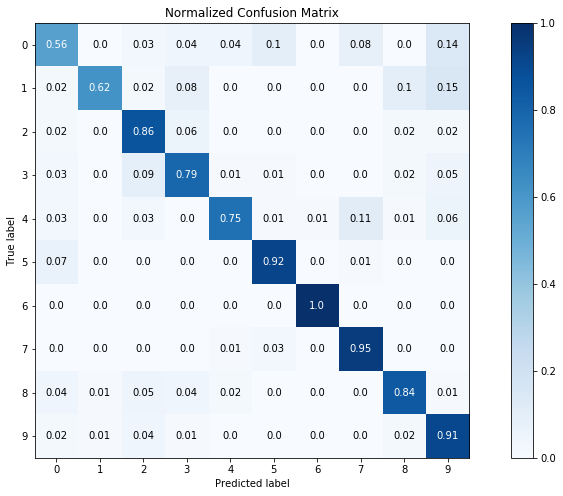

<Figure size 1080x576 with 0 Axes>

In [19]:
import scikitplot as skplt
plt.rcParams['figure.figsize'] = 15, 8
skplt.metrics.plot_confusion_matrix(y_test, predictions, normalize=True)
plt.show()
plt.savefig('DNN_KT_RS_Confusion_Matrix.png')

### Hyperband Optimization

In [20]:

from kerastuner.tuners import Hyperband
N_EPOCH_SEARCH = 20
HYPERBAND_MAX_EPOCHS = 40
MAX_TRIALS = 20
EXECUTION_PER_TRIAL = 3
SEED = 1
tuner = Hyperband(
    build_model,
    max_epochs=HYPERBAND_MAX_EPOCHS,
    objective='val_acc',
    seed=SEED,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='output',
    project_name='Urban Audio hyperband'
)

In [21]:
tuner.search(train_x, train_y, epochs=N_EPOCH_SEARCH, validation_split=0.1,callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

Train on 5419 samples, validate on 603 samples
Epoch 1/2
4992/5419 [==========================>...] - ETA: 1:15 - loss: 3.1513 - acc: 0.093 - ETA: 6s - loss: 2.2490 - acc: 0.6178  - ETA: 4s - loss: 2.2057 - acc: 0.654 - ETA: 3s - loss: 2.2127 - acc: 0.667 - ETA: 1s - loss: 2.0901 - acc: 0.695 - ETA: 1s - loss: 2.0741 - acc: 0.699 - ETA: 1s - loss: 1.9679 - acc: 0.717 - ETA: 1s - loss: 1.8607 - acc: 0.733 - ETA: 0s - loss: 1.8569 - acc: 0.735 - ETA: 0s - loss: 1.8732 - acc: 0.736 - ETA: 0s - loss: 1.8457 - acc: 0.740 - ETA: 0s - loss: 1.8348 - acc: 0.743 - ETA: 0s - loss: 1.8095 - acc: 0.748 - ETA: 0s - loss: 1.7524 - acc: 0.755 - ETA: 0s - loss: 1.7253 - acc: 0.759 - ETA: 0s - loss: 1.7282 - acc: 0.7612WARNING:tensorflow:This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.Adam object at 0x0000029D8D98A710>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFl

Train on 5419 samples, validate on 603 samples
Epoch 1/2
5280/5419 [============================>.] - ETA: 54s - loss: 3.0592 - acc: 0.06 - ETA: 5s - loss: 2.5656 - acc: 0.5651 - ETA: 2s - loss: 2.2220 - acc: 0.641 - ETA: 2s - loss: 2.0771 - acc: 0.669 - ETA: 2s - loss: 1.9885 - acc: 0.682 - ETA: 2s - loss: 1.9549 - acc: 0.690 - ETA: 1s - loss: 1.8763 - acc: 0.717 - ETA: 1s - loss: 1.8151 - acc: 0.730 - ETA: 1s - loss: 1.7963 - acc: 0.733 - ETA: 0s - loss: 1.7750 - acc: 0.739 - ETA: 0s - loss: 1.7098 - acc: 0.748 - ETA: 0s - loss: 1.6544 - acc: 0.754 - ETA: 0s - loss: 1.6573 - acc: 0.757 - ETA: 0s - loss: 1.6242 - acc: 0.761 - ETA: 0s - loss: 1.6229 - acc: 0.763 - ETA: 0s - loss: 1.5991 - acc: 0.766 - ETA: 0s - loss: 1.6029 - acc: 0.767 - ETA: 0s - loss: 1.6792 - acc: 0.766 - ETA: 0s - loss: 1.7167 - acc: 0.7644WARNING:tensorflow:This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.Adam object at 0x0000029D965FB9E8>) but is being saved in TensorFlow forma

Train on 5419 samples, validate on 603 samples
Epoch 1/2
5376/5419 [============================>.] - ETA: 29s - loss: 2.4547 - acc: 0.12 - ETA: 3s - loss: 2.3016 - acc: 0.2074 - ETA: 1s - loss: 2.0571 - acc: 0.294 - ETA: 1s - loss: 1.8707 - acc: 0.365 - ETA: 1s - loss: 1.6994 - acc: 0.429 - ETA: 1s - loss: 1.5878 - acc: 0.466 - ETA: 0s - loss: 1.4782 - acc: 0.507 - ETA: 0s - loss: 1.3861 - acc: 0.535 - ETA: 0s - loss: 1.3204 - acc: 0.559 - ETA: 0s - loss: 1.2596 - acc: 0.577 - ETA: 0s - loss: 1.2081 - acc: 0.594 - ETA: 0s - loss: 1.1625 - acc: 0.610 - ETA: 0s - loss: 1.1162 - acc: 0.627 - ETA: 0s - loss: 1.0859 - acc: 0.639 - ETA: 0s - loss: 1.0666 - acc: 0.647 - ETA: 0s - loss: 1.0320 - acc: 0.660 - ETA: 0s - loss: 1.0079 - acc: 0.667 - ETA: 0s - loss: 0.9840 - acc: 0.6771WARNING:tensorflow:This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.Adam object at 0x0000029D90FFD710>) but is being saved in TensorFlow format with `save_weights`. The model's wei

5419/5419 [==============================] - ETA: 1:48 - loss: 2.7946 - acc: 0.125 - ETA: 19s - loss: 2.7508 - acc: 0.125 - ETA: 11s - loss: 2.5683 - acc: 0.15 - ETA: 10s - loss: 2.4809 - acc: 0.16 - ETA: 8s - loss: 2.4040 - acc: 0.1934 - ETA: 7s - loss: 2.2800 - acc: 0.226 - ETA: 6s - loss: 2.1513 - acc: 0.266 - ETA: 4s - loss: 2.0133 - acc: 0.316 - ETA: 4s - loss: 1.8769 - acc: 0.371 - ETA: 3s - loss: 1.7518 - acc: 0.414 - ETA: 2s - loss: 1.6589 - acc: 0.446 - ETA: 2s - loss: 1.6412 - acc: 0.451 - ETA: 2s - loss: 1.6262 - acc: 0.457 - ETA: 2s - loss: 1.5959 - acc: 0.469 - ETA: 2s - loss: 1.5445 - acc: 0.488 - ETA: 2s - loss: 1.5014 - acc: 0.502 - ETA: 2s - loss: 1.4720 - acc: 0.513 - ETA: 2s - loss: 1.4417 - acc: 0.524 - ETA: 2s - loss: 1.4173 - acc: 0.532 - ETA: 1s - loss: 1.3899 - acc: 0.543 - ETA: 1s - loss: 1.3557 - acc: 0.556 - ETA: 1s - loss: 1.3284 - acc: 0.564 - ETA: 1s - loss: 1.3157 - acc: 0.569 - ETA: 1s - loss: 1.3036 - acc: 0.572 - ETA: 1s - loss: 1.2925 - acc: 0.576 - E

Train on 5419 samples, validate on 603 samples
Epoch 1/2
5376/5419 [============================>.] - ETA: 1:37 - loss: 2.8388 - acc: 0.031 - ETA: 52s - loss: 2.4897 - acc: 0.296 - ETA: 18s - loss: 2.2444 - acc: 0.54 - ETA: 8s - loss: 2.5414 - acc: 0.6106 - ETA: 5s - loss: 2.6004 - acc: 0.635 - ETA: 4s - loss: 2.6507 - acc: 0.651 - ETA: 4s - loss: 2.6563 - acc: 0.655 - ETA: 3s - loss: 2.6520 - acc: 0.668 - ETA: 2s - loss: 2.6404 - acc: 0.679 - ETA: 2s - loss: 2.6224 - acc: 0.684 - ETA: 2s - loss: 2.6226 - acc: 0.687 - ETA: 2s - loss: 2.5972 - acc: 0.693 - ETA: 1s - loss: 2.5230 - acc: 0.704 - ETA: 1s - loss: 2.4974 - acc: 0.709 - ETA: 1s - loss: 2.5304 - acc: 0.711 - ETA: 1s - loss: 2.5204 - acc: 0.712 - ETA: 1s - loss: 2.5082 - acc: 0.714 - ETA: 1s - loss: 2.4677 - acc: 0.720 - ETA: 1s - loss: 2.4596 - acc: 0.722 - ETA: 1s - loss: 2.4350 - acc: 0.724 - ETA: 0s - loss: 2.3771 - acc: 0.730 - ETA: 0s - loss: 2.3194 - acc: 0.734 - ETA: 0s - loss: 2.3128 - acc: 0.735 - ETA: 0s - loss: 2.29

5376/5419 [============================>.] - ETA: 0s - loss: 1.3421 - acc: 0.781 - ETA: 2s - loss: 2.7409 - acc: 0.757 - ETA: 1s - loss: 2.6861 - acc: 0.779 - ETA: 0s - loss: 2.2960 - acc: 0.802 - ETA: 0s - loss: 2.1975 - acc: 0.810 - ETA: 0s - loss: 2.1148 - acc: 0.817 - ETA: 1s - loss: 2.1160 - acc: 0.817 - ETA: 0s - loss: 2.1646 - acc: 0.816 - ETA: 0s - loss: 2.1686 - acc: 0.815 - ETA: 0s - loss: 2.2454 - acc: 0.811 - ETA: 0s - loss: 2.2664 - acc: 0.810 - ETA: 0s - loss: 2.3524 - acc: 0.805 - ETA: 0s - loss: 2.4010 - acc: 0.802 - ETA: 0s - loss: 2.3819 - acc: 0.802 - ETA: 0s - loss: 2.3553 - acc: 0.804 - ETA: 0s - loss: 2.3596 - acc: 0.804 - ETA: 0s - loss: 2.3436 - acc: 0.803 - ETA: 0s - loss: 2.3117 - acc: 0.807 - ETA: 0s - loss: 2.3400 - acc: 0.806 - ETA: 0s - loss: 2.3185 - acc: 0.807 - ETA: 0s - loss: 2.3228 - acc: 0.807 - ETA: 0s - loss: 2.3274 - acc: 0.807 - ETA: 0s - loss: 2.2965 - acc: 0.807 - ETA: 0s - loss: 2.3139 - acc: 0.806 - ETA: 0s - loss: 2.3187 - acc: 0.807 - ETA: 

Train on 5419 samples, validate on 603 samples
Epoch 1/2
5408/5419 [============================>.] - ETA: 2:42 - loss: 2.7369 - acc: 0.125 - ETA: 56s - loss: 2.4524 - acc: 0.208 - ETA: 24s - loss: 2.4153 - acc: 0.20 - ETA: 23s - loss: 2.3697 - acc: 0.21 - ETA: 15s - loss: 2.2917 - acc: 0.22 - ETA: 12s - loss: 2.1685 - acc: 0.27 - ETA: 10s - loss: 2.1133 - acc: 0.28 - ETA: 8s - loss: 1.9615 - acc: 0.3490 - ETA: 7s - loss: 1.8854 - acc: 0.375 - ETA: 7s - loss: 1.8206 - acc: 0.395 - ETA: 6s - loss: 1.7864 - acc: 0.406 - ETA: 6s - loss: 1.7748 - acc: 0.408 - ETA: 6s - loss: 1.7442 - acc: 0.418 - ETA: 6s - loss: 1.7109 - acc: 0.429 - ETA: 5s - loss: 1.6640 - acc: 0.447 - ETA: 5s - loss: 1.6186 - acc: 0.458 - ETA: 5s - loss: 1.6023 - acc: 0.464 - ETA: 4s - loss: 1.5367 - acc: 0.487 - ETA: 4s - loss: 1.5047 - acc: 0.501 - ETA: 4s - loss: 1.4880 - acc: 0.509 - ETA: 4s - loss: 1.4703 - acc: 0.515 - ETA: 4s - loss: 1.4620 - acc: 0.518 - ETA: 4s - loss: 1.4472 - acc: 0.524 - ETA: 4s - loss: 1.43

5419/5419 [==============================] - 3s 492us/sample - loss: 0.4904 - acc: 0.8441 - val_loss: 0.5040 - val_acc: 0.8441
Train on 5419 samples, validate on 603 samples
Epoch 1/2
5419/5419 [==============================] - ETA: 43s - loss: 3.1040 - acc: 0.03 - ETA: 5s - loss: 2.6313 - acc: 0.1187 - ETA: 3s - loss: 2.4199 - acc: 0.168 - ETA: 2s - loss: 2.2330 - acc: 0.240 - ETA: 1s - loss: 2.0487 - acc: 0.304 - ETA: 1s - loss: 1.9214 - acc: 0.354 - ETA: 1s - loss: 1.7581 - acc: 0.417 - ETA: 1s - loss: 1.6348 - acc: 0.456 - ETA: 1s - loss: 1.5570 - acc: 0.484 - ETA: 0s - loss: 1.4676 - acc: 0.516 - ETA: 0s - loss: 1.3939 - acc: 0.542 - ETA: 0s - loss: 1.3407 - acc: 0.559 - ETA: 0s - loss: 1.2928 - acc: 0.574 - ETA: 0s - loss: 1.2522 - acc: 0.587 - ETA: 0s - loss: 1.2138 - acc: 0.598 - ETA: 0s - loss: 1.1682 - acc: 0.615 - ETA: 0s - loss: 1.1327 - acc: 0.628 - ETA: 0s - loss: 1.1001 - acc: 0.639 - ETA: 0s - loss: 1.0690 - acc: 0.650 - 1s 244us/sample - loss: 1.0647 - acc: 0.6512 - v

Train on 5419 samples, validate on 603 samples
Epoch 1/2
5056/5419 [==========================>...] - ETA: 25s - loss: 2.9286 - acc: 0.09 - ETA: 2s - loss: 1.2341 - acc: 0.6000 - ETA: 1s - loss: 0.9368 - acc: 0.683 - ETA: 0s - loss: 0.8215 - acc: 0.727 - ETA: 0s - loss: 0.7502 - acc: 0.752 - ETA: 0s - loss: 0.6928 - acc: 0.772 - ETA: 0s - loss: 0.6501 - acc: 0.787 - ETA: 0s - loss: 0.6213 - acc: 0.797 - ETA: 0s - loss: 0.5908 - acc: 0.805 - ETA: 0s - loss: 0.5734 - acc: 0.812 - ETA: 0s - loss: 0.5568 - acc: 0.8178WARNING:tensorflow:This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.Adam object at 0x0000029D8D985B38>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.
5419/5419 [==============================] - 1s 156us/sample - loss: 0.5422 - acc: 0.8

Train on 5419 samples, validate on 603 samples
Epoch 1/2
5376/5419 [============================>.] - ETA: 1:13 - loss: 3.0988 - acc: 0.0000e+0 - ETA: 9s - loss: 1.5064 - acc: 0.5391      - ETA: 7s - loss: 1.3113 - acc: 0.596 - ETA: 5s - loss: 1.2016 - acc: 0.634 - ETA: 4s - loss: 1.1177 - acc: 0.665 - ETA: 4s - loss: 1.0653 - acc: 0.679 - ETA: 3s - loss: 0.9912 - acc: 0.705 - ETA: 3s - loss: 0.9362 - acc: 0.725 - ETA: 2s - loss: 0.8652 - acc: 0.740 - ETA: 2s - loss: 0.8688 - acc: 0.740 - ETA: 2s - loss: 0.8456 - acc: 0.745 - ETA: 2s - loss: 0.8217 - acc: 0.753 - ETA: 2s - loss: 0.8133 - acc: 0.754 - ETA: 2s - loss: 0.7900 - acc: 0.761 - ETA: 2s - loss: 0.7837 - acc: 0.761 - ETA: 2s - loss: 0.7791 - acc: 0.763 - ETA: 2s - loss: 0.7602 - acc: 0.767 - ETA: 2s - loss: 0.7415 - acc: 0.770 - ETA: 1s - loss: 0.7204 - acc: 0.776 - ETA: 1s - loss: 0.7088 - acc: 0.780 - ETA: 1s - loss: 0.6941 - acc: 0.784 - ETA: 1s - loss: 0.6881 - acc: 0.787 - ETA: 1s - loss: 0.6779 - acc: 0.790 - ETA: 1s - lo

5408/5419 [============================>.] - ETA: 2s - loss: 0.1648 - acc: 0.937 - ETA: 3s - loss: 0.1732 - acc: 0.929 - ETA: 2s - loss: 0.2001 - acc: 0.923 - ETA: 2s - loss: 0.1778 - acc: 0.930 - ETA: 2s - loss: 0.1725 - acc: 0.939 - ETA: 2s - loss: 0.1650 - acc: 0.942 - ETA: 2s - loss: 0.1529 - acc: 0.948 - ETA: 2s - loss: 0.1478 - acc: 0.951 - ETA: 2s - loss: 0.1485 - acc: 0.952 - ETA: 2s - loss: 0.1533 - acc: 0.951 - ETA: 2s - loss: 0.1549 - acc: 0.951 - ETA: 2s - loss: 0.1503 - acc: 0.953 - ETA: 1s - loss: 0.1529 - acc: 0.951 - ETA: 1s - loss: 0.1551 - acc: 0.951 - ETA: 1s - loss: 0.1525 - acc: 0.952 - ETA: 1s - loss: 0.1572 - acc: 0.951 - ETA: 1s - loss: 0.1553 - acc: 0.952 - ETA: 1s - loss: 0.1596 - acc: 0.951 - ETA: 1s - loss: 0.1682 - acc: 0.951 - ETA: 1s - loss: 0.1672 - acc: 0.951 - ETA: 1s - loss: 0.1676 - acc: 0.950 - ETA: 1s - loss: 0.1686 - acc: 0.950 - ETA: 1s - loss: 0.1658 - acc: 0.951 - ETA: 1s - loss: 0.1649 - acc: 0.951 - ETA: 1s - loss: 0.1605 - acc: 0.953 - ETA: 

Train on 5419 samples, validate on 603 samples
Epoch 1/2
5376/5419 [============================>.] - ETA: 1:11 - loss: 3.4010 - acc: 0.0000e+0 - ETA: 13s - loss: 2.9724 - acc: 0.4740    - ETA: 6s - loss: 2.9737 - acc: 0.5841 - ETA: 3s - loss: 3.2312 - acc: 0.608 - ETA: 3s - loss: 3.2104 - acc: 0.622 - ETA: 3s - loss: 3.1480 - acc: 0.631 - ETA: 3s - loss: 3.0310 - acc: 0.641 - ETA: 2s - loss: 3.0188 - acc: 0.651 - ETA: 2s - loss: 3.0329 - acc: 0.652 - ETA: 2s - loss: 2.9297 - acc: 0.666 - ETA: 2s - loss: 2.9080 - acc: 0.672 - ETA: 1s - loss: 2.8951 - acc: 0.680 - ETA: 1s - loss: 2.8403 - acc: 0.687 - ETA: 1s - loss: 2.7385 - acc: 0.697 - ETA: 1s - loss: 2.7177 - acc: 0.699 - ETA: 1s - loss: 2.6912 - acc: 0.703 - ETA: 1s - loss: 2.6657 - acc: 0.707 - ETA: 1s - loss: 2.6473 - acc: 0.707 - ETA: 1s - loss: 2.6742 - acc: 0.709 - ETA: 1s - loss: 2.6940 - acc: 0.708 - ETA: 1s - loss: 2.6497 - acc: 0.715 - ETA: 0s - loss: 2.6427 - acc: 0.716 - ETA: 0s - loss: 2.6364 - acc: 0.717 - ETA: 0s - lo

Train on 5419 samples, validate on 603 samples
Epoch 1/2
5376/5419 [============================>.] - ETA: 20s - loss: 3.0175 - acc: 0.06 - ETA: 5s - loss: 3.0400 - acc: 0.0750 - ETA: 3s - loss: 2.7131 - acc: 0.137 - ETA: 3s - loss: 2.5494 - acc: 0.189 - ETA: 3s - loss: 2.5059 - acc: 0.195 - ETA: 3s - loss: 2.3583 - acc: 0.226 - ETA: 2s - loss: 2.2191 - acc: 0.269 - ETA: 2s - loss: 2.1495 - acc: 0.300 - ETA: 2s - loss: 1.9708 - acc: 0.352 - ETA: 2s - loss: 1.9007 - acc: 0.379 - ETA: 2s - loss: 1.8265 - acc: 0.404 - ETA: 1s - loss: 1.7415 - acc: 0.428 - ETA: 1s - loss: 1.6882 - acc: 0.445 - ETA: 1s - loss: 1.6349 - acc: 0.463 - ETA: 1s - loss: 1.5871 - acc: 0.477 - ETA: 1s - loss: 1.5366 - acc: 0.495 - ETA: 1s - loss: 1.5019 - acc: 0.507 - ETA: 1s - loss: 1.4611 - acc: 0.520 - ETA: 1s - loss: 1.4287 - acc: 0.532 - ETA: 1s - loss: 1.3977 - acc: 0.545 - ETA: 1s - loss: 1.3840 - acc: 0.549 - ETA: 1s - loss: 1.3445 - acc: 0.562 - ETA: 1s - loss: 1.3234 - acc: 0.569 - ETA: 1s - loss: 1.2974 

5419/5419 [==============================] - ETA: 1:15 - loss: 2.6131 - acc: 0.125 - ETA: 16s - loss: 2.8076 - acc: 0.100 - ETA: 12s - loss: 2.6786 - acc: 0.12 - ETA: 8s - loss: 2.5027 - acc: 0.1648 - ETA: 6s - loss: 2.4433 - acc: 0.181 - ETA: 5s - loss: 2.3091 - acc: 0.225 - ETA: 4s - loss: 2.1700 - acc: 0.266 - ETA: 3s - loss: 2.0344 - acc: 0.310 - ETA: 3s - loss: 1.8968 - acc: 0.356 - ETA: 3s - loss: 1.8300 - acc: 0.379 - ETA: 2s - loss: 1.7767 - acc: 0.399 - ETA: 2s - loss: 1.7404 - acc: 0.412 - ETA: 2s - loss: 1.6970 - acc: 0.428 - ETA: 2s - loss: 1.6385 - acc: 0.452 - ETA: 2s - loss: 1.5927 - acc: 0.470 - ETA: 2s - loss: 1.5326 - acc: 0.490 - ETA: 1s - loss: 1.4745 - acc: 0.512 - ETA: 1s - loss: 1.4376 - acc: 0.526 - ETA: 1s - loss: 1.3979 - acc: 0.539 - ETA: 1s - loss: 1.3658 - acc: 0.549 - ETA: 1s - loss: 1.3367 - acc: 0.557 - ETA: 1s - loss: 1.3050 - acc: 0.568 - ETA: 1s - loss: 1.2853 - acc: 0.576 - ETA: 1s - loss: 1.2775 - acc: 0.578 - ETA: 1s - loss: 1.2668 - acc: 0.582 - E

Train on 5419 samples, validate on 603 samples
Epoch 1/2
5376/5419 [============================>.] - ETA: 1:16 - loss: 3.0849 - acc: 0.031 - ETA: 16s - loss: 2.6869 - acc: 0.062 - ETA: 8s - loss: 2.4641 - acc: 0.1312 - ETA: 6s - loss: 2.2650 - acc: 0.200 - ETA: 5s - loss: 2.1431 - acc: 0.250 - ETA: 4s - loss: 2.0568 - acc: 0.277 - ETA: 4s - loss: 1.9856 - acc: 0.307 - ETA: 4s - loss: 1.8697 - acc: 0.357 - ETA: 4s - loss: 1.8220 - acc: 0.370 - ETA: 3s - loss: 1.7477 - acc: 0.398 - ETA: 3s - loss: 1.6793 - acc: 0.426 - ETA: 3s - loss: 1.6303 - acc: 0.440 - ETA: 3s - loss: 1.5762 - acc: 0.459 - ETA: 2s - loss: 1.5224 - acc: 0.477 - ETA: 2s - loss: 1.5071 - acc: 0.484 - ETA: 2s - loss: 1.4947 - acc: 0.488 - ETA: 2s - loss: 1.4286 - acc: 0.515 - ETA: 2s - loss: 1.4072 - acc: 0.522 - ETA: 2s - loss: 1.3798 - acc: 0.530 - ETA: 2s - loss: 1.3536 - acc: 0.541 - ETA: 2s - loss: 1.3363 - acc: 0.548 - ETA: 1s - loss: 1.2802 - acc: 0.570 - ETA: 1s - loss: 1.2689 - acc: 0.575 - ETA: 1s - loss: 1.24

5344/5419 [============================>.] - ETA: 1s - loss: 0.3557 - acc: 0.906 - ETA: 2s - loss: 0.4332 - acc: 0.882 - ETA: 3s - loss: 0.4444 - acc: 0.875 - ETA: 3s - loss: 0.4800 - acc: 0.859 - ETA: 2s - loss: 0.4665 - acc: 0.856 - ETA: 3s - loss: 0.4844 - acc: 0.850 - ETA: 2s - loss: 0.5065 - acc: 0.842 - ETA: 2s - loss: 0.5072 - acc: 0.839 - ETA: 2s - loss: 0.4884 - acc: 0.849 - ETA: 2s - loss: 0.4932 - acc: 0.841 - ETA: 2s - loss: 0.4811 - acc: 0.845 - ETA: 2s - loss: 0.4737 - acc: 0.847 - ETA: 2s - loss: 0.4748 - acc: 0.845 - ETA: 2s - loss: 0.4754 - acc: 0.849 - ETA: 2s - loss: 0.4725 - acc: 0.851 - ETA: 2s - loss: 0.4702 - acc: 0.851 - ETA: 2s - loss: 0.4716 - acc: 0.851 - ETA: 2s - loss: 0.4749 - acc: 0.851 - ETA: 1s - loss: 0.4717 - acc: 0.853 - ETA: 2s - loss: 0.4751 - acc: 0.851 - ETA: 1s - loss: 0.4773 - acc: 0.849 - ETA: 1s - loss: 0.4732 - acc: 0.850 - ETA: 1s - loss: 0.4677 - acc: 0.854 - ETA: 1s - loss: 0.4659 - acc: 0.855 - ETA: 1s - loss: 0.4619 - acc: 0.857 - ETA: 

Train on 5419 samples, validate on 603 samples
Epoch 1/2
5120/5419 [===========================>..] - ETA: 36s - loss: 3.2098 - acc: 0.12 - ETA: 2s - loss: 2.3028 - acc: 0.2299 - ETA: 1s - loss: 2.0000 - acc: 0.328 - ETA: 1s - loss: 1.8230 - acc: 0.390 - ETA: 1s - loss: 1.6675 - acc: 0.446 - ETA: 0s - loss: 1.5719 - acc: 0.474 - ETA: 0s - loss: 1.4946 - acc: 0.500 - ETA: 0s - loss: 1.4292 - acc: 0.519 - ETA: 0s - loss: 1.3549 - acc: 0.547 - ETA: 0s - loss: 1.2868 - acc: 0.570 - ETA: 0s - loss: 1.2439 - acc: 0.588 - ETA: 0s - loss: 1.1876 - acc: 0.609 - ETA: 0s - loss: 1.1494 - acc: 0.623 - ETA: 0s - loss: 1.1118 - acc: 0.635 - ETA: 0s - loss: 1.0746 - acc: 0.6465WARNING:tensorflow:This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.Adam object at 0x0000029D966E2E80>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not 

Train on 5419 samples, validate on 603 samples
Epoch 1/2
5312/5419 [============================>.] - ETA: 1:50 - loss: 2.9098 - acc: 0.062 - ETA: 19s - loss: 3.2021 - acc: 0.489 - ETA: 10s - loss: 2.9528 - acc: 0.58 - ETA: 8s - loss: 3.1180 - acc: 0.5896 - ETA: 7s - loss: 2.9906 - acc: 0.614 - ETA: 7s - loss: 3.0406 - acc: 0.612 - ETA: 5s - loss: 3.1797 - acc: 0.631 - ETA: 4s - loss: 3.0781 - acc: 0.651 - ETA: 4s - loss: 3.1500 - acc: 0.654 - ETA: 4s - loss: 3.2067 - acc: 0.650 - ETA: 3s - loss: 3.2915 - acc: 0.652 - ETA: 3s - loss: 3.3477 - acc: 0.650 - ETA: 3s - loss: 3.4668 - acc: 0.647 - ETA: 3s - loss: 3.5178 - acc: 0.645 - ETA: 3s - loss: 3.4879 - acc: 0.653 - ETA: 2s - loss: 3.6037 - acc: 0.649 - ETA: 2s - loss: 3.6572 - acc: 0.650 - ETA: 2s - loss: 3.6456 - acc: 0.657 - ETA: 2s - loss: 3.6543 - acc: 0.664 - ETA: 1s - loss: 3.7131 - acc: 0.663 - ETA: 1s - loss: 3.7040 - acc: 0.667 - ETA: 1s - loss: 3.7264 - acc: 0.667 - ETA: 1s - loss: 3.7105 - acc: 0.669 - ETA: 1s - loss: 3.70

5419/5419 [==============================] - ETA: 1s - loss: 2.6468 - acc: 0.718 - ETA: 3s - loss: 3.6965 - acc: 0.697 - ETA: 2s - loss: 3.8680 - acc: 0.718 - ETA: 2s - loss: 3.7007 - acc: 0.738 - ETA: 2s - loss: 3.5308 - acc: 0.752 - ETA: 2s - loss: 3.2699 - acc: 0.771 - ETA: 2s - loss: 3.2685 - acc: 0.767 - ETA: 2s - loss: 3.3234 - acc: 0.768 - ETA: 2s - loss: 3.3793 - acc: 0.765 - ETA: 2s - loss: 3.3735 - acc: 0.766 - ETA: 2s - loss: 3.4003 - acc: 0.766 - ETA: 1s - loss: 3.3862 - acc: 0.767 - ETA: 1s - loss: 3.3535 - acc: 0.768 - ETA: 1s - loss: 3.3650 - acc: 0.767 - ETA: 1s - loss: 3.3516 - acc: 0.767 - ETA: 1s - loss: 3.3862 - acc: 0.764 - ETA: 1s - loss: 3.3291 - acc: 0.768 - ETA: 1s - loss: 3.3251 - acc: 0.769 - ETA: 1s - loss: 3.3108 - acc: 0.770 - ETA: 1s - loss: 3.2504 - acc: 0.774 - ETA: 1s - loss: 3.2408 - acc: 0.775 - ETA: 1s - loss: 3.2498 - acc: 0.774 - ETA: 1s - loss: 3.2517 - acc: 0.774 - ETA: 1s - loss: 3.2763 - acc: 0.774 - ETA: 1s - loss: 3.2913 - acc: 0.772 - ETA: 

Train on 5419 samples, validate on 603 samples
Epoch 1/2
5408/5419 [============================>.] - ETA: 1:49 - loss: 2.9792 - acc: 0.125 - ETA: 7s - loss: 2.2437 - acc: 0.5917  - ETA: 6s - loss: 2.1230 - acc: 0.621 - ETA: 3s - loss: 2.0462 - acc: 0.667 - ETA: 2s - loss: 2.0030 - acc: 0.676 - ETA: 2s - loss: 1.9205 - acc: 0.683 - ETA: 1s - loss: 1.8727 - acc: 0.700 - ETA: 1s - loss: 1.8084 - acc: 0.717 - ETA: 1s - loss: 1.7563 - acc: 0.725 - ETA: 0s - loss: 1.7340 - acc: 0.727 - ETA: 0s - loss: 1.7028 - acc: 0.728 - ETA: 0s - loss: 1.6899 - acc: 0.732 - ETA: 0s - loss: 1.6321 - acc: 0.739 - ETA: 0s - loss: 1.6439 - acc: 0.743 - ETA: 0s - loss: 1.6412 - acc: 0.744 - ETA: 0s - loss: 1.6316 - acc: 0.745 - ETA: 0s - loss: 1.6087 - acc: 0.747 - ETA: 0s - loss: 1.5990 - acc: 0.749 - ETA: 0s - loss: 1.5702 - acc: 0.753 - ETA: 0s - loss: 1.5573 - acc: 0.7546WARNING:tensorflow:This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.Adam object at 0x0000029D967FF6D8

Train on 5419 samples, validate on 603 samples
Epoch 1/2
5312/5419 [============================>.] - ETA: 22s - loss: 2.7125 - acc: 0.06 - ETA: 2s - loss: 1.3331 - acc: 0.5755 - ETA: 1s - loss: 1.1064 - acc: 0.660 - ETA: 1s - loss: 0.9695 - acc: 0.692 - ETA: 0s - loss: 0.8567 - acc: 0.725 - ETA: 0s - loss: 0.7935 - acc: 0.745 - ETA: 0s - loss: 0.7564 - acc: 0.759 - ETA: 0s - loss: 0.7184 - acc: 0.768 - ETA: 0s - loss: 0.6833 - acc: 0.781 - ETA: 0s - loss: 0.6548 - acc: 0.790 - ETA: 0s - loss: 0.6344 - acc: 0.796 - ETA: 0s - loss: 0.6173 - acc: 0.801 - ETA: 0s - loss: 0.6087 - acc: 0.804 - ETA: 0s - loss: 0.5917 - acc: 0.810 - ETA: 0s - loss: 0.5732 - acc: 0.815 - ETA: 0s - loss: 0.5574 - acc: 0.8193WARNING:tensorflow:This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.Adam object at 0x0000029D9658B9E8>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow 

Train on 5419 samples, validate on 603 samples
Epoch 1/2
5280/5419 [============================>.] - ETA: 1:19 - loss: 2.7796 - acc: 0.218 - ETA: 6s - loss: 1.4384 - acc: 0.5385  - ETA: 4s - loss: 1.1979 - acc: 0.610 - ETA: 3s - loss: 1.0049 - acc: 0.669 - ETA: 2s - loss: 0.9445 - acc: 0.691 - ETA: 2s - loss: 0.8932 - acc: 0.706 - ETA: 1s - loss: 0.8480 - acc: 0.723 - ETA: 1s - loss: 0.7998 - acc: 0.743 - ETA: 1s - loss: 0.7570 - acc: 0.756 - ETA: 1s - loss: 0.7096 - acc: 0.768 - ETA: 0s - loss: 0.6978 - acc: 0.775 - ETA: 0s - loss: 0.6693 - acc: 0.783 - ETA: 0s - loss: 0.6529 - acc: 0.787 - ETA: 0s - loss: 0.6431 - acc: 0.790 - ETA: 0s - loss: 0.6277 - acc: 0.795 - ETA: 0s - loss: 0.6172 - acc: 0.798 - ETA: 0s - loss: 0.6101 - acc: 0.800 - ETA: 0s - loss: 0.5874 - acc: 0.807 - ETA: 0s - loss: 0.5776 - acc: 0.810 - ETA: 0s - loss: 0.5696 - acc: 0.8133WARNING:tensorflow:This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.Adam object at 0x0000029D965FBC88

Train on 5419 samples, validate on 603 samples
Epoch 1/2
5312/5419 [============================>.] - ETA: 1:07 - loss: 2.9085 - acc: 0.156 - ETA: 5s - loss: 1.6169 - acc: 0.4922  - ETA: 2s - loss: 1.1391 - acc: 0.638 - ETA: 1s - loss: 0.9676 - acc: 0.698 - ETA: 1s - loss: 0.8807 - acc: 0.722 - ETA: 1s - loss: 0.8412 - acc: 0.735 - ETA: 0s - loss: 0.7547 - acc: 0.761 - ETA: 0s - loss: 0.7250 - acc: 0.772 - ETA: 0s - loss: 0.6949 - acc: 0.778 - ETA: 0s - loss: 0.6706 - acc: 0.786 - ETA: 0s - loss: 0.6492 - acc: 0.793 - ETA: 0s - loss: 0.6351 - acc: 0.796 - ETA: 0s - loss: 0.6229 - acc: 0.799 - ETA: 0s - loss: 0.6058 - acc: 0.8038WARNING:tensorflow:This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.Adam object at 0x0000029D96DF7BE0>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorF

Train on 5419 samples, validate on 603 samples
Epoch 1/2
5120/5419 [===========================>..] - ETA: 1:31 - loss: 3.0968 - acc: 0.062 - ETA: 13s - loss: 2.8582 - acc: 0.089 - ETA: 13s - loss: 2.8148 - acc: 0.10 - ETA: 7s - loss: 2.5852 - acc: 0.1607 - ETA: 6s - loss: 2.4355 - acc: 0.207 - ETA: 5s - loss: 2.3341 - acc: 0.235 - ETA: 3s - loss: 2.1314 - acc: 0.301 - ETA: 3s - loss: 2.0494 - acc: 0.321 - ETA: 3s - loss: 1.9825 - acc: 0.341 - ETA: 2s - loss: 1.8758 - acc: 0.379 - ETA: 2s - loss: 1.8019 - acc: 0.403 - ETA: 2s - loss: 1.7606 - acc: 0.418 - ETA: 2s - loss: 1.6900 - acc: 0.443 - ETA: 1s - loss: 1.6485 - acc: 0.455 - ETA: 1s - loss: 1.6263 - acc: 0.464 - ETA: 1s - loss: 1.5715 - acc: 0.486 - ETA: 1s - loss: 1.5676 - acc: 0.487 - ETA: 1s - loss: 1.5059 - acc: 0.509 - ETA: 1s - loss: 1.4803 - acc: 0.517 - ETA: 1s - loss: 1.4465 - acc: 0.528 - ETA: 1s - loss: 1.4191 - acc: 0.537 - ETA: 1s - loss: 1.3866 - acc: 0.549 - ETA: 1s - loss: 1.3790 - acc: 0.551 - ETA: 0s - loss: 1.32

Train on 5419 samples, validate on 603 samples
Epoch 1/2
5184/5419 [===========================>..] - ETA: 32s - loss: 3.1049 - acc: 0.03 - ETA: 1s - loss: 1.2102 - acc: 0.6130 - ETA: 0s - loss: 0.9014 - acc: 0.711 - ETA: 0s - loss: 0.7986 - acc: 0.743 - ETA: 0s - loss: 0.7298 - acc: 0.764 - ETA: 0s - loss: 0.6946 - acc: 0.775 - ETA: 0s - loss: 0.6801 - acc: 0.779 - ETA: 0s - loss: 0.6623 - acc: 0.784 - ETA: 0s - loss: 0.6471 - acc: 0.789 - ETA: 0s - loss: 0.6352 - acc: 0.793 - ETA: 0s - loss: 0.6151 - acc: 0.797 - ETA: 0s - loss: 0.6085 - acc: 0.801 - ETA: 0s - loss: 0.5887 - acc: 0.8075WARNING:tensorflow:This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.Adam object at 0x0000029D965FB6D8>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.
5419/5419 

Train on 5419 samples, validate on 603 samples
Epoch 1/2
5344/5419 [============================>.] - ETA: 1:34 - loss: 2.9739 - acc: 0.0000e+0 - ETA: 20s - loss: 2.8942 - acc: 0.4313    - ETA: 11s - loss: 2.8803 - acc: 0.54 - ETA: 11s - loss: 2.8987 - acc: 0.56 - ETA: 6s - loss: 2.6806 - acc: 0.6267 - ETA: 5s - loss: 2.5962 - acc: 0.642 - ETA: 5s - loss: 2.6094 - acc: 0.651 - ETA: 4s - loss: 2.8137 - acc: 0.651 - ETA: 4s - loss: 2.9301 - acc: 0.649 - ETA: 3s - loss: 2.9660 - acc: 0.662 - ETA: 3s - loss: 3.0320 - acc: 0.660 - ETA: 3s - loss: 3.0473 - acc: 0.663 - ETA: 3s - loss: 2.9966 - acc: 0.671 - ETA: 3s - loss: 2.9934 - acc: 0.676 - ETA: 3s - loss: 2.9757 - acc: 0.679 - ETA: 2s - loss: 2.9979 - acc: 0.682 - ETA: 2s - loss: 2.9761 - acc: 0.687 - ETA: 2s - loss: 2.9972 - acc: 0.688 - ETA: 2s - loss: 3.0178 - acc: 0.690 - ETA: 2s - loss: 2.9930 - acc: 0.694 - ETA: 1s - loss: 2.9422 - acc: 0.703 - ETA: 1s - loss: 2.9727 - acc: 0.704 - ETA: 1s - loss: 2.9902 - acc: 0.705 - ETA: 1s - lo

5419/5419 [==============================] - ETA: 1:32 - loss: 3.1469 - acc: 0.093 - ETA: 12s - loss: 2.7349 - acc: 0.582 - ETA: 8s - loss: 2.9511 - acc: 0.6120 - ETA: 6s - loss: 2.8742 - acc: 0.645 - ETA: 5s - loss: 2.9380 - acc: 0.645 - ETA: 4s - loss: 3.0462 - acc: 0.650 - ETA: 4s - loss: 3.0998 - acc: 0.653 - ETA: 3s - loss: 3.1337 - acc: 0.660 - ETA: 3s - loss: 3.1424 - acc: 0.665 - ETA: 3s - loss: 3.1222 - acc: 0.668 - ETA: 2s - loss: 3.1573 - acc: 0.669 - ETA: 2s - loss: 3.1505 - acc: 0.671 - ETA: 2s - loss: 3.0921 - acc: 0.681 - ETA: 2s - loss: 3.0738 - acc: 0.687 - ETA: 2s - loss: 3.0762 - acc: 0.690 - ETA: 2s - loss: 3.0686 - acc: 0.692 - ETA: 2s - loss: 3.0515 - acc: 0.697 - ETA: 2s - loss: 3.0747 - acc: 0.696 - ETA: 2s - loss: 3.0461 - acc: 0.701 - ETA: 1s - loss: 3.0272 - acc: 0.703 - ETA: 1s - loss: 3.0131 - acc: 0.705 - ETA: 1s - loss: 2.9645 - acc: 0.710 - ETA: 1s - loss: 2.9748 - acc: 0.711 - ETA: 1s - loss: 3.0294 - acc: 0.710 - ETA: 1s - loss: 3.0275 - acc: 0.711 - E

Train on 5419 samples, validate on 603 samples
Epoch 1/2
5152/5419 [===========================>..] - ETA: 1:29 - loss: 2.4007 - acc: 0.125 - ETA: 13s - loss: 2.6200 - acc: 0.102 - ETA: 10s - loss: 2.5529 - acc: 0.12 - ETA: 3s - loss: 2.2051 - acc: 0.2431 - ETA: 2s - loss: 2.0795 - acc: 0.281 - ETA: 2s - loss: 2.0306 - acc: 0.301 - ETA: 2s - loss: 1.9607 - acc: 0.326 - ETA: 1s - loss: 1.8562 - acc: 0.364 - ETA: 1s - loss: 1.7534 - acc: 0.405 - ETA: 1s - loss: 1.5930 - acc: 0.464 - ETA: 1s - loss: 1.5556 - acc: 0.475 - ETA: 0s - loss: 1.4834 - acc: 0.502 - ETA: 0s - loss: 1.4632 - acc: 0.509 - ETA: 0s - loss: 1.4512 - acc: 0.512 - ETA: 0s - loss: 1.3952 - acc: 0.532 - ETA: 0s - loss: 1.3691 - acc: 0.540 - ETA: 0s - loss: 1.3651 - acc: 0.540 - ETA: 0s - loss: 1.3576 - acc: 0.543 - ETA: 0s - loss: 1.3078 - acc: 0.562 - ETA: 0s - loss: 1.2563 - acc: 0.581 - ETA: 0s - loss: 1.2333 - acc: 0.5895WARNING:tensorflow:This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimi

Train on 5419 samples, validate on 603 samples
Epoch 1/2
5280/5419 [============================>.] - ETA: 22s - loss: 2.7274 - acc: 0.09 - ETA: 1s - loss: 2.8027 - acc: 0.5699 - ETA: 1s - loss: 2.5265 - acc: 0.644 - ETA: 0s - loss: 2.4651 - acc: 0.677 - ETA: 0s - loss: 2.4368 - acc: 0.694 - ETA: 0s - loss: 2.4261 - acc: 0.709 - ETA: 0s - loss: 2.3673 - acc: 0.720 - ETA: 0s - loss: 2.3097 - acc: 0.732 - ETA: 0s - loss: 2.3296 - acc: 0.736 - ETA: 0s - loss: 2.3073 - acc: 0.741 - ETA: 0s - loss: 2.2985 - acc: 0.7443WARNING:tensorflow:This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.Adam object at 0x0000029D910D6D68>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.
5419/5419 [==============================] - 1s 142us/sample - loss: 2.2894 - acc: 0.7

Train on 5419 samples, validate on 603 samples
Epoch 1/2
5280/5419 [============================>.] - ETA: 1:17 - loss: 2.4919 - acc: 0.062 - ETA: 6s - loss: 2.3479 - acc: 0.1901  - ETA: 5s - loss: 2.3033 - acc: 0.201 - ETA: 2s - loss: 1.9819 - acc: 0.308 - ETA: 2s - loss: 1.8492 - acc: 0.362 - ETA: 1s - loss: 1.6846 - acc: 0.422 - ETA: 1s - loss: 1.5876 - acc: 0.457 - ETA: 1s - loss: 1.4698 - acc: 0.505 - ETA: 1s - loss: 1.4374 - acc: 0.518 - ETA: 0s - loss: 1.3628 - acc: 0.542 - ETA: 0s - loss: 1.3140 - acc: 0.559 - ETA: 0s - loss: 1.2907 - acc: 0.569 - ETA: 0s - loss: 1.2507 - acc: 0.583 - ETA: 0s - loss: 1.2068 - acc: 0.597 - ETA: 0s - loss: 1.1689 - acc: 0.613 - ETA: 0s - loss: 1.1350 - acc: 0.625 - ETA: 0s - loss: 1.1015 - acc: 0.6362WARNING:tensorflow:This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.Adam object at 0x0000029D96E44898>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with

Train on 5419 samples, validate on 603 samples
Epoch 1/2
5344/5419 [============================>.] - ETA: 1:12 - loss: 2.6711 - acc: 0.125 - ETA: 27s - loss: 2.4288 - acc: 0.479 - ETA: 12s - loss: 3.6114 - acc: 0.53 - ETA: 8s - loss: 3.7008 - acc: 0.5833 - ETA: 6s - loss: 3.9361 - acc: 0.595 - ETA: 5s - loss: 3.9972 - acc: 0.603 - ETA: 5s - loss: 4.1205 - acc: 0.604 - ETA: 4s - loss: 4.2903 - acc: 0.611 - ETA: 4s - loss: 4.2992 - acc: 0.611 - ETA: 4s - loss: 4.2293 - acc: 0.621 - ETA: 4s - loss: 4.0771 - acc: 0.638 - ETA: 4s - loss: 4.0214 - acc: 0.645 - ETA: 3s - loss: 4.1609 - acc: 0.642 - ETA: 3s - loss: 4.0820 - acc: 0.649 - ETA: 3s - loss: 4.1268 - acc: 0.649 - ETA: 2s - loss: 4.0153 - acc: 0.658 - ETA: 2s - loss: 4.0054 - acc: 0.661 - ETA: 2s - loss: 3.9655 - acc: 0.664 - ETA: 2s - loss: 3.9725 - acc: 0.667 - ETA: 2s - loss: 3.9840 - acc: 0.668 - ETA: 2s - loss: 3.9828 - acc: 0.670 - ETA: 2s - loss: 4.0269 - acc: 0.669 - ETA: 1s - loss: 4.0448 - acc: 0.672 - ETA: 1s - loss: 4.05

5344/5419 [============================>.] - ETA: 1s - loss: 4.7086 - acc: 0.687 - ETA: 1s - loss: 2.9634 - acc: 0.803 - ETA: 2s - loss: 2.7189 - acc: 0.820 - ETA: 2s - loss: 3.0745 - acc: 0.798 - ETA: 1s - loss: 3.1216 - acc: 0.788 - ETA: 1s - loss: 3.2862 - acc: 0.779 - ETA: 1s - loss: 3.2781 - acc: 0.782 - ETA: 1s - loss: 3.1205 - acc: 0.792 - ETA: 1s - loss: 3.1278 - acc: 0.792 - ETA: 1s - loss: 3.0981 - acc: 0.794 - ETA: 1s - loss: 3.0644 - acc: 0.797 - ETA: 1s - loss: 3.0843 - acc: 0.796 - ETA: 1s - loss: 3.1750 - acc: 0.790 - ETA: 1s - loss: 3.1996 - acc: 0.790 - ETA: 1s - loss: 3.2393 - acc: 0.787 - ETA: 1s - loss: 3.2026 - acc: 0.789 - ETA: 1s - loss: 3.1993 - acc: 0.790 - ETA: 1s - loss: 3.1808 - acc: 0.790 - ETA: 1s - loss: 3.2172 - acc: 0.787 - ETA: 1s - loss: 3.2433 - acc: 0.786 - ETA: 1s - loss: 3.2527 - acc: 0.785 - ETA: 1s - loss: 3.2533 - acc: 0.786 - ETA: 1s - loss: 3.2273 - acc: 0.787 - ETA: 1s - loss: 3.2744 - acc: 0.784 - ETA: 1s - loss: 3.2951 - acc: 0.782 - ETA: 

Train on 5419 samples, validate on 603 samples
Epoch 1/2
5216/5419 [===========================>..] - ETA: 22s - loss: 3.2586 - acc: 0.06 - ETA: 1s - loss: 1.1194 - acc: 0.6406 - ETA: 0s - loss: 0.8670 - acc: 0.725 - ETA: 0s - loss: 0.7623 - acc: 0.755 - ETA: 0s - loss: 0.6954 - acc: 0.774 - ETA: 0s - loss: 0.6554 - acc: 0.788 - ETA: 0s - loss: 0.6175 - acc: 0.801 - ETA: 0s - loss: 0.5891 - acc: 0.8096WARNING:tensorflow:This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.Adam object at 0x0000029D910CB470>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.
5419/5419 [==============================] - 1s 114us/sample - loss: 0.5810 - acc: 0.8127 - val_loss: 0.3855 - val_acc: 0.8806
Epoch 2/2
4960/5419 [==========================>...] - ETA: 0s - loss: 0.

Train on 5419 samples, validate on 603 samples
Epoch 1/2
5376/5419 [============================>.] - ETA: 1:24 - loss: 3.5309 - acc: 0.156 - ETA: 12s - loss: 2.7326 - acc: 0.473 - ETA: 4s - loss: 2.6457 - acc: 0.5994 - ETA: 3s - loss: 2.5880 - acc: 0.610 - ETA: 3s - loss: 2.5679 - acc: 0.621 - ETA: 3s - loss: 2.3791 - acc: 0.645 - ETA: 3s - loss: 2.3085 - acc: 0.650 - ETA: 2s - loss: 2.0724 - acc: 0.678 - ETA: 2s - loss: 2.0081 - acc: 0.689 - ETA: 1s - loss: 1.9758 - acc: 0.702 - ETA: 1s - loss: 1.8943 - acc: 0.713 - ETA: 1s - loss: 1.8199 - acc: 0.724 - ETA: 0s - loss: 1.7920 - acc: 0.734 - ETA: 0s - loss: 1.7433 - acc: 0.739 - ETA: 0s - loss: 1.7103 - acc: 0.742 - ETA: 0s - loss: 1.6531 - acc: 0.747 - ETA: 0s - loss: 1.6488 - acc: 0.749 - ETA: 0s - loss: 1.6181 - acc: 0.752 - ETA: 0s - loss: 1.5740 - acc: 0.757 - ETA: 0s - loss: 1.5306 - acc: 0.761 - ETA: 0s - loss: 1.5122 - acc: 0.765 - ETA: 0s - loss: 1.4952 - acc: 0.767 - ETA: 0s - loss: 1.4711 - acc: 0.7701WARNING:tensorflow:Thi

Train on 5419 samples, validate on 603 samples
Epoch 1/2
5376/5419 [============================>.] - ETA: 1:14 - loss: 2.8698 - acc: 0.093 - ETA: 27s - loss: 2.1237 - acc: 0.364 - ETA: 11s - loss: 1.5570 - acc: 0.54 - ETA: 8s - loss: 1.4087 - acc: 0.5881 - ETA: 8s - loss: 1.3590 - acc: 0.604 - ETA: 6s - loss: 1.1787 - acc: 0.648 - ETA: 5s - loss: 1.1082 - acc: 0.672 - ETA: 4s - loss: 1.0294 - acc: 0.695 - ETA: 4s - loss: 1.0179 - acc: 0.695 - ETA: 4s - loss: 0.9860 - acc: 0.701 - ETA: 4s - loss: 0.9512 - acc: 0.712 - ETA: 3s - loss: 0.8932 - acc: 0.728 - ETA: 3s - loss: 0.8460 - acc: 0.741 - ETA: 3s - loss: 0.8138 - acc: 0.748 - ETA: 3s - loss: 0.7921 - acc: 0.753 - ETA: 2s - loss: 0.7739 - acc: 0.759 - ETA: 2s - loss: 0.7688 - acc: 0.759 - ETA: 2s - loss: 0.7635 - acc: 0.761 - ETA: 2s - loss: 0.7576 - acc: 0.763 - ETA: 2s - loss: 0.7374 - acc: 0.769 - ETA: 2s - loss: 0.7207 - acc: 0.774 - ETA: 2s - loss: 0.7122 - acc: 0.778 - ETA: 2s - loss: 0.7102 - acc: 0.780 - ETA: 1s - loss: 0.70

5408/5419 [============================>.] - ETA: 1s - loss: 0.1963 - acc: 0.937 - ETA: 2s - loss: 0.1948 - acc: 0.927 - ETA: 3s - loss: 0.1970 - acc: 0.925 - ETA: 3s - loss: 0.2133 - acc: 0.926 - ETA: 3s - loss: 0.2108 - acc: 0.924 - ETA: 3s - loss: 0.2056 - acc: 0.926 - ETA: 3s - loss: 0.1969 - acc: 0.933 - ETA: 3s - loss: 0.1983 - acc: 0.934 - ETA: 3s - loss: 0.1919 - acc: 0.935 - ETA: 3s - loss: 0.1837 - acc: 0.938 - ETA: 2s - loss: 0.1844 - acc: 0.941 - ETA: 2s - loss: 0.1781 - acc: 0.943 - ETA: 2s - loss: 0.1760 - acc: 0.944 - ETA: 2s - loss: 0.1718 - acc: 0.945 - ETA: 2s - loss: 0.1742 - acc: 0.944 - ETA: 2s - loss: 0.1740 - acc: 0.943 - ETA: 2s - loss: 0.1701 - acc: 0.944 - ETA: 2s - loss: 0.1669 - acc: 0.945 - ETA: 2s - loss: 0.1657 - acc: 0.946 - ETA: 2s - loss: 0.1652 - acc: 0.946 - ETA: 1s - loss: 0.1611 - acc: 0.948 - ETA: 1s - loss: 0.1596 - acc: 0.948 - ETA: 1s - loss: 0.1583 - acc: 0.948 - ETA: 1s - loss: 0.1581 - acc: 0.949 - ETA: 1s - loss: 0.1576 - acc: 0.949 - ETA: 

Train on 5419 samples, validate on 603 samples
Epoch 1/2
5376/5419 [============================>.] - ETA: 25s - loss: 2.8250 - acc: 0.06 - ETA: 3s - loss: 3.2989 - acc: 0.5660 - ETA: 2s - loss: 3.5379 - acc: 0.613 - ETA: 1s - loss: 3.6496 - acc: 0.622 - ETA: 1s - loss: 3.8105 - acc: 0.629 - ETA: 1s - loss: 3.9301 - acc: 0.634 - ETA: 1s - loss: 4.1328 - acc: 0.630 - ETA: 1s - loss: 4.1041 - acc: 0.640 - ETA: 1s - loss: 4.0840 - acc: 0.651 - ETA: 1s - loss: 4.1264 - acc: 0.653 - ETA: 0s - loss: 4.0822 - acc: 0.662 - ETA: 0s - loss: 4.1299 - acc: 0.664 - ETA: 0s - loss: 4.1462 - acc: 0.667 - ETA: 0s - loss: 4.1162 - acc: 0.669 - ETA: 0s - loss: 4.1320 - acc: 0.670 - ETA: 0s - loss: 4.0842 - acc: 0.676 - ETA: 0s - loss: 4.0976 - acc: 0.677 - ETA: 0s - loss: 4.1086 - acc: 0.678 - ETA: 0s - loss: 4.1063 - acc: 0.679 - ETA: 0s - loss: 4.1266 - acc: 0.680 - ETA: 0s - loss: 4.0865 - acc: 0.683 - ETA: 0s - loss: 4.0600 - acc: 0.686 - ETA: 0s - loss: 4.0846 - acc: 0.686 - ETA: 0s - loss: 4.0897 

5419/5419 [==============================] - ETA: 1:23 - loss: 2.1518 - acc: 0.250 - ETA: 23s - loss: 3.5900 - acc: 0.468 - ETA: 14s - loss: 3.7378 - acc: 0.54 - ETA: 10s - loss: 4.2058 - acc: 0.58 - ETA: 7s - loss: 4.4634 - acc: 0.5938 - ETA: 6s - loss: 4.3648 - acc: 0.613 - ETA: 6s - loss: 4.3884 - acc: 0.619 - ETA: 6s - loss: 4.3921 - acc: 0.620 - ETA: 5s - loss: 4.5867 - acc: 0.618 - ETA: 4s - loss: 4.6433 - acc: 0.620 - ETA: 4s - loss: 4.6644 - acc: 0.620 - ETA: 4s - loss: 4.7488 - acc: 0.614 - ETA: 3s - loss: 4.6155 - acc: 0.625 - ETA: 3s - loss: 4.6372 - acc: 0.629 - ETA: 3s - loss: 4.7071 - acc: 0.627 - ETA: 3s - loss: 4.6584 - acc: 0.634 - ETA: 3s - loss: 4.6687 - acc: 0.636 - ETA: 2s - loss: 4.5995 - acc: 0.642 - ETA: 2s - loss: 4.6091 - acc: 0.643 - ETA: 2s - loss: 4.5923 - acc: 0.646 - ETA: 2s - loss: 4.5919 - acc: 0.648 - ETA: 2s - loss: 4.6181 - acc: 0.648 - ETA: 2s - loss: 4.6507 - acc: 0.648 - ETA: 1s - loss: 4.6643 - acc: 0.649 - ETA: 1s - loss: 4.6868 - acc: 0.648 - E

Train on 5419 samples, validate on 603 samples
Epoch 1/2
5408/5419 [============================>.] - ETA: 1:22 - loss: 2.5242 - acc: 0.156 - ETA: 12s - loss: 1.5084 - acc: 0.522 - ETA: 7s - loss: 1.3105 - acc: 0.5990 - ETA: 5s - loss: 1.1501 - acc: 0.647 - ETA: 5s - loss: 1.0797 - acc: 0.675 - ETA: 4s - loss: 1.0166 - acc: 0.696 - ETA: 4s - loss: 0.9924 - acc: 0.704 - ETA: 3s - loss: 0.9250 - acc: 0.722 - ETA: 3s - loss: 0.8974 - acc: 0.725 - ETA: 3s - loss: 0.8665 - acc: 0.734 - ETA: 3s - loss: 0.8523 - acc: 0.738 - ETA: 2s - loss: 0.8235 - acc: 0.745 - ETA: 3s - loss: 0.8117 - acc: 0.749 - ETA: 2s - loss: 0.8041 - acc: 0.751 - ETA: 2s - loss: 0.7833 - acc: 0.757 - ETA: 2s - loss: 0.7602 - acc: 0.763 - ETA: 2s - loss: 0.7602 - acc: 0.764 - ETA: 2s - loss: 0.7557 - acc: 0.767 - ETA: 2s - loss: 0.7440 - acc: 0.771 - ETA: 2s - loss: 0.7387 - acc: 0.773 - ETA: 2s - loss: 0.7279 - acc: 0.776 - ETA: 1s - loss: 0.7222 - acc: 0.776 - ETA: 1s - loss: 0.7226 - acc: 0.777 - ETA: 1s - loss: 0.71

5419/5419 [==============================] - ETA: 1:00 - loss: 2.8273 - acc: 0.093 - ETA: 9s - loss: 1.6924 - acc: 0.4643  - ETA: 5s - loss: 1.3582 - acc: 0.567 - ETA: 4s - loss: 1.2151 - acc: 0.612 - ETA: 4s - loss: 1.1205 - acc: 0.644 - ETA: 4s - loss: 1.0801 - acc: 0.654 - ETA: 3s - loss: 1.0301 - acc: 0.673 - ETA: 3s - loss: 0.9889 - acc: 0.689 - ETA: 2s - loss: 0.9392 - acc: 0.703 - ETA: 2s - loss: 0.9046 - acc: 0.712 - ETA: 2s - loss: 0.8384 - acc: 0.732 - ETA: 2s - loss: 0.8232 - acc: 0.735 - ETA: 2s - loss: 0.8083 - acc: 0.741 - ETA: 2s - loss: 0.7863 - acc: 0.751 - ETA: 1s - loss: 0.7655 - acc: 0.757 - ETA: 1s - loss: 0.7535 - acc: 0.765 - ETA: 1s - loss: 0.7368 - acc: 0.769 - ETA: 1s - loss: 0.7182 - acc: 0.775 - ETA: 1s - loss: 0.7111 - acc: 0.777 - ETA: 1s - loss: 0.7078 - acc: 0.778 - ETA: 1s - loss: 0.6913 - acc: 0.784 - ETA: 1s - loss: 0.6824 - acc: 0.787 - ETA: 1s - loss: 0.6708 - acc: 0.791 - ETA: 1s - loss: 0.6555 - acc: 0.795 - ETA: 1s - loss: 0.6561 - acc: 0.795 - E

Train on 5419 samples, validate on 603 samples
Epoch 1/2
5344/5419 [============================>.] - ETA: 1:16 - loss: 2.4669 - acc: 0.156 - ETA: 8s - loss: 1.4801 - acc: 0.5031  - ETA: 5s - loss: 1.2645 - acc: 0.570 - ETA: 4s - loss: 1.1526 - acc: 0.616 - ETA: 2s - loss: 0.9624 - acc: 0.688 - ETA: 2s - loss: 0.9066 - acc: 0.707 - ETA: 2s - loss: 0.8367 - acc: 0.730 - ETA: 2s - loss: 0.8370 - acc: 0.731 - ETA: 2s - loss: 0.8309 - acc: 0.733 - ETA: 2s - loss: 0.8126 - acc: 0.739 - ETA: 1s - loss: 0.7794 - acc: 0.749 - ETA: 1s - loss: 0.7301 - acc: 0.763 - ETA: 1s - loss: 0.7127 - acc: 0.769 - ETA: 1s - loss: 0.7024 - acc: 0.772 - ETA: 1s - loss: 0.6849 - acc: 0.775 - ETA: 0s - loss: 0.6554 - acc: 0.787 - ETA: 0s - loss: 0.6126 - acc: 0.800 - ETA: 0s - loss: 0.6057 - acc: 0.802 - ETA: 0s - loss: 0.5895 - acc: 0.808 - ETA: 0s - loss: 0.5700 - acc: 0.814 - ETA: 0s - loss: 0.5714 - acc: 0.814 - ETA: 0s - loss: 0.5659 - acc: 0.8166WARNING:tensorflow:This model was compiled with a Keras opti

Train on 5419 samples, validate on 603 samples
Epoch 1/2
5344/5419 [============================>.] - ETA: 21s - loss: 3.1493 - acc: 0.09 - ETA: 2s - loss: 1.7536 - acc: 0.4469 - ETA: 2s - loss: 1.3828 - acc: 0.558 - ETA: 1s - loss: 1.1970 - acc: 0.613 - ETA: 1s - loss: 1.0516 - acc: 0.655 - ETA: 1s - loss: 0.9176 - acc: 0.696 - ETA: 1s - loss: 0.8658 - acc: 0.716 - ETA: 0s - loss: 0.8409 - acc: 0.725 - ETA: 0s - loss: 0.8050 - acc: 0.736 - ETA: 0s - loss: 0.7690 - acc: 0.750 - ETA: 0s - loss: 0.7235 - acc: 0.763 - ETA: 0s - loss: 0.6951 - acc: 0.769 - ETA: 0s - loss: 0.6828 - acc: 0.773 - ETA: 0s - loss: 0.6563 - acc: 0.782 - ETA: 0s - loss: 0.6383 - acc: 0.790 - ETA: 0s - loss: 0.6152 - acc: 0.798 - ETA: 0s - loss: 0.6021 - acc: 0.801 - ETA: 0s - loss: 0.5879 - acc: 0.806 - ETA: 0s - loss: 0.5781 - acc: 0.810 - ETA: 0s - loss: 0.5690 - acc: 0.8144WARNING:tensorflow:This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.Adam object at 0x0000029D9681E3C8>) 

5419/5419 [==============================] - ETA: 1s - loss: 0.0546 - acc: 1.000 - ETA: 1s - loss: 0.2399 - acc: 0.928 - ETA: 1s - loss: 0.1888 - acc: 0.939 - ETA: 1s - loss: 0.1750 - acc: 0.949 - ETA: 1s - loss: 0.1751 - acc: 0.946 - ETA: 1s - loss: 0.1744 - acc: 0.944 - ETA: 1s - loss: 0.1636 - acc: 0.949 - ETA: 1s - loss: 0.1673 - acc: 0.948 - ETA: 1s - loss: 0.1676 - acc: 0.950 - ETA: 1s - loss: 0.1742 - acc: 0.947 - ETA: 1s - loss: 0.1761 - acc: 0.945 - ETA: 1s - loss: 0.1779 - acc: 0.943 - ETA: 1s - loss: 0.1763 - acc: 0.945 - ETA: 1s - loss: 0.1741 - acc: 0.946 - ETA: 1s - loss: 0.1757 - acc: 0.945 - ETA: 0s - loss: 0.1676 - acc: 0.948 - ETA: 0s - loss: 0.1698 - acc: 0.948 - ETA: 0s - loss: 0.1701 - acc: 0.948 - ETA: 0s - loss: 0.1716 - acc: 0.948 - ETA: 0s - loss: 0.1687 - acc: 0.949 - ETA: 0s - loss: 0.1706 - acc: 0.949 - ETA: 0s - loss: 0.1660 - acc: 0.951 - ETA: 0s - loss: 0.1689 - acc: 0.949 - ETA: 0s - loss: 0.1717 - acc: 0.947 - ETA: 0s - loss: 0.1706 - acc: 0.947 - ETA: 

Train on 5419 samples, validate on 603 samples
Epoch 1/2
5344/5419 [============================>.] - ETA: 1:00 - loss: 2.6367 - acc: 0.125 - ETA: 17s - loss: 1.8650 - acc: 0.406 - ETA: 7s - loss: 1.2981 - acc: 0.5750 - ETA: 6s - loss: 1.1589 - acc: 0.625 - ETA: 5s - loss: 1.1054 - acc: 0.643 - ETA: 4s - loss: 1.0327 - acc: 0.669 - ETA: 3s - loss: 0.9975 - acc: 0.680 - ETA: 3s - loss: 0.9431 - acc: 0.695 - ETA: 3s - loss: 0.9054 - acc: 0.709 - ETA: 3s - loss: 0.8908 - acc: 0.716 - ETA: 2s - loss: 0.8624 - acc: 0.725 - ETA: 2s - loss: 0.8328 - acc: 0.733 - ETA: 2s - loss: 0.8198 - acc: 0.739 - ETA: 2s - loss: 0.8083 - acc: 0.743 - ETA: 2s - loss: 0.7919 - acc: 0.749 - ETA: 2s - loss: 0.7851 - acc: 0.750 - ETA: 2s - loss: 0.7719 - acc: 0.754 - ETA: 1s - loss: 0.7615 - acc: 0.757 - ETA: 1s - loss: 0.7452 - acc: 0.765 - ETA: 1s - loss: 0.7352 - acc: 0.768 - ETA: 1s - loss: 0.7285 - acc: 0.772 - ETA: 1s - loss: 0.7129 - acc: 0.777 - ETA: 1s - loss: 0.7101 - acc: 0.778 - ETA: 1s - loss: 0.70

5419/5419 [==============================] - ETA: 1:18 - loss: 2.6707 - acc: 0.125 - ETA: 12s - loss: 1.5649 - acc: 0.473 - ETA: 8s - loss: 1.2949 - acc: 0.5767 - ETA: 6s - loss: 1.1579 - acc: 0.622 - ETA: 5s - loss: 1.0704 - acc: 0.656 - ETA: 4s - loss: 1.0410 - acc: 0.670 - ETA: 4s - loss: 1.0266 - acc: 0.684 - ETA: 4s - loss: 0.9959 - acc: 0.696 - ETA: 3s - loss: 0.9447 - acc: 0.708 - ETA: 3s - loss: 0.9175 - acc: 0.717 - ETA: 3s - loss: 0.8618 - acc: 0.731 - ETA: 3s - loss: 0.8552 - acc: 0.734 - ETA: 3s - loss: 0.8552 - acc: 0.736 - ETA: 2s - loss: 0.8415 - acc: 0.741 - ETA: 2s - loss: 0.8277 - acc: 0.746 - ETA: 2s - loss: 0.8227 - acc: 0.747 - ETA: 2s - loss: 0.8282 - acc: 0.748 - ETA: 2s - loss: 0.7988 - acc: 0.756 - ETA: 2s - loss: 0.7805 - acc: 0.762 - ETA: 2s - loss: 0.7559 - acc: 0.770 - ETA: 2s - loss: 0.7465 - acc: 0.772 - ETA: 2s - loss: 0.7335 - acc: 0.777 - ETA: 1s - loss: 0.7218 - acc: 0.780 - ETA: 1s - loss: 0.7157 - acc: 0.782 - ETA: 1s - loss: 0.7042 - acc: 0.786 - E

Train on 5419 samples, validate on 603 samples
Epoch 1/2
5344/5419 [============================>.] - ETA: 1:36 - loss: 2.9378 - acc: 0.062 - ETA: 20s - loss: 1.9521 - acc: 0.375 - ETA: 13s - loss: 1.6678 - acc: 0.46 - ETA: 9s - loss: 1.4092 - acc: 0.5443 - ETA: 8s - loss: 1.3001 - acc: 0.587 - ETA: 6s - loss: 1.1894 - acc: 0.620 - ETA: 6s - loss: 1.1695 - acc: 0.632 - ETA: 5s - loss: 1.1343 - acc: 0.643 - ETA: 5s - loss: 1.0788 - acc: 0.655 - ETA: 4s - loss: 1.0243 - acc: 0.674 - ETA: 4s - loss: 0.9853 - acc: 0.687 - ETA: 4s - loss: 0.9440 - acc: 0.701 - ETA: 3s - loss: 0.9167 - acc: 0.709 - ETA: 3s - loss: 0.8945 - acc: 0.718 - ETA: 3s - loss: 0.8709 - acc: 0.725 - ETA: 3s - loss: 0.8508 - acc: 0.731 - ETA: 3s - loss: 0.8378 - acc: 0.735 - ETA: 2s - loss: 0.7968 - acc: 0.746 - ETA: 2s - loss: 0.7716 - acc: 0.754 - ETA: 2s - loss: 0.7414 - acc: 0.763 - ETA: 2s - loss: 0.7250 - acc: 0.770 - ETA: 2s - loss: 0.7121 - acc: 0.774 - ETA: 1s - loss: 0.6938 - acc: 0.779 - ETA: 1s - loss: 0.68

5419/5419 [==============================] - ETA: 2s - loss: 0.0821 - acc: 0.968 - ETA: 4s - loss: 0.1469 - acc: 0.958 - ETA: 5s - loss: 0.1440 - acc: 0.960 - ETA: 3s - loss: 0.1448 - acc: 0.960 - ETA: 2s - loss: 0.1685 - acc: 0.946 - ETA: 2s - loss: 0.1546 - acc: 0.950 - ETA: 2s - loss: 0.1516 - acc: 0.950 - ETA: 2s - loss: 0.1494 - acc: 0.952 - ETA: 2s - loss: 0.1563 - acc: 0.950 - ETA: 2s - loss: 0.1658 - acc: 0.949 - ETA: 2s - loss: 0.1648 - acc: 0.948 - ETA: 2s - loss: 0.1679 - acc: 0.949 - ETA: 2s - loss: 0.1706 - acc: 0.950 - ETA: 2s - loss: 0.1703 - acc: 0.948 - ETA: 2s - loss: 0.1649 - acc: 0.949 - ETA: 2s - loss: 0.1635 - acc: 0.950 - ETA: 2s - loss: 0.1679 - acc: 0.947 - ETA: 1s - loss: 0.1664 - acc: 0.949 - ETA: 1s - loss: 0.1655 - acc: 0.948 - ETA: 1s - loss: 0.1687 - acc: 0.949 - ETA: 1s - loss: 0.1658 - acc: 0.949 - ETA: 1s - loss: 0.1676 - acc: 0.949 - ETA: 1s - loss: 0.1649 - acc: 0.950 - ETA: 1s - loss: 0.1659 - acc: 0.949 - ETA: 1s - loss: 0.1668 - acc: 0.949 - ETA: 

Train on 5419 samples, validate on 603 samples
Epoch 1/2
5376/5419 [============================>.] - ETA: 1:41 - loss: 3.0339 - acc: 0.0000e+0 - ETA: 22s - loss: 3.8704 - acc: 0.4250    - ETA: 12s - loss: 3.2687 - acc: 0.54 - ETA: 12s - loss: 3.4621 - acc: 0.55 - ETA: 12s - loss: 3.4253 - acc: 0.56 - ETA: 10s - loss: 3.4717 - acc: 0.57 - ETA: 9s - loss: 3.5239 - acc: 0.5840 - ETA: 8s - loss: 3.5785 - acc: 0.593 - ETA: 7s - loss: 3.5457 - acc: 0.607 - ETA: 6s - loss: 3.6890 - acc: 0.615 - ETA: 6s - loss: 3.6950 - acc: 0.620 - ETA: 6s - loss: 3.7229 - acc: 0.619 - ETA: 5s - loss: 3.7688 - acc: 0.626 - ETA: 5s - loss: 3.8145 - acc: 0.625 - ETA: 5s - loss: 3.7864 - acc: 0.629 - ETA: 5s - loss: 3.7421 - acc: 0.636 - ETA: 5s - loss: 3.7139 - acc: 0.641 - ETA: 4s - loss: 3.6767 - acc: 0.648 - ETA: 4s - loss: 3.6990 - acc: 0.649 - ETA: 4s - loss: 3.7884 - acc: 0.645 - ETA: 4s - loss: 3.8082 - acc: 0.644 - ETA: 4s - loss: 3.7907 - acc: 0.648 - ETA: 4s - loss: 3.7893 - acc: 0.650 - ETA: 4s - lo

5419/5419 [==============================] - ETA: 1s - loss: 4.8596 - acc: 0.687 - ETA: 1s - loss: 4.6357 - acc: 0.691 - ETA: 1s - loss: 4.4488 - acc: 0.706 - ETA: 2s - loss: 4.4840 - acc: 0.705 - ETA: 2s - loss: 4.2282 - acc: 0.718 - ETA: 2s - loss: 4.0833 - acc: 0.725 - ETA: 2s - loss: 4.0903 - acc: 0.725 - ETA: 2s - loss: 3.9434 - acc: 0.734 - ETA: 2s - loss: 4.0262 - acc: 0.729 - ETA: 2s - loss: 4.0412 - acc: 0.728 - ETA: 2s - loss: 4.2108 - acc: 0.717 - ETA: 2s - loss: 4.1868 - acc: 0.719 - ETA: 2s - loss: 4.2588 - acc: 0.714 - ETA: 2s - loss: 4.2537 - acc: 0.715 - ETA: 2s - loss: 4.1673 - acc: 0.721 - ETA: 1s - loss: 4.2129 - acc: 0.720 - ETA: 1s - loss: 4.2063 - acc: 0.721 - ETA: 1s - loss: 4.1121 - acc: 0.728 - ETA: 1s - loss: 4.1953 - acc: 0.723 - ETA: 1s - loss: 4.1462 - acc: 0.726 - ETA: 1s - loss: 4.1518 - acc: 0.726 - ETA: 1s - loss: 4.1154 - acc: 0.729 - ETA: 1s - loss: 4.0577 - acc: 0.732 - ETA: 1s - loss: 4.0545 - acc: 0.732 - ETA: 1s - loss: 4.0375 - acc: 0.733 - ETA: 

Train on 5419 samples, validate on 603 samples
Epoch 1/2
5280/5419 [============================>.] - ETA: 1:25 - loss: 2.3753 - acc: 0.187 - ETA: 15s - loss: 2.3175 - acc: 0.197 - ETA: 6s - loss: 2.1121 - acc: 0.2604 - ETA: 3s - loss: 1.8838 - acc: 0.350 - ETA: 2s - loss: 1.7461 - acc: 0.395 - ETA: 1s - loss: 1.6465 - acc: 0.435 - ETA: 1s - loss: 1.6030 - acc: 0.451 - ETA: 1s - loss: 1.5077 - acc: 0.489 - ETA: 1s - loss: 1.4763 - acc: 0.499 - ETA: 1s - loss: 1.4330 - acc: 0.517 - ETA: 1s - loss: 1.3852 - acc: 0.532 - ETA: 0s - loss: 1.3118 - acc: 0.558 - ETA: 0s - loss: 1.2761 - acc: 0.571 - ETA: 0s - loss: 1.2353 - acc: 0.585 - ETA: 0s - loss: 1.2170 - acc: 0.590 - ETA: 0s - loss: 1.1642 - acc: 0.609 - ETA: 0s - loss: 1.1333 - acc: 0.620 - ETA: 0s - loss: 1.1084 - acc: 0.629 - ETA: 0s - loss: 1.1022 - acc: 0.6320WARNING:tensorflow:This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.Adam object at 0x0000029D8D98D2E8>) but is being saved in TensorFlow fo

Train on 5419 samples, validate on 603 samples
Epoch 3/5
5312/5419 [============================>.] - ETA: 1:24 - loss: 3.1147 - acc: 0.0000e+0 - ETA: 5s - loss: 1.3708 - acc: 0.5449      - ETA: 3s - loss: 1.1145 - acc: 0.630 - ETA: 2s - loss: 1.0016 - acc: 0.669 - ETA: 2s - loss: 0.9321 - acc: 0.692 - ETA: 2s - loss: 0.8885 - acc: 0.705 - ETA: 1s - loss: 0.8185 - acc: 0.729 - ETA: 1s - loss: 0.7904 - acc: 0.741 - ETA: 1s - loss: 0.7733 - acc: 0.747 - ETA: 1s - loss: 0.7566 - acc: 0.752 - ETA: 1s - loss: 0.7557 - acc: 0.754 - ETA: 1s - loss: 0.7259 - acc: 0.765 - ETA: 1s - loss: 0.7192 - acc: 0.766 - ETA: 0s - loss: 0.6975 - acc: 0.772 - ETA: 0s - loss: 0.6679 - acc: 0.783 - ETA: 0s - loss: 0.6622 - acc: 0.785 - ETA: 0s - loss: 0.6592 - acc: 0.786 - ETA: 0s - loss: 0.6313 - acc: 0.796 - ETA: 0s - loss: 0.6140 - acc: 0.802 - ETA: 0s - loss: 0.6054 - acc: 0.805 - ETA: 0s - loss: 0.5968 - acc: 0.807 - ETA: 0s - loss: 0.5780 - acc: 0.8138WARNING:tensorflow:This model was compiled with a Ke

Train on 5419 samples, validate on 603 samples
Epoch 3/5
5312/5419 [============================>.] - ETA: 1:23 - loss: 2.9136 - acc: 0.062 - ETA: 12s - loss: 1.6368 - acc: 0.437 - ETA: 9s - loss: 1.4788 - acc: 0.4781 - ETA: 8s - loss: 1.3109 - acc: 0.548 - ETA: 5s - loss: 1.1890 - acc: 0.615 - ETA: 5s - loss: 1.1113 - acc: 0.637 - ETA: 5s - loss: 1.0689 - acc: 0.654 - ETA: 4s - loss: 0.9850 - acc: 0.678 - ETA: 4s - loss: 0.9356 - acc: 0.693 - ETA: 4s - loss: 0.9134 - acc: 0.699 - ETA: 3s - loss: 0.8779 - acc: 0.713 - ETA: 3s - loss: 0.8658 - acc: 0.717 - ETA: 3s - loss: 0.8535 - acc: 0.718 - ETA: 3s - loss: 0.8283 - acc: 0.727 - ETA: 2s - loss: 0.7947 - acc: 0.738 - ETA: 2s - loss: 0.7838 - acc: 0.741 - ETA: 2s - loss: 0.7788 - acc: 0.744 - ETA: 2s - loss: 0.7426 - acc: 0.756 - ETA: 2s - loss: 0.7314 - acc: 0.759 - ETA: 2s - loss: 0.7165 - acc: 0.764 - ETA: 2s - loss: 0.7047 - acc: 0.767 - ETA: 2s - loss: 0.7076 - acc: 0.769 - ETA: 2s - loss: 0.7049 - acc: 0.770 - ETA: 2s - loss: 0.69

Epoch 4/5
5419/5419 [==============================] - ETA: 1s - loss: 0.1460 - acc: 0.968 - ETA: 2s - loss: 0.1109 - acc: 0.975 - ETA: 2s - loss: 0.1676 - acc: 0.951 - ETA: 2s - loss: 0.1652 - acc: 0.948 - ETA: 2s - loss: 0.1528 - acc: 0.950 - ETA: 2s - loss: 0.1563 - acc: 0.946 - ETA: 1s - loss: 0.1498 - acc: 0.947 - ETA: 2s - loss: 0.1422 - acc: 0.952 - ETA: 2s - loss: 0.1402 - acc: 0.954 - ETA: 1s - loss: 0.1427 - acc: 0.951 - ETA: 1s - loss: 0.1470 - acc: 0.950 - ETA: 1s - loss: 0.1490 - acc: 0.949 - ETA: 2s - loss: 0.1484 - acc: 0.950 - ETA: 1s - loss: 0.1509 - acc: 0.950 - ETA: 1s - loss: 0.1504 - acc: 0.951 - ETA: 1s - loss: 0.1490 - acc: 0.951 - ETA: 1s - loss: 0.1461 - acc: 0.952 - ETA: 1s - loss: 0.1448 - acc: 0.953 - ETA: 1s - loss: 0.1493 - acc: 0.952 - ETA: 1s - loss: 0.1459 - acc: 0.953 - ETA: 1s - loss: 0.1464 - acc: 0.953 - ETA: 1s - loss: 0.1454 - acc: 0.953 - ETA: 1s - loss: 0.1523 - acc: 0.950 - ETA: 1s - loss: 0.1501 - acc: 0.951 - ETA: 1s - loss: 0.1512 - acc: 0.9

5419/5419 [==============================] - ETA: 2s - loss: 0.0192 - acc: 1.000 - ETA: 2s - loss: 0.0522 - acc: 0.984 - ETA: 2s - loss: 0.0549 - acc: 0.980 - ETA: 2s - loss: 0.0609 - acc: 0.980 - ETA: 2s - loss: 0.0625 - acc: 0.977 - ETA: 2s - loss: 0.0599 - acc: 0.979 - ETA: 2s - loss: 0.0566 - acc: 0.981 - ETA: 2s - loss: 0.0565 - acc: 0.982 - ETA: 2s - loss: 0.0568 - acc: 0.982 - ETA: 2s - loss: 0.0542 - acc: 0.984 - ETA: 2s - loss: 0.0533 - acc: 0.986 - ETA: 2s - loss: 0.0538 - acc: 0.985 - ETA: 2s - loss: 0.0516 - acc: 0.986 - ETA: 1s - loss: 0.0522 - acc: 0.986 - ETA: 1s - loss: 0.0519 - acc: 0.987 - ETA: 2s - loss: 0.0521 - acc: 0.986 - ETA: 1s - loss: 0.0516 - acc: 0.987 - ETA: 2s - loss: 0.0512 - acc: 0.987 - ETA: 1s - loss: 0.0551 - acc: 0.986 - ETA: 1s - loss: 0.0543 - acc: 0.986 - ETA: 1s - loss: 0.0536 - acc: 0.986 - ETA: 1s - loss: 0.0566 - acc: 0.985 - ETA: 1s - loss: 0.0561 - acc: 0.985 - ETA: 1s - loss: 0.0556 - acc: 0.986 - ETA: 1s - loss: 0.0557 - acc: 0.986 - ETA: 

Train on 5419 samples, validate on 603 samples
Epoch 3/5
5120/5419 [===========================>..] - ETA: 1:04 - loss: 2.7702 - acc: 0.062 - ETA: 6s - loss: 1.5451 - acc: 0.4906  - ETA: 4s - loss: 1.2483 - acc: 0.585 - ETA: 2s - loss: 1.0339 - acc: 0.664 - ETA: 2s - loss: 0.9367 - acc: 0.692 - ETA: 1s - loss: 0.8454 - acc: 0.724 - ETA: 1s - loss: 0.7422 - acc: 0.757 - ETA: 1s - loss: 0.7218 - acc: 0.764 - ETA: 0s - loss: 0.7012 - acc: 0.771 - ETA: 0s - loss: 0.6886 - acc: 0.775 - ETA: 0s - loss: 0.6630 - acc: 0.783 - ETA: 0s - loss: 0.6418 - acc: 0.792 - ETA: 0s - loss: 0.6304 - acc: 0.796 - ETA: 0s - loss: 0.6202 - acc: 0.800 - ETA: 0s - loss: 0.6016 - acc: 0.805 - ETA: 0s - loss: 0.5947 - acc: 0.806 - ETA: 0s - loss: 0.5902 - acc: 0.808 - ETA: 0s - loss: 0.5845 - acc: 0.811 - ETA: 0s - loss: 0.5631 - acc: 0.8166WARNING:tensorflow:This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.Adam object at 0x0000029D911B7780>) but is being saved in TensorFlow fo

Train on 5419 samples, validate on 603 samples
Epoch 3/5
5408/5419 [============================>.] - ETA: 1:06 - loss: 2.5722 - acc: 0.125 - ETA: 14s - loss: 1.8440 - acc: 0.387 - ETA: 9s - loss: 1.5315 - acc: 0.5000 - ETA: 6s - loss: 1.3037 - acc: 0.574 - ETA: 6s - loss: 1.2122 - acc: 0.597 - ETA: 5s - loss: 1.1349 - acc: 0.628 - ETA: 4s - loss: 1.0665 - acc: 0.660 - ETA: 4s - loss: 1.0170 - acc: 0.679 - ETA: 3s - loss: 0.9786 - acc: 0.690 - ETA: 3s - loss: 0.9269 - acc: 0.706 - ETA: 3s - loss: 0.8942 - acc: 0.717 - ETA: 3s - loss: 0.8618 - acc: 0.728 - ETA: 2s - loss: 0.8409 - acc: 0.732 - ETA: 2s - loss: 0.8347 - acc: 0.739 - ETA: 2s - loss: 0.8148 - acc: 0.743 - ETA: 2s - loss: 0.8001 - acc: 0.746 - ETA: 2s - loss: 0.7890 - acc: 0.750 - ETA: 2s - loss: 0.7657 - acc: 0.757 - ETA: 2s - loss: 0.7562 - acc: 0.760 - ETA: 2s - loss: 0.7439 - acc: 0.764 - ETA: 1s - loss: 0.7358 - acc: 0.767 - ETA: 1s - loss: 0.7350 - acc: 0.769 - ETA: 1s - loss: 0.7253 - acc: 0.773 - ETA: 1s - loss: 0.71

5408/5419 [============================>.] - ETA: 1:28 - loss: 2.6218 - acc: 0.156 - ETA: 24s - loss: 1.8729 - acc: 0.398 - ETA: 14s - loss: 1.5773 - acc: 0.50 - ETA: 14s - loss: 1.5011 - acc: 0.53 - ETA: 9s - loss: 1.2727 - acc: 0.6130 - ETA: 8s - loss: 1.2328 - acc: 0.631 - ETA: 8s - loss: 1.1640 - acc: 0.652 - ETA: 7s - loss: 1.1159 - acc: 0.669 - ETA: 6s - loss: 1.0701 - acc: 0.679 - ETA: 6s - loss: 1.0356 - acc: 0.681 - ETA: 5s - loss: 1.0134 - acc: 0.687 - ETA: 5s - loss: 0.9729 - acc: 0.701 - ETA: 5s - loss: 0.9386 - acc: 0.709 - ETA: 5s - loss: 0.9208 - acc: 0.713 - ETA: 4s - loss: 0.8872 - acc: 0.719 - ETA: 5s - loss: 0.8850 - acc: 0.720 - ETA: 4s - loss: 0.8797 - acc: 0.725 - ETA: 4s - loss: 0.8635 - acc: 0.731 - ETA: 4s - loss: 0.8456 - acc: 0.738 - ETA: 4s - loss: 0.8393 - acc: 0.740 - ETA: 4s - loss: 0.8092 - acc: 0.748 - ETA: 3s - loss: 0.7921 - acc: 0.753 - ETA: 3s - loss: 0.7778 - acc: 0.757 - ETA: 3s - loss: 0.7585 - acc: 0.761 - ETA: 3s - loss: 0.7572 - acc: 0.763 - E

5419/5419 [==============================] - ETA: 1:09 - loss: 3.1096 - acc: 0.062 - ETA: 19s - loss: 2.1416 - acc: 0.343 - ETA: 12s - loss: 1.7934 - acc: 0.45 - ETA: 7s - loss: 1.4100 - acc: 0.5781 - ETA: 7s - loss: 1.3135 - acc: 0.602 - ETA: 6s - loss: 1.2114 - acc: 0.630 - ETA: 5s - loss: 1.1484 - acc: 0.648 - ETA: 5s - loss: 1.0660 - acc: 0.675 - ETA: 4s - loss: 1.0014 - acc: 0.694 - ETA: 4s - loss: 0.9568 - acc: 0.706 - ETA: 3s - loss: 0.9259 - acc: 0.722 - ETA: 3s - loss: 0.9014 - acc: 0.727 - ETA: 3s - loss: 0.8742 - acc: 0.736 - ETA: 2s - loss: 0.8372 - acc: 0.744 - ETA: 2s - loss: 0.8111 - acc: 0.751 - ETA: 2s - loss: 0.7975 - acc: 0.755 - ETA: 2s - loss: 0.7817 - acc: 0.755 - ETA: 2s - loss: 0.7722 - acc: 0.760 - ETA: 2s - loss: 0.7679 - acc: 0.762 - ETA: 2s - loss: 0.7533 - acc: 0.766 - ETA: 2s - loss: 0.7404 - acc: 0.769 - ETA: 2s - loss: 0.7384 - acc: 0.770 - ETA: 2s - loss: 0.7318 - acc: 0.771 - ETA: 1s - loss: 0.7203 - acc: 0.774 - ETA: 1s - loss: 0.7044 - acc: 0.780 - E

Train on 5419 samples, validate on 603 samples
Epoch 3/5
5376/5419 [============================>.] - ETA: 1:18 - loss: 2.8030 - acc: 0.093 - ETA: 14s - loss: 1.6490 - acc: 0.432 - ETA: 9s - loss: 1.4004 - acc: 0.5094 - ETA: 7s - loss: 1.2175 - acc: 0.574 - ETA: 6s - loss: 1.1027 - acc: 0.611 - ETA: 5s - loss: 1.0553 - acc: 0.629 - ETA: 5s - loss: 0.9967 - acc: 0.656 - ETA: 5s - loss: 0.9776 - acc: 0.670 - ETA: 4s - loss: 0.9069 - acc: 0.696 - ETA: 4s - loss: 0.8661 - acc: 0.710 - ETA: 3s - loss: 0.8195 - acc: 0.721 - ETA: 3s - loss: 0.7959 - acc: 0.728 - ETA: 3s - loss: 0.7636 - acc: 0.742 - ETA: 3s - loss: 0.7640 - acc: 0.746 - ETA: 2s - loss: 0.7430 - acc: 0.755 - ETA: 2s - loss: 0.7373 - acc: 0.759 - ETA: 2s - loss: 0.7214 - acc: 0.765 - ETA: 2s - loss: 0.7066 - acc: 0.770 - ETA: 2s - loss: 0.6963 - acc: 0.773 - ETA: 2s - loss: 0.6847 - acc: 0.777 - ETA: 2s - loss: 0.6750 - acc: 0.781 - ETA: 1s - loss: 0.6509 - acc: 0.789 - ETA: 1s - loss: 0.6535 - acc: 0.787 - ETA: 1s - loss: 0.65

5419/5419 [==============================] - 1s 268us/sample - loss: 0.1752 - acc: 0.9487 - val_loss: 0.3412 - val_acc: 0.8939
Epoch 5/5
5216/5419 [===========================>..] - ETA: 1s - loss: 0.0159 - acc: 1.000 - ETA: 1s - loss: 0.0574 - acc: 0.989 - ETA: 1s - loss: 0.0513 - acc: 0.990 - ETA: 0s - loss: 0.0598 - acc: 0.988 - ETA: 0s - loss: 0.0556 - acc: 0.990 - ETA: 0s - loss: 0.0557 - acc: 0.991 - ETA: 0s - loss: 0.0565 - acc: 0.991 - ETA: 0s - loss: 0.0549 - acc: 0.991 - ETA: 0s - loss: 0.0539 - acc: 0.991 - ETA: 0s - loss: 0.0552 - acc: 0.990 - ETA: 0s - loss: 0.0533 - acc: 0.991 - ETA: 0s - loss: 0.0587 - acc: 0.990 - ETA: 0s - loss: 0.0575 - acc: 0.990 - ETA: 0s - loss: 0.0585 - acc: 0.989 - ETA: 0s - loss: 0.0591 - acc: 0.989 - ETA: 0s - loss: 0.0581 - acc: 0.989 - ETA: 0s - loss: 0.0584 - acc: 0.989 - ETA: 0s - loss: 0.0586 - acc: 0.989 - ETA: 0s - loss: 0.0575 - acc: 0.989 - ETA: 0s - loss: 0.0586 - acc: 0.989 - ETA: 0s - loss: 0.0576 - acc: 0.989 - ETA: 0s - loss: 0.05

Train on 5419 samples, validate on 603 samples
Epoch 3/5
5408/5419 [============================>.] - ETA: 1:37 - loss: 2.5171 - acc: 0.187 - ETA: 17s - loss: 1.5051 - acc: 0.484 - ETA: 10s - loss: 1.2715 - acc: 0.56 - ETA: 8s - loss: 1.1600 - acc: 0.6004 - ETA: 6s - loss: 1.0547 - acc: 0.639 - ETA: 5s - loss: 1.0027 - acc: 0.663 - ETA: 5s - loss: 0.9338 - acc: 0.686 - ETA: 4s - loss: 0.8910 - acc: 0.701 - ETA: 4s - loss: 0.8903 - acc: 0.707 - ETA: 3s - loss: 0.8654 - acc: 0.719 - ETA: 3s - loss: 0.8481 - acc: 0.728 - ETA: 3s - loss: 0.8262 - acc: 0.737 - ETA: 3s - loss: 0.7980 - acc: 0.748 - ETA: 3s - loss: 0.7823 - acc: 0.752 - ETA: 3s - loss: 0.7589 - acc: 0.760 - ETA: 3s - loss: 0.7440 - acc: 0.763 - ETA: 3s - loss: 0.7260 - acc: 0.769 - ETA: 2s - loss: 0.6981 - acc: 0.777 - ETA: 2s - loss: 0.6874 - acc: 0.780 - ETA: 2s - loss: 0.6746 - acc: 0.784 - ETA: 2s - loss: 0.6648 - acc: 0.788 - ETA: 2s - loss: 0.6592 - acc: 0.790 - ETA: 2s - loss: 0.6458 - acc: 0.794 - ETA: 2s - loss: 0.64

5419/5419 [==============================] - ETA: 1:36 - loss: 3.0569 - acc: 0.0000e+0 - ETA: 34s - loss: 2.1992 - acc: 0.2917    - ETA: 10s - loss: 1.3995 - acc: 0.55 - ETA: 8s - loss: 1.2576 - acc: 0.5938 - ETA: 7s - loss: 1.1285 - acc: 0.628 - ETA: 6s - loss: 1.0619 - acc: 0.651 - ETA: 5s - loss: 1.0089 - acc: 0.669 - ETA: 4s - loss: 0.9782 - acc: 0.685 - ETA: 4s - loss: 0.9358 - acc: 0.700 - ETA: 3s - loss: 0.9153 - acc: 0.711 - ETA: 3s - loss: 0.8484 - acc: 0.732 - ETA: 3s - loss: 0.8273 - acc: 0.735 - ETA: 2s - loss: 0.7778 - acc: 0.750 - ETA: 2s - loss: 0.7754 - acc: 0.752 - ETA: 2s - loss: 0.7595 - acc: 0.758 - ETA: 2s - loss: 0.7466 - acc: 0.762 - ETA: 2s - loss: 0.7384 - acc: 0.766 - ETA: 2s - loss: 0.7288 - acc: 0.768 - ETA: 2s - loss: 0.7200 - acc: 0.771 - ETA: 2s - loss: 0.7169 - acc: 0.772 - ETA: 2s - loss: 0.7138 - acc: 0.772 - ETA: 2s - loss: 0.7137 - acc: 0.772 - ETA: 1s - loss: 0.7070 - acc: 0.774 - ETA: 1s - loss: 0.6951 - acc: 0.777 - ETA: 1s - loss: 0.6885 - acc: 0

5419/5419 [==============================] - ETA: 1s - loss: 0.0825 - acc: 1.000 - ETA: 1s - loss: 0.1358 - acc: 0.958 - ETA: 1s - loss: 0.1479 - acc: 0.957 - ETA: 1s - loss: 0.1560 - acc: 0.958 - ETA: 1s - loss: 0.1434 - acc: 0.963 - ETA: 1s - loss: 0.1460 - acc: 0.960 - ETA: 1s - loss: 0.1428 - acc: 0.962 - ETA: 1s - loss: 0.1354 - acc: 0.963 - ETA: 1s - loss: 0.1393 - acc: 0.959 - ETA: 1s - loss: 0.1339 - acc: 0.962 - ETA: 1s - loss: 0.1340 - acc: 0.961 - ETA: 1s - loss: 0.1393 - acc: 0.959 - ETA: 1s - loss: 0.1387 - acc: 0.958 - ETA: 1s - loss: 0.1377 - acc: 0.959 - ETA: 1s - loss: 0.1413 - acc: 0.959 - ETA: 1s - loss: 0.1427 - acc: 0.959 - ETA: 1s - loss: 0.1478 - acc: 0.958 - ETA: 1s - loss: 0.1475 - acc: 0.958 - ETA: 1s - loss: 0.1469 - acc: 0.959 - ETA: 0s - loss: 0.1506 - acc: 0.958 - ETA: 0s - loss: 0.1512 - acc: 0.958 - ETA: 0s - loss: 0.1503 - acc: 0.958 - ETA: 0s - loss: 0.1517 - acc: 0.958 - ETA: 0s - loss: 0.1521 - acc: 0.958 - ETA: 0s - loss: 0.1509 - acc: 0.958 - ETA: 

Train on 5419 samples, validate on 603 samples
Epoch 3/5
5408/5419 [============================>.] - ETA: 1:28 - loss: 3.0717 - acc: 0.062 - ETA: 13s - loss: 1.9238 - acc: 0.375 - ETA: 9s - loss: 1.5036 - acc: 0.5057 - ETA: 8s - loss: 1.3612 - acc: 0.552 - ETA: 6s - loss: 1.2272 - acc: 0.595 - ETA: 6s - loss: 1.1708 - acc: 0.614 - ETA: 3s - loss: 0.9513 - acc: 0.687 - ETA: 3s - loss: 0.9029 - acc: 0.708 - ETA: 3s - loss: 0.8542 - acc: 0.721 - ETA: 2s - loss: 0.8375 - acc: 0.729 - ETA: 2s - loss: 0.8212 - acc: 0.733 - ETA: 2s - loss: 0.7901 - acc: 0.745 - ETA: 2s - loss: 0.7712 - acc: 0.751 - ETA: 2s - loss: 0.7615 - acc: 0.756 - ETA: 2s - loss: 0.7393 - acc: 0.761 - ETA: 2s - loss: 0.7158 - acc: 0.768 - ETA: 1s - loss: 0.7006 - acc: 0.773 - ETA: 1s - loss: 0.6945 - acc: 0.775 - ETA: 1s - loss: 0.6923 - acc: 0.776 - ETA: 1s - loss: 0.6869 - acc: 0.777 - ETA: 1s - loss: 0.6815 - acc: 0.779 - ETA: 1s - loss: 0.6798 - acc: 0.779 - ETA: 1s - loss: 0.6655 - acc: 0.785 - ETA: 1s - loss: 0.65

5419/5419 [==============================] - 1s 163us/sample - loss: 0.0636 - acc: 0.9862 - val_loss: 0.3168 - val_acc: 0.9055
Train on 5419 samples, validate on 603 samples
Epoch 3/5
5419/5419 [==============================] - ETA: 42s - loss: 2.5778 - acc: 0.15 - ETA: 3s - loss: 1.2000 - acc: 0.6016 - ETA: 2s - loss: 0.9779 - acc: 0.671 - ETA: 1s - loss: 0.8513 - acc: 0.721 - ETA: 1s - loss: 0.8120 - acc: 0.738 - ETA: 1s - loss: 0.7666 - acc: 0.756 - ETA: 0s - loss: 0.7239 - acc: 0.767 - ETA: 0s - loss: 0.6826 - acc: 0.781 - ETA: 0s - loss: 0.6660 - acc: 0.789 - ETA: 0s - loss: 0.6513 - acc: 0.793 - ETA: 0s - loss: 0.6422 - acc: 0.798 - ETA: 0s - loss: 0.6274 - acc: 0.803 - ETA: 0s - loss: 0.6132 - acc: 0.808 - ETA: 0s - loss: 0.6086 - acc: 0.807 - ETA: 0s - loss: 0.6006 - acc: 0.809 - ETA: 0s - loss: 0.5870 - acc: 0.813 - 1s 216us/sample - loss: 0.5772 - acc: 0.8164 - val_loss: 0.3665 - val_acc: 0.8756
Epoch 4/5
5419/5419 [==============================] - ETA: 0s - loss: 0.2114 - 

Train on 5419 samples, validate on 603 samples
Epoch 3/5
5376/5419 [============================>.] - ETA: 1:28 - loss: 2.8841 - acc: 0.031 - ETA: 15s - loss: 1.7067 - acc: 0.385 - ETA: 9s - loss: 1.3232 - acc: 0.5312 - ETA: 7s - loss: 1.2256 - acc: 0.575 - ETA: 5s - loss: 1.0900 - acc: 0.622 - ETA: 4s - loss: 0.9910 - acc: 0.655 - ETA: 4s - loss: 0.9372 - acc: 0.675 - ETA: 3s - loss: 0.9229 - acc: 0.689 - ETA: 3s - loss: 0.9050 - acc: 0.699 - ETA: 3s - loss: 0.8626 - acc: 0.715 - ETA: 3s - loss: 0.8280 - acc: 0.728 - ETA: 2s - loss: 0.8250 - acc: 0.733 - ETA: 2s - loss: 0.8117 - acc: 0.739 - ETA: 2s - loss: 0.7944 - acc: 0.743 - ETA: 2s - loss: 0.7875 - acc: 0.745 - ETA: 2s - loss: 0.7736 - acc: 0.751 - ETA: 2s - loss: 0.7674 - acc: 0.753 - ETA: 2s - loss: 0.7565 - acc: 0.758 - ETA: 2s - loss: 0.7436 - acc: 0.761 - ETA: 1s - loss: 0.7247 - acc: 0.767 - ETA: 1s - loss: 0.6962 - acc: 0.776 - ETA: 1s - loss: 0.6886 - acc: 0.778 - ETA: 1s - loss: 0.6806 - acc: 0.780 - ETA: 1s - loss: 0.68

5419/5419 [==============================] - ETA: 1s - loss: 0.2082 - acc: 0.937 - ETA: 1s - loss: 0.1586 - acc: 0.942 - ETA: 1s - loss: 0.1566 - acc: 0.946 - ETA: 1s - loss: 0.1522 - acc: 0.950 - ETA: 1s - loss: 0.1539 - acc: 0.950 - ETA: 1s - loss: 0.1493 - acc: 0.953 - ETA: 1s - loss: 0.1511 - acc: 0.957 - ETA: 1s - loss: 0.1546 - acc: 0.955 - ETA: 1s - loss: 0.1546 - acc: 0.954 - ETA: 1s - loss: 0.1504 - acc: 0.955 - ETA: 1s - loss: 0.1471 - acc: 0.955 - ETA: 1s - loss: 0.1485 - acc: 0.955 - ETA: 1s - loss: 0.1474 - acc: 0.955 - ETA: 1s - loss: 0.1470 - acc: 0.955 - ETA: 1s - loss: 0.1482 - acc: 0.953 - ETA: 1s - loss: 0.1518 - acc: 0.952 - ETA: 1s - loss: 0.1510 - acc: 0.953 - ETA: 1s - loss: 0.1498 - acc: 0.954 - ETA: 1s - loss: 0.1506 - acc: 0.955 - ETA: 1s - loss: 0.1545 - acc: 0.954 - ETA: 1s - loss: 0.1538 - acc: 0.954 - ETA: 0s - loss: 0.1507 - acc: 0.955 - ETA: 0s - loss: 0.1499 - acc: 0.955 - ETA: 0s - loss: 0.1500 - acc: 0.955 - ETA: 0s - loss: 0.1495 - acc: 0.955 - ETA: 

Train on 5419 samples, validate on 603 samples
Epoch 3/5
5312/5419 [============================>.] - ETA: 1:55 - loss: 2.8884 - acc: 0.093 - ETA: 8s - loss: 1.3844 - acc: 0.5513  - ETA: 3s - loss: 1.0844 - acc: 0.637 - ETA: 3s - loss: 1.0487 - acc: 0.645 - ETA: 3s - loss: 0.9645 - acc: 0.674 - ETA: 2s - loss: 0.8498 - acc: 0.709 - ETA: 2s - loss: 0.8228 - acc: 0.718 - ETA: 1s - loss: 0.7867 - acc: 0.734 - ETA: 1s - loss: 0.7546 - acc: 0.744 - ETA: 1s - loss: 0.7538 - acc: 0.744 - ETA: 1s - loss: 0.7105 - acc: 0.760 - ETA: 1s - loss: 0.6894 - acc: 0.767 - ETA: 0s - loss: 0.6821 - acc: 0.772 - ETA: 0s - loss: 0.6792 - acc: 0.772 - ETA: 0s - loss: 0.6708 - acc: 0.775 - ETA: 0s - loss: 0.6719 - acc: 0.776 - ETA: 0s - loss: 0.6424 - acc: 0.785 - ETA: 0s - loss: 0.6282 - acc: 0.789 - ETA: 0s - loss: 0.6226 - acc: 0.791 - ETA: 0s - loss: 0.6093 - acc: 0.797 - ETA: 0s - loss: 0.5882 - acc: 0.803 - ETA: 0s - loss: 0.5784 - acc: 0.8074WARNING:tensorflow:This model was compiled with a Keras opti

5419/5419 [==============================] - ETA: 35s - loss: 2.4035 - acc: 0.12 - ETA: 2s - loss: 1.1418 - acc: 0.6250 - ETA: 1s - loss: 0.9150 - acc: 0.697 - ETA: 0s - loss: 0.7808 - acc: 0.740 - ETA: 0s - loss: 0.7069 - acc: 0.762 - ETA: 0s - loss: 0.6534 - acc: 0.780 - ETA: 0s - loss: 0.6254 - acc: 0.790 - ETA: 0s - loss: 0.5968 - acc: 0.801 - ETA: 0s - loss: 0.5777 - acc: 0.806 - ETA: 0s - loss: 0.5639 - acc: 0.811 - 1s 147us/sample - loss: 0.5587 - acc: 0.8131 - val_loss: 0.4141 - val_acc: 0.8740
Epoch 4/5
5419/5419 [==============================] - ETA: 0s - loss: 0.1530 - acc: 0.968 - ETA: 0s - loss: 0.1909 - acc: 0.949 - ETA: 0s - loss: 0.1697 - acc: 0.956 - ETA: 0s - loss: 0.1682 - acc: 0.953 - ETA: 0s - loss: 0.1635 - acc: 0.953 - ETA: 0s - loss: 0.1655 - acc: 0.952 - ETA: 0s - loss: 0.1612 - acc: 0.954 - ETA: 0s - loss: 0.1631 - acc: 0.954 - ETA: 0s - loss: 0.1599 - acc: 0.953 - ETA: 0s - loss: 0.1623 - acc: 0.952 - ETA: 0s - loss: 0.1677 - acc: 0.949 - 1s 104us/sample - l

Train on 5419 samples, validate on 603 samples
Epoch 3/5
4800/5419 [=========================>....] - ETA: 24s - loss: 2.4006 - acc: 0.15 - ETA: 1s - loss: 1.1802 - acc: 0.6204 - ETA: 0s - loss: 0.9244 - acc: 0.706 - ETA: 0s - loss: 0.7978 - acc: 0.748 - ETA: 0s - loss: 0.7167 - acc: 0.770 - ETA: 0s - loss: 0.6667 - acc: 0.786 - ETA: 0s - loss: 0.6284 - acc: 0.7950WARNING:tensorflow:This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.Adam object at 0x0000029D965B2D68>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.
5419/5419 [==============================] - 1s 114us/sample - loss: 0.6034 - acc: 0.8007 - val_loss: 0.4281 - val_acc: 0.8673
Epoch 4/5
5344/5419 [============================>.] - ETA: 0s - loss: 0.3460 - acc: 0.875 - ETA: 0s - loss: 0.

Train on 5419 samples, validate on 603 samples
Epoch 3/5
5408/5419 [============================>.] - ETA: 1:43 - loss: 2.5598 - acc: 0.093 - ETA: 27s - loss: 2.0581 - acc: 0.296 - ETA: 14s - loss: 1.5260 - acc: 0.49 - ETA: 10s - loss: 1.2499 - acc: 0.57 - ETA: 7s - loss: 1.0706 - acc: 0.6406 - ETA: 6s - loss: 1.0208 - acc: 0.659 - ETA: 5s - loss: 0.9898 - acc: 0.670 - ETA: 5s - loss: 0.9630 - acc: 0.678 - ETA: 5s - loss: 0.9592 - acc: 0.688 - ETA: 4s - loss: 0.9174 - acc: 0.703 - ETA: 4s - loss: 0.8978 - acc: 0.707 - ETA: 4s - loss: 0.8675 - acc: 0.717 - ETA: 3s - loss: 0.8248 - acc: 0.729 - ETA: 3s - loss: 0.7870 - acc: 0.740 - ETA: 3s - loss: 0.7819 - acc: 0.742 - ETA: 3s - loss: 0.7710 - acc: 0.746 - ETA: 3s - loss: 0.7475 - acc: 0.754 - ETA: 2s - loss: 0.7194 - acc: 0.765 - ETA: 2s - loss: 0.7173 - acc: 0.767 - ETA: 2s - loss: 0.7092 - acc: 0.770 - ETA: 2s - loss: 0.7079 - acc: 0.771 - ETA: 2s - loss: 0.6950 - acc: 0.776 - ETA: 2s - loss: 0.6884 - acc: 0.779 - ETA: 2s - loss: 0.67

5419/5419 [==============================] - ETA: 2s - loss: 0.1737 - acc: 0.968 - ETA: 3s - loss: 0.1156 - acc: 0.968 - ETA: 2s - loss: 0.1525 - acc: 0.951 - ETA: 2s - loss: 0.1465 - acc: 0.953 - ETA: 2s - loss: 0.1303 - acc: 0.960 - ETA: 2s - loss: 0.1295 - acc: 0.959 - ETA: 2s - loss: 0.1373 - acc: 0.957 - ETA: 2s - loss: 0.1376 - acc: 0.958 - ETA: 2s - loss: 0.1327 - acc: 0.960 - ETA: 2s - loss: 0.1303 - acc: 0.960 - ETA: 2s - loss: 0.1382 - acc: 0.955 - ETA: 2s - loss: 0.1355 - acc: 0.956 - ETA: 2s - loss: 0.1391 - acc: 0.953 - ETA: 2s - loss: 0.1367 - acc: 0.955 - ETA: 2s - loss: 0.1409 - acc: 0.954 - ETA: 1s - loss: 0.1395 - acc: 0.954 - ETA: 1s - loss: 0.1395 - acc: 0.954 - ETA: 1s - loss: 0.1381 - acc: 0.955 - ETA: 1s - loss: 0.1327 - acc: 0.958 - ETA: 1s - loss: 0.1331 - acc: 0.959 - ETA: 1s - loss: 0.1313 - acc: 0.959 - ETA: 1s - loss: 0.1332 - acc: 0.958 - ETA: 1s - loss: 0.1352 - acc: 0.958 - ETA: 1s - loss: 0.1350 - acc: 0.958 - ETA: 1s - loss: 0.1348 - acc: 0.959 - ETA: 

5376/5419 [============================>.] - ETA: 5s - loss: 0.1972 - acc: 0.937 - ETA: 1s - loss: 0.1948 - acc: 0.955 - ETA: 2s - loss: 0.1822 - acc: 0.951 - ETA: 2s - loss: 0.1734 - acc: 0.950 - ETA: 2s - loss: 0.1622 - acc: 0.952 - ETA: 2s - loss: 0.1667 - acc: 0.954 - ETA: 2s - loss: 0.1685 - acc: 0.949 - ETA: 2s - loss: 0.1725 - acc: 0.944 - ETA: 2s - loss: 0.1657 - acc: 0.948 - ETA: 2s - loss: 0.1634 - acc: 0.948 - ETA: 1s - loss: 0.1723 - acc: 0.947 - ETA: 1s - loss: 0.1670 - acc: 0.949 - ETA: 1s - loss: 0.1645 - acc: 0.950 - ETA: 1s - loss: 0.1676 - acc: 0.949 - ETA: 1s - loss: 0.1646 - acc: 0.950 - ETA: 1s - loss: 0.1609 - acc: 0.952 - ETA: 1s - loss: 0.1592 - acc: 0.952 - ETA: 1s - loss: 0.1557 - acc: 0.954 - ETA: 1s - loss: 0.1535 - acc: 0.954 - ETA: 1s - loss: 0.1532 - acc: 0.952 - ETA: 1s - loss: 0.1535 - acc: 0.952 - ETA: 1s - loss: 0.1526 - acc: 0.952 - ETA: 1s - loss: 0.1500 - acc: 0.952 - ETA: 1s - loss: 0.1502 - acc: 0.952 - ETA: 1s - loss: 0.1504 - acc: 0.952 - ETA: 

Train on 5419 samples, validate on 603 samples
Epoch 3/5
5312/5419 [============================>.] - ETA: 1:29 - loss: 3.2995 - acc: 0.0000e+0 - ETA: 7s - loss: 1.4355 - acc: 0.5286      - ETA: 4s - loss: 1.2161 - acc: 0.604 - ETA: 3s - loss: 0.9940 - acc: 0.670 - ETA: 2s - loss: 0.9520 - acc: 0.684 - ETA: 2s - loss: 0.8765 - acc: 0.710 - ETA: 2s - loss: 0.8533 - acc: 0.718 - ETA: 1s - loss: 0.8094 - acc: 0.730 - ETA: 1s - loss: 0.7918 - acc: 0.736 - ETA: 1s - loss: 0.7724 - acc: 0.742 - ETA: 1s - loss: 0.7464 - acc: 0.750 - ETA: 1s - loss: 0.7048 - acc: 0.765 - ETA: 1s - loss: 0.6965 - acc: 0.767 - ETA: 1s - loss: 0.6819 - acc: 0.772 - ETA: 0s - loss: 0.6706 - acc: 0.775 - ETA: 0s - loss: 0.6432 - acc: 0.785 - ETA: 0s - loss: 0.6378 - acc: 0.787 - ETA: 0s - loss: 0.6227 - acc: 0.792 - ETA: 0s - loss: 0.6109 - acc: 0.797 - ETA: 0s - loss: 0.5999 - acc: 0.802 - ETA: 0s - loss: 0.5796 - acc: 0.809 - ETA: 0s - loss: 0.5677 - acc: 0.813 - ETA: 0s - loss: 0.5583 - acc: 0.815 - ETA: 0s - lo

Train on 5419 samples, validate on 603 samples
Epoch 6/14
5408/5419 [============================>.] - ETA: 1:18 - loss: 2.7051 - acc: 0.250 - ETA: 9s - loss: 1.6422 - acc: 0.4722  - ETA: 6s - loss: 1.4295 - acc: 0.540 - ETA: 3s - loss: 1.1120 - acc: 0.632 - ETA: 2s - loss: 0.9712 - acc: 0.674 - ETA: 2s - loss: 0.9097 - acc: 0.694 - ETA: 2s - loss: 0.8568 - acc: 0.713 - ETA: 1s - loss: 0.8245 - acc: 0.725 - ETA: 1s - loss: 0.7944 - acc: 0.736 - ETA: 1s - loss: 0.7530 - acc: 0.748 - ETA: 1s - loss: 0.7213 - acc: 0.758 - ETA: 1s - loss: 0.7013 - acc: 0.767 - ETA: 1s - loss: 0.6851 - acc: 0.772 - ETA: 0s - loss: 0.6518 - acc: 0.782 - ETA: 0s - loss: 0.6324 - acc: 0.785 - ETA: 0s - loss: 0.6190 - acc: 0.790 - ETA: 0s - loss: 0.6162 - acc: 0.792 - ETA: 0s - loss: 0.6090 - acc: 0.795 - ETA: 0s - loss: 0.6028 - acc: 0.796 - ETA: 0s - loss: 0.5927 - acc: 0.800 - ETA: 0s - loss: 0.5852 - acc: 0.802 - ETA: 0s - loss: 0.5800 - acc: 0.805 - ETA: 0s - loss: 0.5697 - acc: 0.808 - ETA: 0s - loss: 0.5

5419/5419 [==============================] - ETA: 0s - loss: 0.2181 - acc: 0.906 - ETA: 0s - loss: 0.1837 - acc: 0.941 - ETA: 1s - loss: 0.2043 - acc: 0.931 - ETA: 0s - loss: 0.2055 - acc: 0.930 - ETA: 0s - loss: 0.1985 - acc: 0.934 - ETA: 0s - loss: 0.2039 - acc: 0.935 - ETA: 0s - loss: 0.1912 - acc: 0.941 - ETA: 0s - loss: 0.1843 - acc: 0.942 - ETA: 0s - loss: 0.1833 - acc: 0.942 - ETA: 0s - loss: 0.1786 - acc: 0.945 - ETA: 0s - loss: 0.1773 - acc: 0.945 - ETA: 0s - loss: 0.1789 - acc: 0.946 - ETA: 0s - loss: 0.1770 - acc: 0.947 - ETA: 0s - loss: 0.1759 - acc: 0.947 - ETA: 0s - loss: 0.1751 - acc: 0.947 - ETA: 0s - loss: 0.1728 - acc: 0.947 - ETA: 0s - loss: 0.1756 - acc: 0.946 - ETA: 0s - loss: 0.1748 - acc: 0.946 - ETA: 0s - loss: 0.1738 - acc: 0.947 - 1s 200us/sample - loss: 0.1735 - acc: 0.9470 - val_loss: 0.3485 - val_acc: 0.8872
Epoch 8/14
5419/5419 [==============================] - ETA: 0s - loss: 0.0628 - acc: 0.968 - ETA: 0s - loss: 0.0801 - acc: 0.978 - ETA: 0s - loss: 0.0

Train on 5419 samples, validate on 603 samples
Epoch 6/14
5216/5419 [===========================>..] - ETA: 1:05 - loss: 2.8068 - acc: 0.125 - ETA: 12s - loss: 1.7279 - acc: 0.432 - ETA: 5s - loss: 1.2742 - acc: 0.5817 - ETA: 5s - loss: 1.1692 - acc: 0.612 - ETA: 4s - loss: 1.0928 - acc: 0.659 - ETA: 3s - loss: 1.0439 - acc: 0.670 - ETA: 3s - loss: 0.9850 - acc: 0.690 - ETA: 3s - loss: 0.9462 - acc: 0.703 - ETA: 3s - loss: 0.9283 - acc: 0.709 - ETA: 3s - loss: 0.8942 - acc: 0.717 - ETA: 2s - loss: 0.8390 - acc: 0.731 - ETA: 2s - loss: 0.8251 - acc: 0.736 - ETA: 2s - loss: 0.7903 - acc: 0.742 - ETA: 2s - loss: 0.7677 - acc: 0.750 - ETA: 1s - loss: 0.7527 - acc: 0.756 - ETA: 1s - loss: 0.7393 - acc: 0.759 - ETA: 1s - loss: 0.7368 - acc: 0.761 - ETA: 1s - loss: 0.7147 - acc: 0.769 - ETA: 1s - loss: 0.7087 - acc: 0.771 - ETA: 1s - loss: 0.7148 - acc: 0.769 - ETA: 1s - loss: 0.6975 - acc: 0.773 - ETA: 1s - loss: 0.6837 - acc: 0.776 - ETA: 1s - loss: 0.6598 - acc: 0.785 - ETA: 1s - loss: 0.6

Epoch 10/14
5419/5419 [==============================] - ETA: 5s - loss: 0.0177 - acc: 1.000 - ETA: 1s - loss: 0.0208 - acc: 0.996 - ETA: 1s - loss: 0.0218 - acc: 0.995 - ETA: 1s - loss: 0.0261 - acc: 0.995 - ETA: 1s - loss: 0.0238 - acc: 0.996 - ETA: 1s - loss: 0.0218 - acc: 0.996 - ETA: 1s - loss: 0.0214 - acc: 0.997 - ETA: 1s - loss: 0.0206 - acc: 0.997 - ETA: 1s - loss: 0.0206 - acc: 0.997 - ETA: 1s - loss: 0.0194 - acc: 0.997 - ETA: 1s - loss: 0.0192 - acc: 0.997 - ETA: 1s - loss: 0.0190 - acc: 0.997 - ETA: 1s - loss: 0.0185 - acc: 0.997 - ETA: 1s - loss: 0.0178 - acc: 0.997 - ETA: 1s - loss: 0.0176 - acc: 0.998 - ETA: 1s - loss: 0.0192 - acc: 0.997 - ETA: 1s - loss: 0.0187 - acc: 0.997 - ETA: 1s - loss: 0.0183 - acc: 0.997 - ETA: 1s - loss: 0.0180 - acc: 0.998 - ETA: 1s - loss: 0.0177 - acc: 0.997 - ETA: 1s - loss: 0.0173 - acc: 0.997 - ETA: 0s - loss: 0.0169 - acc: 0.998 - ETA: 0s - loss: 0.0168 - acc: 0.998 - ETA: 0s - loss: 0.0172 - acc: 0.997 - ETA: 0s - loss: 0.0171 - acc: 0

5419/5419 [==============================] - ETA: 1s - loss: 0.0966 - acc: 0.937 - ETA: 0s - loss: 0.0650 - acc: 0.981 - ETA: 0s - loss: 0.0564 - acc: 0.985 - ETA: 0s - loss: 0.0593 - acc: 0.983 - ETA: 0s - loss: 0.0557 - acc: 0.985 - ETA: 0s - loss: 0.0579 - acc: 0.985 - ETA: 0s - loss: 0.0558 - acc: 0.986 - ETA: 0s - loss: 0.0606 - acc: 0.985 - ETA: 0s - loss: 0.0623 - acc: 0.985 - ETA: 0s - loss: 0.0645 - acc: 0.985 - ETA: 0s - loss: 0.0652 - acc: 0.984 - ETA: 0s - loss: 0.0663 - acc: 0.984 - ETA: 0s - loss: 0.0658 - acc: 0.984 - ETA: 0s - loss: 0.0680 - acc: 0.984 - ETA: 0s - loss: 0.0680 - acc: 0.984 - ETA: 0s - loss: 0.0693 - acc: 0.984 - ETA: 0s - loss: 0.0707 - acc: 0.983 - ETA: 0s - loss: 0.0726 - acc: 0.983 - ETA: 0s - loss: 0.0714 - acc: 0.983 - ETA: 0s - loss: 0.0716 - acc: 0.983 - 1s 197us/sample - loss: 0.0715 - acc: 0.9832 - val_loss: 0.3244 - val_acc: 0.9005
Epoch 9/14
5376/5419 [============================>.] - ETA: 1s - loss: 0.0536 - acc: 1.000 - ETA: 0s - loss: 0.0

Train on 5419 samples, validate on 603 samples
Epoch 6/14
5408/5419 [============================>.] - ETA: 1:28 - loss: 2.8668 - acc: 0.125 - ETA: 15s - loss: 1.8490 - acc: 0.416 - ETA: 12s - loss: 1.5633 - acc: 0.50 - ETA: 10s - loss: 1.4213 - acc: 0.54 - ETA: 8s - loss: 1.3164 - acc: 0.5729 - ETA: 6s - loss: 1.1599 - acc: 0.631 - ETA: 5s - loss: 1.0865 - acc: 0.649 - ETA: 4s - loss: 1.0305 - acc: 0.678 - ETA: 4s - loss: 1.0054 - acc: 0.681 - ETA: 4s - loss: 0.9844 - acc: 0.686 - ETA: 4s - loss: 0.9337 - acc: 0.700 - ETA: 3s - loss: 0.8777 - acc: 0.717 - ETA: 3s - loss: 0.8499 - acc: 0.723 - ETA: 3s - loss: 0.8113 - acc: 0.737 - ETA: 2s - loss: 0.7899 - acc: 0.745 - ETA: 2s - loss: 0.7668 - acc: 0.751 - ETA: 2s - loss: 0.7536 - acc: 0.756 - ETA: 2s - loss: 0.7434 - acc: 0.758 - ETA: 2s - loss: 0.7228 - acc: 0.764 - ETA: 2s - loss: 0.7062 - acc: 0.772 - ETA: 2s - loss: 0.7039 - acc: 0.772 - ETA: 2s - loss: 0.6920 - acc: 0.776 - ETA: 1s - loss: 0.6738 - acc: 0.781 - ETA: 1s - loss: 0.6

5408/5419 [============================>.] - ETA: 4s - loss: 0.0733 - acc: 0.968 - ETA: 2s - loss: 0.0273 - acc: 0.993 - ETA: 2s - loss: 0.0273 - acc: 0.996 - ETA: 2s - loss: 0.0306 - acc: 0.995 - ETA: 1s - loss: 0.0305 - acc: 0.995 - ETA: 2s - loss: 0.0299 - acc: 0.995 - ETA: 2s - loss: 0.0286 - acc: 0.995 - ETA: 1s - loss: 0.0281 - acc: 0.996 - ETA: 1s - loss: 0.0284 - acc: 0.995 - ETA: 1s - loss: 0.0287 - acc: 0.995 - ETA: 1s - loss: 0.0280 - acc: 0.996 - ETA: 1s - loss: 0.0273 - acc: 0.996 - ETA: 1s - loss: 0.0264 - acc: 0.996 - ETA: 1s - loss: 0.0264 - acc: 0.997 - ETA: 1s - loss: 0.0259 - acc: 0.997 - ETA: 1s - loss: 0.0266 - acc: 0.997 - ETA: 1s - loss: 0.0264 - acc: 0.997 - ETA: 1s - loss: 0.0257 - acc: 0.997 - ETA: 1s - loss: 0.0261 - acc: 0.996 - ETA: 1s - loss: 0.0273 - acc: 0.996 - ETA: 1s - loss: 0.0267 - acc: 0.996 - ETA: 1s - loss: 0.0266 - acc: 0.996 - ETA: 1s - loss: 0.0269 - acc: 0.996 - ETA: 1s - loss: 0.0279 - acc: 0.996 - ETA: 1s - loss: 0.0285 - acc: 0.996 - ETA: 

5419/5419 [==============================] - ETA: 1s - loss: 0.2693 - acc: 0.906 - ETA: 6s - loss: 0.2311 - acc: 0.906 - ETA: 4s - loss: 0.1674 - acc: 0.937 - ETA: 3s - loss: 0.1525 - acc: 0.945 - ETA: 3s - loss: 0.1487 - acc: 0.947 - ETA: 3s - loss: 0.1486 - acc: 0.952 - ETA: 3s - loss: 0.1460 - acc: 0.952 - ETA: 3s - loss: 0.1530 - acc: 0.948 - ETA: 2s - loss: 0.1454 - acc: 0.950 - ETA: 2s - loss: 0.1438 - acc: 0.950 - ETA: 3s - loss: 0.1458 - acc: 0.950 - ETA: 3s - loss: 0.1454 - acc: 0.951 - ETA: 2s - loss: 0.1431 - acc: 0.953 - ETA: 2s - loss: 0.1501 - acc: 0.950 - ETA: 2s - loss: 0.1564 - acc: 0.948 - ETA: 2s - loss: 0.1533 - acc: 0.949 - ETA: 2s - loss: 0.1500 - acc: 0.951 - ETA: 2s - loss: 0.1494 - acc: 0.951 - ETA: 2s - loss: 0.1540 - acc: 0.951 - ETA: 2s - loss: 0.1525 - acc: 0.952 - ETA: 2s - loss: 0.1496 - acc: 0.955 - ETA: 2s - loss: 0.1487 - acc: 0.955 - ETA: 2s - loss: 0.1457 - acc: 0.956 - ETA: 2s - loss: 0.1431 - acc: 0.958 - ETA: 2s - loss: 0.1420 - acc: 0.959 - ETA: 

Train on 5419 samples, validate on 603 samples
Epoch 6/14
5312/5419 [============================>.] - ETA: 1:26 - loss: 3.3787 - acc: 0.031 - ETA: 15s - loss: 2.1989 - acc: 0.354 - ETA: 8s - loss: 1.6301 - acc: 0.5028 - ETA: 4s - loss: 1.1774 - acc: 0.623 - ETA: 3s - loss: 1.0541 - acc: 0.658 - ETA: 2s - loss: 0.9935 - acc: 0.673 - ETA: 2s - loss: 0.9173 - acc: 0.701 - ETA: 2s - loss: 0.8621 - acc: 0.720 - ETA: 2s - loss: 0.8196 - acc: 0.735 - ETA: 1s - loss: 0.7588 - acc: 0.751 - ETA: 1s - loss: 0.7338 - acc: 0.759 - ETA: 1s - loss: 0.7007 - acc: 0.767 - ETA: 1s - loss: 0.6870 - acc: 0.772 - ETA: 1s - loss: 0.6704 - acc: 0.778 - ETA: 0s - loss: 0.6479 - acc: 0.785 - ETA: 0s - loss: 0.6327 - acc: 0.789 - ETA: 0s - loss: 0.6277 - acc: 0.790 - ETA: 0s - loss: 0.6258 - acc: 0.790 - ETA: 0s - loss: 0.6076 - acc: 0.797 - ETA: 0s - loss: 0.6003 - acc: 0.800 - ETA: 0s - loss: 0.5989 - acc: 0.801 - ETA: 0s - loss: 0.5948 - acc: 0.803 - ETA: 0s - loss: 0.5897 - acc: 0.807 - ETA: 0s - loss: 0.5

5419/5419 [==============================] - ETA: 3s - loss: 0.1005 - acc: 0.968 - ETA: 3s - loss: 0.1436 - acc: 0.960 - ETA: 1s - loss: 0.1921 - acc: 0.942 - ETA: 1s - loss: 0.1858 - acc: 0.938 - ETA: 1s - loss: 0.1832 - acc: 0.942 - ETA: 1s - loss: 0.1682 - acc: 0.950 - ETA: 1s - loss: 0.1690 - acc: 0.950 - ETA: 1s - loss: 0.1653 - acc: 0.952 - ETA: 0s - loss: 0.1599 - acc: 0.955 - ETA: 0s - loss: 0.1622 - acc: 0.955 - ETA: 0s - loss: 0.1595 - acc: 0.954 - ETA: 0s - loss: 0.1569 - acc: 0.955 - ETA: 0s - loss: 0.1573 - acc: 0.955 - ETA: 0s - loss: 0.1584 - acc: 0.954 - ETA: 0s - loss: 0.1575 - acc: 0.954 - ETA: 0s - loss: 0.1594 - acc: 0.952 - ETA: 0s - loss: 0.1600 - acc: 0.952 - ETA: 0s - loss: 0.1599 - acc: 0.952 - ETA: 0s - loss: 0.1589 - acc: 0.952 - ETA: 0s - loss: 0.1620 - acc: 0.950 - ETA: 0s - loss: 0.1621 - acc: 0.950 - ETA: 0s - loss: 0.1602 - acc: 0.951 - ETA: 0s - loss: 0.1637 - acc: 0.949 - ETA: 0s - loss: 0.1637 - acc: 0.950 - ETA: 0s - loss: 0.1650 - acc: 0.949 - 2s 27

Train on 5419 samples, validate on 603 samples
Epoch 15/40
5312/5419 [============================>.] - ETA: 23s - loss: 2.7211 - acc: 0.06 - ETA: 1s - loss: 1.1259 - acc: 0.6339 - ETA: 0s - loss: 0.8742 - acc: 0.710 - ETA: 0s - loss: 0.7745 - acc: 0.744 - ETA: 0s - loss: 0.7044 - acc: 0.772 - ETA: 0s - loss: 0.6609 - acc: 0.786 - ETA: 0s - loss: 0.6158 - acc: 0.798 - ETA: 0s - loss: 0.5935 - acc: 0.804 - ETA: 0s - loss: 0.5747 - acc: 0.811 - ETA: 0s - loss: 0.5592 - acc: 0.8165WARNING:tensorflow:This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.Adam object at 0x0000029D91054828>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.
5419/5419 [==============================] - 1s 135us/sample - loss: 0.5536 - acc: 0.8182 - val_loss: 0.4129 - val_acc: 0.

5419/5419 [==============================] - ETA: 0s - loss: 0.1515 - acc: 0.937 - ETA: 1s - loss: 0.2316 - acc: 0.924 - ETA: 1s - loss: 0.2233 - acc: 0.924 - ETA: 1s - loss: 0.2266 - acc: 0.923 - ETA: 1s - loss: 0.2001 - acc: 0.935 - ETA: 0s - loss: 0.1759 - acc: 0.944 - ETA: 0s - loss: 0.1687 - acc: 0.947 - ETA: 0s - loss: 0.1647 - acc: 0.949 - ETA: 0s - loss: 0.1675 - acc: 0.947 - ETA: 0s - loss: 0.1658 - acc: 0.948 - ETA: 0s - loss: 0.1678 - acc: 0.946 - ETA: 0s - loss: 0.1690 - acc: 0.944 - ETA: 0s - loss: 0.1701 - acc: 0.945 - ETA: 0s - loss: 0.1688 - acc: 0.946 - ETA: 0s - loss: 0.1668 - acc: 0.947 - ETA: 0s - loss: 0.1673 - acc: 0.947 - ETA: 0s - loss: 0.1654 - acc: 0.948 - ETA: 0s - loss: 0.1644 - acc: 0.948 - ETA: 0s - loss: 0.1637 - acc: 0.948 - ETA: 0s - loss: 0.1646 - acc: 0.949 - ETA: 0s - loss: 0.1658 - acc: 0.948 - ETA: 0s - loss: 0.1644 - acc: 0.949 - ETA: 0s - loss: 0.1669 - acc: 0.949 - 1s 239us/sample - loss: 0.1690 - acc: 0.9487 - val_loss: 0.3734 - val_acc: 0.8773

Train on 5419 samples, validate on 603 samples
Epoch 15/40
5344/5419 [============================>.] - ETA: 1:28 - loss: 2.5999 - acc: 0.281 - ETA: 32s - loss: 2.2156 - acc: 0.322 - ETA: 12s - loss: 1.7402 - acc: 0.45 - ETA: 7s - loss: 1.3184 - acc: 0.5833 - ETA: 6s - loss: 1.2005 - acc: 0.621 - ETA: 5s - loss: 1.1202 - acc: 0.644 - ETA: 4s - loss: 1.0307 - acc: 0.674 - ETA: 4s - loss: 0.9749 - acc: 0.691 - ETA: 3s - loss: 0.9521 - acc: 0.700 - ETA: 3s - loss: 0.9281 - acc: 0.706 - ETA: 3s - loss: 0.8866 - acc: 0.717 - ETA: 3s - loss: 0.8744 - acc: 0.720 - ETA: 2s - loss: 0.8661 - acc: 0.721 - ETA: 2s - loss: 0.7987 - acc: 0.741 - ETA: 2s - loss: 0.7800 - acc: 0.748 - ETA: 2s - loss: 0.7437 - acc: 0.759 - ETA: 2s - loss: 0.7257 - acc: 0.765 - ETA: 1s - loss: 0.7037 - acc: 0.772 - ETA: 1s - loss: 0.6963 - acc: 0.773 - ETA: 1s - loss: 0.6911 - acc: 0.775 - ETA: 1s - loss: 0.6793 - acc: 0.778 - ETA: 1s - loss: 0.6647 - acc: 0.785 - ETA: 1s - loss: 0.6595 - acc: 0.787 - ETA: 1s - loss: 0.

5419/5419 [==============================] - ETA: 1:15 - loss: 3.1022 - acc: 0.062 - ETA: 8s - loss: 1.5323 - acc: 0.5250  - ETA: 6s - loss: 1.2896 - acc: 0.585 - ETA: 4s - loss: 1.2015 - acc: 0.625 - ETA: 4s - loss: 1.1307 - acc: 0.647 - ETA: 4s - loss: 1.0812 - acc: 0.664 - ETA: 3s - loss: 1.0331 - acc: 0.679 - ETA: 3s - loss: 0.9813 - acc: 0.690 - ETA: 2s - loss: 0.8873 - acc: 0.715 - ETA: 2s - loss: 0.8741 - acc: 0.721 - ETA: 2s - loss: 0.8449 - acc: 0.729 - ETA: 2s - loss: 0.8431 - acc: 0.731 - ETA: 1s - loss: 0.7993 - acc: 0.745 - ETA: 1s - loss: 0.7920 - acc: 0.747 - ETA: 1s - loss: 0.7741 - acc: 0.750 - ETA: 1s - loss: 0.7392 - acc: 0.762 - ETA: 1s - loss: 0.7286 - acc: 0.766 - ETA: 1s - loss: 0.7098 - acc: 0.772 - ETA: 1s - loss: 0.6863 - acc: 0.780 - ETA: 1s - loss: 0.6728 - acc: 0.783 - ETA: 1s - loss: 0.6674 - acc: 0.784 - ETA: 0s - loss: 0.6529 - acc: 0.789 - ETA: 0s - loss: 0.6506 - acc: 0.789 - ETA: 0s - loss: 0.6410 - acc: 0.792 - ETA: 0s - loss: 0.6347 - acc: 0.794 - E

Epoch 17/40
5419/5419 [==============================] - ETA: 1s - loss: 0.0601 - acc: 1.000 - ETA: 1s - loss: 0.0722 - acc: 0.984 - ETA: 1s - loss: 0.0771 - acc: 0.983 - ETA: 1s - loss: 0.0697 - acc: 0.986 - ETA: 1s - loss: 0.0684 - acc: 0.985 - ETA: 1s - loss: 0.0711 - acc: 0.981 - ETA: 1s - loss: 0.0690 - acc: 0.981 - ETA: 1s - loss: 0.0661 - acc: 0.982 - ETA: 1s - loss: 0.0663 - acc: 0.983 - ETA: 1s - loss: 0.0632 - acc: 0.985 - ETA: 1s - loss: 0.0598 - acc: 0.987 - ETA: 0s - loss: 0.0571 - acc: 0.988 - ETA: 0s - loss: 0.0591 - acc: 0.988 - ETA: 0s - loss: 0.0588 - acc: 0.988 - ETA: 0s - loss: 0.0582 - acc: 0.988 - ETA: 0s - loss: 0.0615 - acc: 0.986 - ETA: 0s - loss: 0.0609 - acc: 0.986 - ETA: 0s - loss: 0.0601 - acc: 0.986 - ETA: 0s - loss: 0.0611 - acc: 0.986 - ETA: 0s - loss: 0.0620 - acc: 0.986 - ETA: 0s - loss: 0.0612 - acc: 0.986 - ETA: 0s - loss: 0.0633 - acc: 0.985 - ETA: 0s - loss: 0.0635 - acc: 0.985 - ETA: 0s - loss: 0.0628 - acc: 0.985 - ETA: 0s - loss: 0.0634 - acc: 0

Train on 5419 samples, validate on 603 samples
Epoch 1/5
5312/5419 [============================>.] - ETA: 27s - loss: 3.0109 - acc: 0.09 - ETA: 3s - loss: 2.3634 - acc: 0.1771 - ETA: 2s - loss: 2.0673 - acc: 0.277 - ETA: 1s - loss: 1.8772 - acc: 0.354 - ETA: 1s - loss: 1.6962 - acc: 0.425 - ETA: 1s - loss: 1.5704 - acc: 0.473 - ETA: 1s - loss: 1.4595 - acc: 0.511 - ETA: 1s - loss: 1.4011 - acc: 0.535 - ETA: 1s - loss: 1.3286 - acc: 0.558 - ETA: 0s - loss: 1.2763 - acc: 0.575 - ETA: 0s - loss: 1.2219 - acc: 0.593 - ETA: 0s - loss: 1.1626 - acc: 0.614 - ETA: 0s - loss: 1.1234 - acc: 0.628 - ETA: 0s - loss: 1.0922 - acc: 0.639 - ETA: 0s - loss: 1.0551 - acc: 0.653 - ETA: 0s - loss: 1.0267 - acc: 0.663 - ETA: 0s - loss: 1.0012 - acc: 0.672 - ETA: 0s - loss: 0.9768 - acc: 0.680 - ETA: 0s - loss: 0.9550 - acc: 0.687 - ETA: 0s - loss: 0.9330 - acc: 0.694 - ETA: 0s - loss: 0.9187 - acc: 0.699 - ETA: 0s - loss: 0.8992 - acc: 0.7075WARNING:tensorflow:This model was compiled with a Keras optimiz

5419/5419 [==============================] - ETA: 47s - loss: 3.2815 - acc: 0.09 - ETA: 11s - loss: 2.8485 - acc: 0.16 - ETA: 5s - loss: 2.5632 - acc: 0.2244 - ETA: 3s - loss: 2.2777 - acc: 0.283 - ETA: 2s - loss: 2.0403 - acc: 0.347 - ETA: 2s - loss: 1.8313 - acc: 0.413 - ETA: 1s - loss: 1.6758 - acc: 0.463 - ETA: 1s - loss: 1.5550 - acc: 0.500 - ETA: 1s - loss: 1.4884 - acc: 0.519 - ETA: 1s - loss: 1.4108 - acc: 0.540 - ETA: 1s - loss: 1.3600 - acc: 0.555 - ETA: 1s - loss: 1.3145 - acc: 0.570 - ETA: 0s - loss: 1.2700 - acc: 0.586 - ETA: 0s - loss: 1.2309 - acc: 0.597 - ETA: 0s - loss: 1.1905 - acc: 0.611 - ETA: 0s - loss: 1.1515 - acc: 0.625 - ETA: 0s - loss: 1.1195 - acc: 0.634 - ETA: 0s - loss: 1.0953 - acc: 0.642 - ETA: 0s - loss: 1.0805 - acc: 0.646 - ETA: 0s - loss: 1.0606 - acc: 0.652 - ETA: 0s - loss: 1.0347 - acc: 0.661 - ETA: 0s - loss: 1.0113 - acc: 0.668 - ETA: 0s - loss: 0.9941 - acc: 0.674 - ETA: 0s - loss: 0.9712 - acc: 0.681 - ETA: 0s - loss: 0.9565 - acc: 0.685 - 2s 3

5419/5419 [==============================] - ETA: 1s - loss: 0.2032 - acc: 0.906 - ETA: 3s - loss: 0.1836 - acc: 0.958 - ETA: 4s - loss: 0.1641 - acc: 0.962 - ETA: 3s - loss: 0.1628 - acc: 0.960 - ETA: 3s - loss: 0.2033 - acc: 0.953 - ETA: 3s - loss: 0.1932 - acc: 0.957 - ETA: 3s - loss: 0.1922 - acc: 0.956 - ETA: 3s - loss: 0.1875 - acc: 0.956 - ETA: 3s - loss: 0.1857 - acc: 0.956 - ETA: 3s - loss: 0.1891 - acc: 0.956 - ETA: 2s - loss: 0.1860 - acc: 0.958 - ETA: 2s - loss: 0.1822 - acc: 0.958 - ETA: 2s - loss: 0.1841 - acc: 0.958 - ETA: 2s - loss: 0.1800 - acc: 0.960 - ETA: 2s - loss: 0.1800 - acc: 0.958 - ETA: 2s - loss: 0.1803 - acc: 0.959 - ETA: 2s - loss: 0.1832 - acc: 0.957 - ETA: 2s - loss: 0.1843 - acc: 0.958 - ETA: 2s - loss: 0.1857 - acc: 0.958 - ETA: 2s - loss: 0.1869 - acc: 0.958 - ETA: 2s - loss: 0.1853 - acc: 0.958 - ETA: 1s - loss: 0.1847 - acc: 0.958 - ETA: 1s - loss: 0.1854 - acc: 0.957 - ETA: 1s - loss: 0.1839 - acc: 0.958 - ETA: 1s - loss: 0.1845 - acc: 0.959 - ETA: 

5419/5419 [==============================] - ETA: 1s - loss: 0.2622 - acc: 0.937 - ETA: 3s - loss: 0.3528 - acc: 0.927 - ETA: 3s - loss: 0.3338 - acc: 0.937 - ETA: 3s - loss: 0.3252 - acc: 0.931 - ETA: 3s - loss: 0.3180 - acc: 0.930 - ETA: 2s - loss: 0.3085 - acc: 0.924 - ETA: 3s - loss: 0.3222 - acc: 0.921 - ETA: 3s - loss: 0.3159 - acc: 0.923 - ETA: 3s - loss: 0.3175 - acc: 0.917 - ETA: 3s - loss: 0.3265 - acc: 0.914 - ETA: 3s - loss: 0.3241 - acc: 0.912 - ETA: 3s - loss: 0.3203 - acc: 0.913 - ETA: 2s - loss: 0.3210 - acc: 0.911 - ETA: 2s - loss: 0.3229 - acc: 0.910 - ETA: 2s - loss: 0.3254 - acc: 0.908 - ETA: 2s - loss: 0.3314 - acc: 0.907 - ETA: 2s - loss: 0.3308 - acc: 0.907 - ETA: 2s - loss: 0.3358 - acc: 0.904 - ETA: 2s - loss: 0.3297 - acc: 0.907 - ETA: 2s - loss: 0.3290 - acc: 0.908 - ETA: 2s - loss: 0.3255 - acc: 0.909 - ETA: 2s - loss: 0.3212 - acc: 0.909 - ETA: 2s - loss: 0.3214 - acc: 0.909 - ETA: 2s - loss: 0.3204 - acc: 0.909 - ETA: 2s - loss: 0.3191 - acc: 0.910 - ETA: 

Train on 5419 samples, validate on 603 samples
Epoch 1/5
5344/5419 [============================>.] - ETA: 1:07 - loss: 2.6621 - acc: 0.062 - ETA: 18s - loss: 2.7053 - acc: 0.109 - ETA: 13s - loss: 2.5988 - acc: 0.11 - ETA: 8s - loss: 2.4255 - acc: 0.1790 - ETA: 5s - loss: 2.2450 - acc: 0.236 - ETA: 5s - loss: 2.1178 - acc: 0.284 - ETA: 4s - loss: 2.0555 - acc: 0.300 - ETA: 4s - loss: 1.9603 - acc: 0.329 - ETA: 4s - loss: 1.9093 - acc: 0.344 - ETA: 3s - loss: 1.7951 - acc: 0.387 - ETA: 3s - loss: 1.7147 - acc: 0.414 - ETA: 3s - loss: 1.6597 - acc: 0.432 - ETA: 2s - loss: 1.5914 - acc: 0.458 - ETA: 2s - loss: 1.5327 - acc: 0.478 - ETA: 2s - loss: 1.4975 - acc: 0.491 - ETA: 2s - loss: 1.4656 - acc: 0.502 - ETA: 2s - loss: 1.4426 - acc: 0.510 - ETA: 2s - loss: 1.4073 - acc: 0.523 - ETA: 2s - loss: 1.3792 - acc: 0.531 - ETA: 2s - loss: 1.3425 - acc: 0.542 - ETA: 1s - loss: 1.3129 - acc: 0.553 - ETA: 1s - loss: 1.2970 - acc: 0.560 - ETA: 1s - loss: 1.2686 - acc: 0.570 - ETA: 1s - loss: 1.26

5408/5419 [============================>.] - ETA: 1s - loss: 0.3052 - acc: 0.906 - ETA: 2s - loss: 0.3081 - acc: 0.906 - ETA: 3s - loss: 0.3028 - acc: 0.927 - ETA: 2s - loss: 0.2918 - acc: 0.924 - ETA: 2s - loss: 0.2610 - acc: 0.935 - ETA: 2s - loss: 0.2517 - acc: 0.937 - ETA: 2s - loss: 0.2670 - acc: 0.928 - ETA: 2s - loss: 0.2649 - acc: 0.930 - ETA: 2s - loss: 0.2625 - acc: 0.934 - ETA: 1s - loss: 0.2561 - acc: 0.939 - ETA: 1s - loss: 0.2543 - acc: 0.939 - ETA: 1s - loss: 0.2543 - acc: 0.936 - ETA: 1s - loss: 0.2634 - acc: 0.931 - ETA: 1s - loss: 0.2600 - acc: 0.931 - ETA: 1s - loss: 0.2642 - acc: 0.929 - ETA: 1s - loss: 0.2649 - acc: 0.928 - ETA: 1s - loss: 0.2634 - acc: 0.928 - ETA: 1s - loss: 0.2663 - acc: 0.926 - ETA: 1s - loss: 0.2671 - acc: 0.925 - ETA: 1s - loss: 0.2664 - acc: 0.924 - ETA: 1s - loss: 0.2657 - acc: 0.925 - ETA: 1s - loss: 0.2642 - acc: 0.927 - ETA: 1s - loss: 0.2641 - acc: 0.927 - ETA: 1s - loss: 0.2629 - acc: 0.927 - ETA: 1s - loss: 0.2612 - acc: 0.927 - ETA: 

5419/5419 [==============================] - ETA: 1s - loss: 0.4096 - acc: 0.875 - ETA: 1s - loss: 0.4487 - acc: 0.856 - ETA: 2s - loss: 0.4434 - acc: 0.863 - ETA: 2s - loss: 0.4226 - acc: 0.869 - ETA: 2s - loss: 0.4202 - acc: 0.868 - ETA: 2s - loss: 0.4617 - acc: 0.855 - ETA: 2s - loss: 0.4829 - acc: 0.847 - ETA: 2s - loss: 0.4766 - acc: 0.848 - ETA: 2s - loss: 0.4784 - acc: 0.843 - ETA: 2s - loss: 0.4652 - acc: 0.849 - ETA: 2s - loss: 0.4718 - acc: 0.850 - ETA: 2s - loss: 0.4607 - acc: 0.854 - ETA: 2s - loss: 0.4679 - acc: 0.852 - ETA: 2s - loss: 0.4806 - acc: 0.849 - ETA: 2s - loss: 0.4812 - acc: 0.849 - ETA: 2s - loss: 0.4864 - acc: 0.848 - ETA: 2s - loss: 0.4841 - acc: 0.848 - ETA: 1s - loss: 0.4864 - acc: 0.848 - ETA: 1s - loss: 0.4865 - acc: 0.849 - ETA: 1s - loss: 0.4820 - acc: 0.849 - ETA: 1s - loss: 0.4870 - acc: 0.847 - ETA: 1s - loss: 0.4843 - acc: 0.848 - ETA: 1s - loss: 0.4814 - acc: 0.850 - ETA: 1s - loss: 0.4829 - acc: 0.849 - ETA: 1s - loss: 0.4802 - acc: 0.850 - ETA: 

5419/5419 [==============================] - ETA: 1s - loss: 0.2129 - acc: 0.968 - ETA: 1s - loss: 0.2766 - acc: 0.937 - ETA: 1s - loss: 0.3326 - acc: 0.910 - ETA: 1s - loss: 0.3255 - acc: 0.912 - ETA: 1s - loss: 0.3252 - acc: 0.911 - ETA: 1s - loss: 0.3377 - acc: 0.903 - ETA: 1s - loss: 0.3465 - acc: 0.900 - ETA: 1s - loss: 0.3343 - acc: 0.906 - ETA: 1s - loss: 0.3360 - acc: 0.905 - ETA: 0s - loss: 0.3355 - acc: 0.905 - ETA: 0s - loss: 0.3319 - acc: 0.907 - ETA: 0s - loss: 0.3319 - acc: 0.904 - ETA: 0s - loss: 0.3288 - acc: 0.904 - ETA: 0s - loss: 0.3336 - acc: 0.903 - ETA: 0s - loss: 0.3325 - acc: 0.902 - ETA: 0s - loss: 0.3264 - acc: 0.904 - ETA: 0s - loss: 0.3266 - acc: 0.904 - ETA: 0s - loss: 0.3284 - acc: 0.904 - ETA: 0s - loss: 0.3312 - acc: 0.902 - ETA: 0s - loss: 0.3270 - acc: 0.905 - ETA: 0s - loss: 0.3285 - acc: 0.904 - ETA: 0s - loss: 0.3253 - acc: 0.905 - ETA: 0s - loss: 0.3278 - acc: 0.905 - ETA: 0s - loss: 0.3290 - acc: 0.904 - ETA: 0s - loss: 0.3273 - acc: 0.905 - ETA: 

Train on 5419 samples, validate on 603 samples
Epoch 1/5
5216/5419 [===========================>..] - ETA: 1:31 - loss: 2.8195 - acc: 0.093 - ETA: 7s - loss: 2.7634 - acc: 0.1328  - ETA: 6s - loss: 2.6668 - acc: 0.138 - ETA: 5s - loss: 2.6255 - acc: 0.147 - ETA: 2s - loss: 2.3358 - acc: 0.232 - ETA: 2s - loss: 2.1872 - acc: 0.267 - ETA: 1s - loss: 2.0757 - acc: 0.300 - ETA: 1s - loss: 2.0113 - acc: 0.320 - ETA: 1s - loss: 1.9895 - acc: 0.329 - ETA: 1s - loss: 1.8669 - acc: 0.373 - ETA: 1s - loss: 1.7346 - acc: 0.419 - ETA: 0s - loss: 1.6717 - acc: 0.442 - ETA: 0s - loss: 1.6416 - acc: 0.451 - ETA: 0s - loss: 1.5875 - acc: 0.469 - ETA: 0s - loss: 1.5317 - acc: 0.488 - ETA: 0s - loss: 1.4971 - acc: 0.499 - ETA: 0s - loss: 1.4770 - acc: 0.506 - ETA: 0s - loss: 1.4579 - acc: 0.513 - ETA: 0s - loss: 1.4044 - acc: 0.532 - ETA: 0s - loss: 1.3741 - acc: 0.5437WARNING:tensorflow:This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.Adam object at 0x0000029D96E1F7B8

5419/5419 [==============================] - ETA: 0s - loss: 0.5262 - acc: 0.875 - ETA: 0s - loss: 0.5589 - acc: 0.826 - ETA: 0s - loss: 0.5430 - acc: 0.830 - ETA: 0s - loss: 0.5645 - acc: 0.825 - ETA: 0s - loss: 0.5589 - acc: 0.830 - ETA: 0s - loss: 0.5440 - acc: 0.835 - ETA: 0s - loss: 0.5443 - acc: 0.834 - ETA: 0s - loss: 0.5362 - acc: 0.837 - ETA: 0s - loss: 0.5400 - acc: 0.837 - ETA: 0s - loss: 0.5375 - acc: 0.836 - ETA: 0s - loss: 0.5290 - acc: 0.841 - ETA: 0s - loss: 0.5248 - acc: 0.840 - ETA: 0s - loss: 0.5203 - acc: 0.842 - ETA: 0s - loss: 0.5225 - acc: 0.841 - ETA: 0s - loss: 0.5198 - acc: 0.839 - ETA: 0s - loss: 0.5118 - acc: 0.841 - ETA: 0s - loss: 0.5050 - acc: 0.843 - ETA: 0s - loss: 0.5028 - acc: 0.843 - ETA: 0s - loss: 0.4999 - acc: 0.844 - 1s 200us/sample - loss: 0.4979 - acc: 0.8446 - val_loss: 0.5536 - val_acc: 0.8226
Epoch 4/5
5419/5419 [==============================] - ETA: 0s - loss: 0.5460 - acc: 0.812 - ETA: 0s - loss: 0.4957 - acc: 0.846 - ETA: 0s - loss: 0.46

Train on 5419 samples, validate on 603 samples
Epoch 1/5
5344/5419 [============================>.] - ETA: 1:21 - loss: 2.7913 - acc: 0.125 - ETA: 22s - loss: 3.5026 - acc: 0.406 - ETA: 19s - loss: 3.4621 - acc: 0.45 - ETA: 11s - loss: 3.4249 - acc: 0.53 - ETA: 9s - loss: 3.4691 - acc: 0.5521 - ETA: 7s - loss: 3.4875 - acc: 0.579 - ETA: 6s - loss: 3.3954 - acc: 0.615 - ETA: 5s - loss: 3.2460 - acc: 0.638 - ETA: 5s - loss: 3.2102 - acc: 0.649 - ETA: 5s - loss: 3.2938 - acc: 0.650 - ETA: 4s - loss: 3.2972 - acc: 0.656 - ETA: 4s - loss: 3.2225 - acc: 0.660 - ETA: 4s - loss: 3.2481 - acc: 0.661 - ETA: 3s - loss: 3.4032 - acc: 0.656 - ETA: 3s - loss: 3.4096 - acc: 0.659 - ETA: 3s - loss: 3.4410 - acc: 0.661 - ETA: 2s - loss: 3.4271 - acc: 0.663 - ETA: 2s - loss: 3.4031 - acc: 0.667 - ETA: 2s - loss: 3.4248 - acc: 0.666 - ETA: 2s - loss: 3.4947 - acc: 0.664 - ETA: 2s - loss: 3.5128 - acc: 0.663 - ETA: 2s - loss: 3.5201 - acc: 0.664 - ETA: 2s - loss: 3.4979 - acc: 0.668 - ETA: 2s - loss: 3.41

5419/5419 [==============================] - ETA: 1s - loss: 2.5455 - acc: 0.812 - ETA: 1s - loss: 2.7096 - acc: 0.786 - ETA: 1s - loss: 2.9630 - acc: 0.774 - ETA: 1s - loss: 2.9557 - acc: 0.783 - ETA: 1s - loss: 2.8910 - acc: 0.787 - ETA: 1s - loss: 3.0357 - acc: 0.777 - ETA: 1s - loss: 2.8891 - acc: 0.787 - ETA: 1s - loss: 2.9391 - acc: 0.781 - ETA: 1s - loss: 2.9654 - acc: 0.780 - ETA: 1s - loss: 2.8962 - acc: 0.786 - ETA: 1s - loss: 2.9129 - acc: 0.786 - ETA: 1s - loss: 2.8834 - acc: 0.787 - ETA: 1s - loss: 2.8859 - acc: 0.787 - ETA: 1s - loss: 2.9189 - acc: 0.786 - ETA: 1s - loss: 2.9014 - acc: 0.786 - ETA: 1s - loss: 2.9419 - acc: 0.785 - ETA: 1s - loss: 3.0073 - acc: 0.781 - ETA: 1s - loss: 3.0459 - acc: 0.779 - ETA: 1s - loss: 3.1753 - acc: 0.772 - ETA: 1s - loss: 3.2822 - acc: 0.765 - ETA: 1s - loss: 3.3525 - acc: 0.761 - ETA: 1s - loss: 3.3547 - acc: 0.761 - ETA: 1s - loss: 3.3447 - acc: 0.762 - ETA: 1s - loss: 3.3546 - acc: 0.762 - ETA: 1s - loss: 3.3465 - acc: 0.762 - ETA: 

Train on 5419 samples, validate on 603 samples
Epoch 1/5
5408/5419 [============================>.] - ETA: 22s - loss: 2.5987 - acc: 0.12 - ETA: 2s - loss: 2.3733 - acc: 0.2216 - ETA: 1s - loss: 2.0948 - acc: 0.304 - ETA: 1s - loss: 1.9195 - acc: 0.361 - ETA: 1s - loss: 1.7237 - acc: 0.427 - ETA: 1s - loss: 1.6125 - acc: 0.459 - ETA: 0s - loss: 1.5134 - acc: 0.491 - ETA: 0s - loss: 1.4209 - acc: 0.523 - ETA: 0s - loss: 1.3475 - acc: 0.549 - ETA: 0s - loss: 1.2938 - acc: 0.567 - ETA: 0s - loss: 1.2407 - acc: 0.586 - ETA: 0s - loss: 1.2093 - acc: 0.596 - ETA: 0s - loss: 1.1763 - acc: 0.606 - ETA: 0s - loss: 1.1427 - acc: 0.619 - ETA: 0s - loss: 1.1066 - acc: 0.632 - ETA: 0s - loss: 1.0775 - acc: 0.643 - ETA: 0s - loss: 1.0530 - acc: 0.651 - ETA: 0s - loss: 1.0339 - acc: 0.658 - ETA: 0s - loss: 1.0073 - acc: 0.667 - ETA: 0s - loss: 0.9897 - acc: 0.673 - ETA: 0s - loss: 0.9684 - acc: 0.6816WARNING:tensorflow:This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizer

5408/5419 [============================>.] - ETA: 5s - loss: 0.1631 - acc: 0.968 - ETA: 4s - loss: 0.1597 - acc: 0.979 - ETA: 4s - loss: 0.1739 - acc: 0.962 - ETA: 4s - loss: 0.1780 - acc: 0.964 - ETA: 3s - loss: 0.1676 - acc: 0.971 - ETA: 3s - loss: 0.1578 - acc: 0.972 - ETA: 3s - loss: 0.1586 - acc: 0.972 - ETA: 3s - loss: 0.1642 - acc: 0.971 - ETA: 3s - loss: 0.1631 - acc: 0.967 - ETA: 3s - loss: 0.1626 - acc: 0.968 - ETA: 2s - loss: 0.1619 - acc: 0.967 - ETA: 3s - loss: 0.1631 - acc: 0.966 - ETA: 2s - loss: 0.1749 - acc: 0.960 - ETA: 2s - loss: 0.1778 - acc: 0.958 - ETA: 2s - loss: 0.1784 - acc: 0.959 - ETA: 2s - loss: 0.1778 - acc: 0.959 - ETA: 2s - loss: 0.1767 - acc: 0.959 - ETA: 2s - loss: 0.1790 - acc: 0.958 - ETA: 2s - loss: 0.1793 - acc: 0.959 - ETA: 2s - loss: 0.1821 - acc: 0.957 - ETA: 2s - loss: 0.1827 - acc: 0.957 - ETA: 2s - loss: 0.1845 - acc: 0.957 - ETA: 2s - loss: 0.1846 - acc: 0.958 - ETA: 2s - loss: 0.1844 - acc: 0.958 - ETA: 2s - loss: 0.1837 - acc: 0.958 - ETA: 

5419/5419 [==============================] - ETA: 3s - loss: 0.3011 - acc: 0.906 - ETA: 2s - loss: 0.3595 - acc: 0.881 - ETA: 2s - loss: 0.3525 - acc: 0.875 - ETA: 3s - loss: 0.3654 - acc: 0.871 - ETA: 3s - loss: 0.3523 - acc: 0.886 - ETA: 3s - loss: 0.3430 - acc: 0.892 - ETA: 2s - loss: 0.3485 - acc: 0.888 - ETA: 2s - loss: 0.3517 - acc: 0.889 - ETA: 2s - loss: 0.3465 - acc: 0.893 - ETA: 2s - loss: 0.3422 - acc: 0.895 - ETA: 2s - loss: 0.3394 - acc: 0.897 - ETA: 2s - loss: 0.3394 - acc: 0.896 - ETA: 2s - loss: 0.3377 - acc: 0.896 - ETA: 2s - loss: 0.3347 - acc: 0.896 - ETA: 2s - loss: 0.3348 - acc: 0.897 - ETA: 2s - loss: 0.3324 - acc: 0.898 - ETA: 2s - loss: 0.3387 - acc: 0.897 - ETA: 2s - loss: 0.3362 - acc: 0.897 - ETA: 2s - loss: 0.3411 - acc: 0.897 - ETA: 2s - loss: 0.3428 - acc: 0.896 - ETA: 2s - loss: 0.3429 - acc: 0.896 - ETA: 2s - loss: 0.3461 - acc: 0.894 - ETA: 2s - loss: 0.3485 - acc: 0.894 - ETA: 2s - loss: 0.3487 - acc: 0.894 - ETA: 2s - loss: 0.3449 - acc: 0.896 - ETA: 

5419/5419 [==============================] - ETA: 1:56 - loss: 2.5914 - acc: 0.187 - ETA: 24s - loss: 2.5714 - acc: 0.131 - ETA: 16s - loss: 2.4252 - acc: 0.16 - ETA: 10s - loss: 2.2420 - acc: 0.21 - ETA: 9s - loss: 2.1217 - acc: 0.2598 - ETA: 7s - loss: 1.9638 - acc: 0.325 - ETA: 6s - loss: 1.9098 - acc: 0.349 - ETA: 5s - loss: 1.8142 - acc: 0.385 - ETA: 5s - loss: 1.7555 - acc: 0.400 - ETA: 4s - loss: 1.7133 - acc: 0.416 - ETA: 4s - loss: 1.6540 - acc: 0.437 - ETA: 4s - loss: 1.6380 - acc: 0.444 - ETA: 4s - loss: 1.6190 - acc: 0.452 - ETA: 4s - loss: 1.5741 - acc: 0.468 - ETA: 4s - loss: 1.5268 - acc: 0.483 - ETA: 3s - loss: 1.4782 - acc: 0.500 - ETA: 3s - loss: 1.4409 - acc: 0.513 - ETA: 3s - loss: 1.4235 - acc: 0.517 - ETA: 3s - loss: 1.3904 - acc: 0.530 - ETA: 3s - loss: 1.3703 - acc: 0.539 - ETA: 2s - loss: 1.3298 - acc: 0.554 - ETA: 2s - loss: 1.2710 - acc: 0.576 - ETA: 2s - loss: 1.2546 - acc: 0.581 - ETA: 2s - loss: 1.2290 - acc: 0.590 - ETA: 2s - loss: 1.2163 - acc: 0.595 - E

5408/5419 [============================>.] - ETA: 2s - loss: 0.2112 - acc: 0.968 - ETA: 4s - loss: 0.2804 - acc: 0.937 - ETA: 2s - loss: 0.2245 - acc: 0.937 - ETA: 2s - loss: 0.2134 - acc: 0.940 - ETA: 2s - loss: 0.2001 - acc: 0.949 - ETA: 2s - loss: 0.1980 - acc: 0.955 - ETA: 2s - loss: 0.1962 - acc: 0.957 - ETA: 2s - loss: 0.2009 - acc: 0.952 - ETA: 2s - loss: 0.1961 - acc: 0.951 - ETA: 2s - loss: 0.1951 - acc: 0.950 - ETA: 2s - loss: 0.1933 - acc: 0.949 - ETA: 2s - loss: 0.1961 - acc: 0.947 - ETA: 1s - loss: 0.1924 - acc: 0.950 - ETA: 1s - loss: 0.1874 - acc: 0.954 - ETA: 1s - loss: 0.1889 - acc: 0.955 - ETA: 1s - loss: 0.1872 - acc: 0.955 - ETA: 1s - loss: 0.1899 - acc: 0.954 - ETA: 1s - loss: 0.1928 - acc: 0.952 - ETA: 1s - loss: 0.1933 - acc: 0.952 - ETA: 1s - loss: 0.1957 - acc: 0.952 - ETA: 1s - loss: 0.1960 - acc: 0.952 - ETA: 1s - loss: 0.1939 - acc: 0.953 - ETA: 1s - loss: 0.1932 - acc: 0.954 - ETA: 1s - loss: 0.1941 - acc: 0.954 - ETA: 1s - loss: 0.1954 - acc: 0.953 - ETA: 

INFO:tensorflow:Oracle triggered exit


In [22]:
tuner.results_summary()

In [23]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
#train and test loss and scores respectively
train_loss, train_accuracy=best_model.evaluate(X_train,y_train)
loss, accuracy = best_model.evaluate(X_test, y_test)

1583/1583 [==============================] - ETA: 0s - loss: 0.2719 - acc: 0.875 - ETA: 0s - loss: 0.3989 - acc: 0.906 - ETA: 0s - loss: 0.4322 - acc: 0.894 - ETA: 0s - loss: 0.9010 - acc: 0.825 - ETA: 0s - loss: 0.8725 - acc: 0.829 - ETA: 0s - loss: 0.8012 - acc: 0.839 - 0s 203us/sample - loss: 0.8780 - acc: 0.8250


In [24]:
print('Train loss={}, Train accuracy={}'.format(train_loss,train_accuracy))
print('Test loss={}, Test accuracy={}'.format(loss,accuracy))

Train loss=0.06935339758133803, Train accuracy=0.9814704060554504
Test loss=0.8779667724985559, Test accuracy=0.8250157833099365


In [25]:
predictions = best_model.predict_classes(X_test)

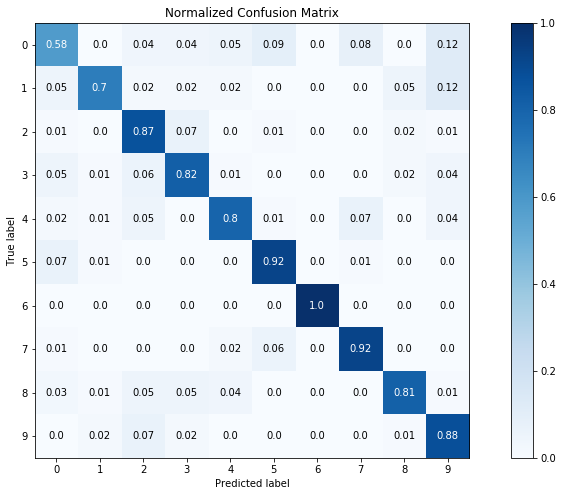

<Figure size 1080x576 with 0 Axes>

In [26]:
import scikitplot as skplt
plt.rcParams['figure.figsize'] = 15, 8
skplt.metrics.plot_confusion_matrix(y_test, predictions, normalize=True)
plt.show()
plt.savefig('DNN_KT_HB_Confusion_Matrix.png')